# Kastroulis, Angelo

This notebook is an exploration of various model architectures. They are all a regression predicting latency in MLP networks. The idea is that the model will predict the latency of combinations of features, and we'll choose the one with the lowest predicted latency as our optimal path.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#load the data
df=pd.read_csv('data/performance_data_one_hot.csv')
df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (50,52,54,56,58,60,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


selectivity    latency  y_ideal     info_ec2  info_query_id info_type  \
0     0.020002  16506.344        0  c5d.4xlarge              2      scan   
1     0.039981   8238.213        0  c5d.4xlarge              2      scan   
2     0.060007   8126.125        0  c5d.4xlarge              2      scan   
3     0.020002   7898.164        0  c5d.4xlarge              2      scan   
4     0.039981   8018.367        0  c5d.4xlarge              2      scan   

  info_batch   s_rows      s_cost  s_workers  ...  p_s_op_eq  p_s_op_lt  \
0        3-1  1191828  1967851.83          0  ...          0          0   
1        3-1  2433650  1970956.39          0  ...          0          0   
2        3-1  3563488  1973780.98          0  ...          0          0   
3        3-1  1191828  1967851.83          0  ...          0          0   
4        3-1  2433650  1970956.39          0  ...          0          0   

   p_s_op_gt  p_s_op_lte  p_s_op_gte  p_d_op_eq  p_d_op_lt  p_d_op_gt  \
0          0           0           0          0          0          0   
1          0           0           0          0          0          0   
2          0           0           0          0          0          0   
3          0           0           0          0          0          0   
4          0           0           0          0          0          0   

   p_d_op_lte  p_d_op_gte  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 114 columns]

In [3]:
def extract_features(df):
    x = df[['s_workers', 'idx_q','idx_e', 'idx_p', 'idx_s', 'idx_d',
       'h_numa', 'h_avx2',
       'h_avx512bw', 'h_avx512vl', 'h_avx512cd', 'h_avx512dq',
       'h_ss', 'h_3dnowprefetch', 'h_erms', 'h_bmi2',
       'h_invpcid', 'p_e','p_q', 'p_s', 'p_p',
       'p_d', 'p_e_o', 'p_s_o', 'p_d_o', 'p_p_o', 'p_q_o',
       'p_q_path_index', 'p_q_path_filter', 'p_q_path_bitmap',
       'p_s_path_index', 'p_s_path_filter', 'p_s_path_bitmap',
       'p_d_path_index', 'p_d_path_filter', 'p_d_path_bitmap',
       'p_p_path_index', 'p_p_path_filter', 'p_p_path_bitmap',
       'p_e_path_index', 'p_e_path_filter', 'p_e_path_bitmap',
       'p_p_op_eq', 'p_p_op_lt', 'p_p_op_gt', 'p_p_op_lte', 'p_p_op_gte',
       'p_q_op_eq', 'p_q_op_lt', 'p_q_op_gt', 'p_q_op_lte', 'p_q_op_gte',
       'p_e_op_eq', 'p_e_op_lt', 'p_e_op_gt', 'p_e_op_lte', 'p_e_op_gte',
       'p_s_op_eq', 'p_s_op_lt', 'p_s_op_gt', 'p_s_op_lte', 'p_s_op_gte',
       'p_d_op_eq', 'p_d_op_lt', 'p_d_op_gt', 'p_d_op_lte', 'p_d_op_gte']]
    x=pd.concat([x, tf.keras.utils.normalize(df[['h_mem', 'h_cores', 'h_clk', 'h_l1d', 'h_l1i', 'h_l2', 'h_l3', 
'h_bogomips', 'p_e_v', 'p_s_v', 'p_p_v', 'p_q_v', 'p_d_v']])], axis=1)
    return x

In [4]:
Y = df[['latency' ]]
X = extract_features(df)

In [5]:
#create a regression
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
import tensorflow as tf

Using TensorFlow backend.


In [6]:
def get_model(n_1, n_2, act_1, act_2):
    keras.backend.clear_session()

    model = Sequential()

    model.add(Dense(n_1, activation=act_1))
    model.add(Dense(n_2, activation=act_2))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
    
    return model

# Architecture 1

In [7]:
#architecture 1
model = get_model(512, 256, "relu", "relu")

In [8]:
#this function will help plot the test/train accuracy
def plot_hist(epochs, hist):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    X = range(1, epochs + 1)
    
    #plot the loss as circles and the accuracy as a line
    ax1.plot(X, hist.history['loss'], "bo", label="Loss Training")
    ax1.plot(X, hist.history['val_loss'], "b", label="Loss Validation")
    
    ax2.plot(X, hist.history['mean_absolute_error'], "bo", label="MAE Training")
    ax2.plot(X, hist.history['val_mean_absolute_error'], "b", label="MAE Validation")
   
    ax3.plot(X, hist.history['mean_absolute_percentage_error'], "bo", label="MAPE Training")
    ax3.plot(X, hist.history['val_mean_absolute_percentage_error'], "b", label="MAPE Validation")
    
    ax4.plot(X, hist.history['cosine_proximity'], "bo", label="Cosine Training")
    ax4.plot(X, hist.history['val_cosine_proximity'], "b", label="Cosine Validation")
    
    
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title('Training and Validation MAE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.legend()

    ax3.set_title('Training and Validation MAPE')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('MAPE')
    ax3.legend()
    
    ax4.set_title('Training and Validation Cosine')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Cosine')
    ax4.legend()
    
    plt.show()

In [11]:
def train_model(m, filename, x, y, epochs):
    cb = keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    hist = m.fit(x=x.values, y=y.values, epochs=epochs, validation_split=.2, callbacks=[cb])
    
    print("Evaluating Model")
    print (model.evaluate(x.values, y.values))
    
    return hist

In [12]:
hist = train_model(model, "ModelMLP512.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 50us/step - loss: 33645852.7344 - mean_squared_error: 33645852.7344 - mean_absolute_error: 2464.0100 - mean_absolute_percentage_error: 7934.1125 - cosine_proximity: -0.9927 - val_loss: 1827771.0031 - val_mean_squared_error: 1827771.0031 - val_mean_absolute_error: 1002.0940 - val_mean_absolute_percentage_error: 44.6234 - val_cosine_proximity: -0.9996
Epoch 2/100
20263/20263 [==============================] - 1s 49us/step - loss: 33202876.6520 - mean_squared_error: 33202876.6520 - mean_absolute_error: 2475.3257 - mean_absolute_percentage_error: 7854.2472 - cosine_proximity: -0.9933 - val_loss: 1913713.4375 - val_mean_squared_error: 1913713.4375 - val_mean_absolute_error: 1044.7140 - val_mean_absolute_percentage_error: 43.3088 - val_cosine_proximity: -0.9996
Epoch 3/100
20263/20263 [==============================] - 1s 49us/step - loss: 33342729.7483 - mean_squared_error: 3334272

Epoch 21/100
20263/20263 [==============================] - 1s 50us/step - loss: 24593408.1081 - mean_squared_error: 24593408.1081 - mean_absolute_error: 2251.4688 - mean_absolute_percentage_error: 7135.3204 - cosine_proximity: -0.9955 - val_loss: 1800756.1209 - val_mean_squared_error: 1800756.1209 - val_mean_absolute_error: 970.0410 - val_mean_absolute_percentage_error: 44.9376 - val_cosine_proximity: -0.9996
Epoch 22/100
20263/20263 [==============================] - 1s 50us/step - loss: 23175465.7683 - mean_squared_error: 23175465.7683 - mean_absolute_error: 2211.6471 - mean_absolute_percentage_error: 6848.9297 - cosine_proximity: -0.9973 - val_loss: 1795955.6771 - val_mean_squared_error: 1795955.6771 - val_mean_absolute_error: 974.7803 - val_mean_absolute_percentage_error: 44.7557 - val_cosine_proximity: -1.0000
Epoch 23/100
20263/20263 [==============================] - 1s 50us/step - loss: 22891491.4682 - mean_squared_error: 22891491.4682 - mean_absolute_error: 2196.8129 - mean_a

Epoch 41/100
20263/20263 [==============================] - 1s 50us/step - loss: 19310467.8539 - mean_squared_error: 19310467.8539 - mean_absolute_error: 2071.5296 - mean_absolute_percentage_error: 6208.3558 - cosine_proximity: -0.9969 - val_loss: 1890309.1773 - val_mean_squared_error: 1890309.1773 - val_mean_absolute_error: 935.8549 - val_mean_absolute_percentage_error: 44.7848 - val_cosine_proximity: -1.0000
Epoch 42/100
20263/20263 [==============================] - 1s 49us/step - loss: 19071983.8155 - mean_squared_error: 19071983.8155 - mean_absolute_error: 2074.4433 - mean_absolute_percentage_error: 6400.1151 - cosine_proximity: -0.9968 - val_loss: 1927155.6860 - val_mean_squared_error: 1927155.6860 - val_mean_absolute_error: 953.5536 - val_mean_absolute_percentage_error: 45.4231 - val_cosine_proximity: -1.0000
Epoch 43/100
20263/20263 [==============================] - 1s 49us/step - loss: 19003925.1645 - mean_squared_error: 19003925.1645 - mean_absolute_error: 2066.5605 - mean_a

Epoch 61/100
20263/20263 [==============================] - 1s 50us/step - loss: 17666972.1860 - mean_squared_error: 17666972.1860 - mean_absolute_error: 1987.1757 - mean_absolute_percentage_error: 5665.3738 - cosine_proximity: -0.9959 - val_loss: 2006491.7853 - val_mean_squared_error: 2006491.7853 - val_mean_absolute_error: 920.1368 - val_mean_absolute_percentage_error: 45.2611 - val_cosine_proximity: -1.0000
Epoch 62/100
20263/20263 [==============================] - 1s 49us/step - loss: 17208101.8960 - mean_squared_error: 17208101.8960 - mean_absolute_error: 1975.2983 - mean_absolute_percentage_error: 5674.5771 - cosine_proximity: -0.9956 - val_loss: 2034117.2959 - val_mean_squared_error: 2034117.2959 - val_mean_absolute_error: 911.3885 - val_mean_absolute_percentage_error: 45.6281 - val_cosine_proximity: -1.0000
Epoch 63/100
20263/20263 [==============================] - 1s 52us/step - loss: 17630635.9334 - mean_squared_error: 17630635.9334 - mean_absolute_error: 1967.6079 - mean_a

Epoch 81/100
20263/20263 [==============================] - 1s 49us/step - loss: 16845345.4013 - mean_squared_error: 16845345.4013 - mean_absolute_error: 1944.2412 - mean_absolute_percentage_error: 5439.5920 - cosine_proximity: -0.9975 - val_loss: 2257863.0138 - val_mean_squared_error: 2257863.0138 - val_mean_absolute_error: 921.9874 - val_mean_absolute_percentage_error: 47.6093 - val_cosine_proximity: -1.0000
Epoch 82/100
20263/20263 [==============================] - 1s 49us/step - loss: 16746364.0862 - mean_squared_error: 16746364.0862 - mean_absolute_error: 1934.5233 - mean_absolute_percentage_error: 5358.7972 - cosine_proximity: -0.9976 - val_loss: 2170295.2411 - val_mean_squared_error: 2170295.2411 - val_mean_absolute_error: 924.0465 - val_mean_absolute_percentage_error: 46.8014 - val_cosine_proximity: -1.0000
Epoch 83/100
20263/20263 [==============================] - 1s 50us/step - loss: 16439067.4023 - mean_squared_error: 16439067.4023 - mean_absolute_error: 1912.7967 - mean_a

Evaluating Model
25329/25329 [==============================] - 0s 14us/step
[13942416.703899186, 13942416.703899186, 1711.6762440607774, 3319.8080428779854, -0.9973153163934084]


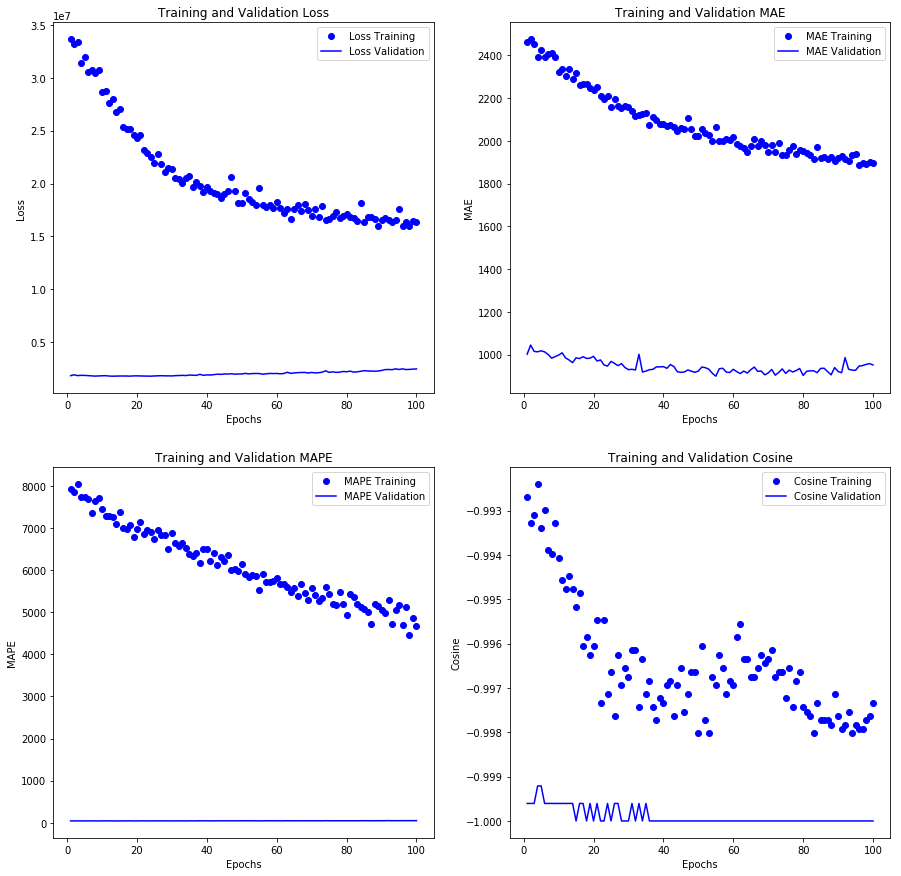

In [13]:
plot_hist(100, hist)

In [15]:
from keras.models import load_model
model = load_model("ModelMLP512.h5")

In [16]:
#Since each selectivity was run many times, we can group by that and find the one
#with the lowest latency. that's our best
def find_best(df1, y_label):
    df_out = pd.DataFrame()
    
    #group by the query and server, sort by selectivity, and take the top performing query
    for name, group in df1.sort_values(y_label, ascending=True).groupby(["info_ec2","info_query_id","selectivity"], as_index=False):
    
        fastest = group.head(1)#["latency"].iloc[0]
        df_out = pd.concat([df_out, fastest])
        
    return df_out

In [68]:
#this function will plot actual, predicted, and the optimizer's choice for a given query
def plot_actual_vs_predicted(df_f, df_p, df_opt, query):
    fastest = df_f[df_f["info_query_id"] == query] 
    pred = df_p[df_p["info_query_id"] == query] 
    opt = df_opt[df_opt["query"] == query]

    plt.figure(figsize=(16, 6))
    
    plt.plot(fastest["selectivity"], fastest["latency"], label="Actual Fastest")
    plt.plot(pred["selectivity"], pred["predicted"], label="Predicted",linestyle='dashed')
    plt.plot(pred["selectivity"], pred["latency"], label="Predicted Actual")
    plt.plot(opt["selectivity"], opt["latency"], label="Optimizer")
    
    plt.title("Selectivity vs Latency for Query " + str(query))
    plt.ylabel("Latency")
    plt.xlabel("Selectivity")
    plt.legend()

In [20]:
df["predicted"] = model.predict(extract_features(df))

In [21]:
#we find the actual best (df_f) and what we predicted as the best (df_p)
df_f = find_best(df, "latency").sort_values("selectivity") 
df_p = find_best(df, "predicted").sort_values("selectivity")

In [22]:
#This is the optimizer's path
df_c5_opt = pd.read_csv('data/c5_control.txt').sort_values("selectivity")

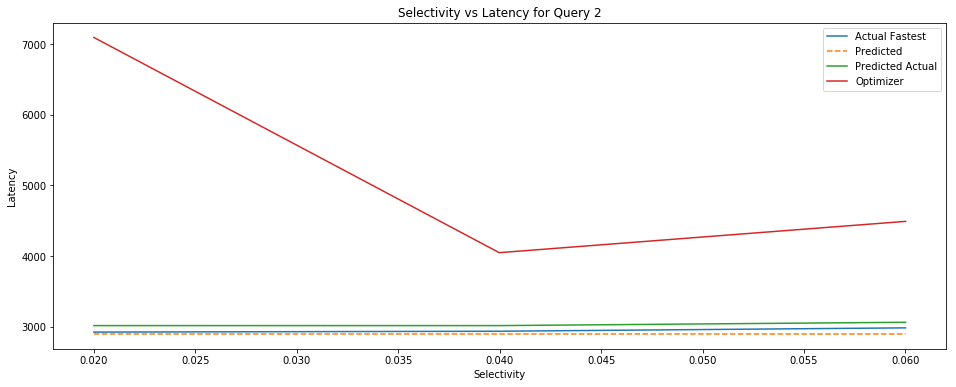

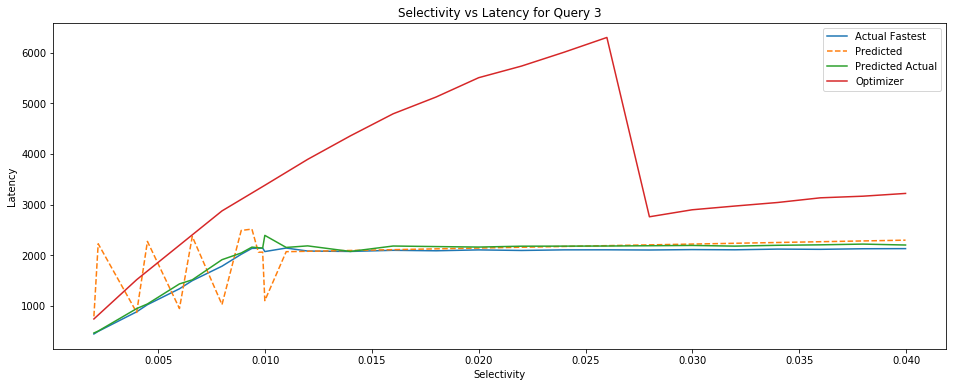

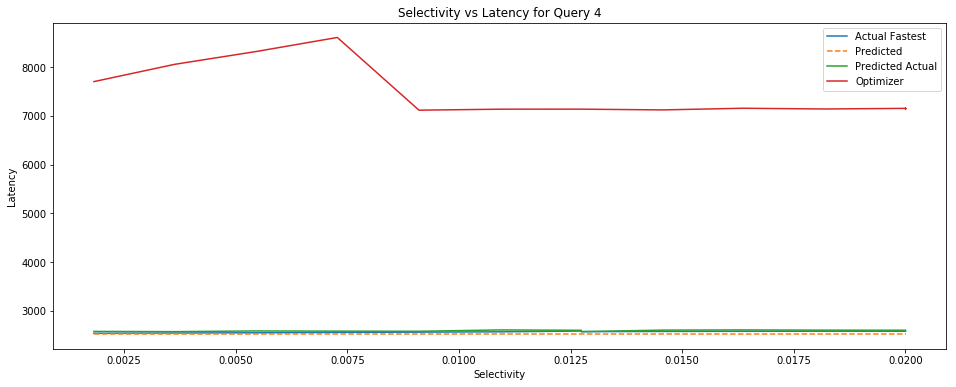

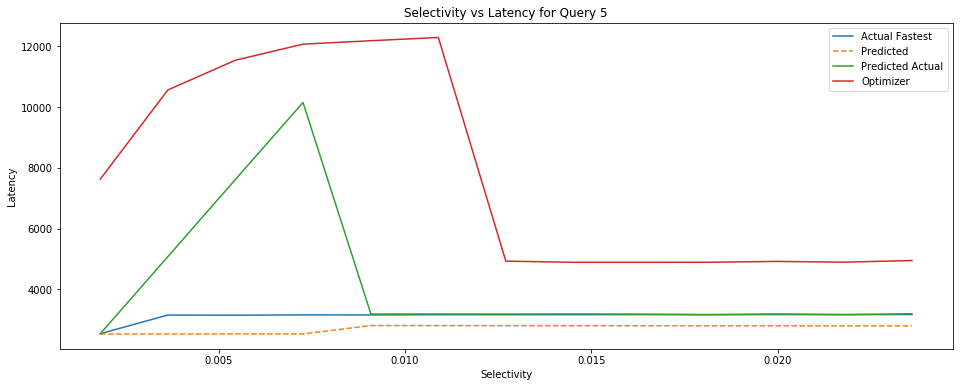

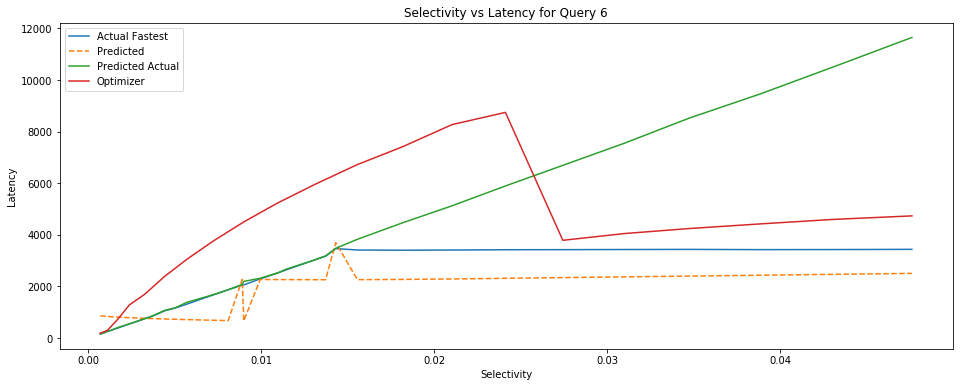

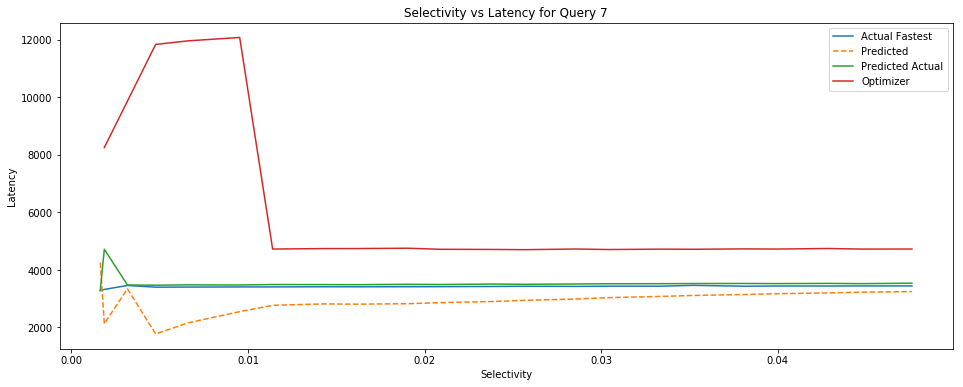

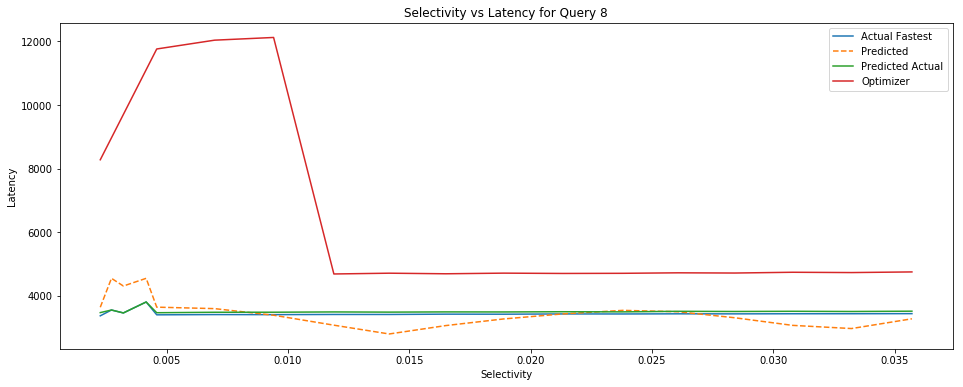

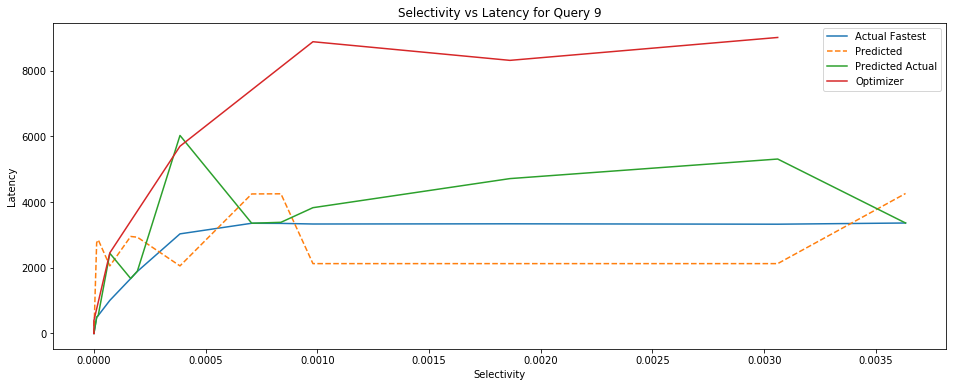

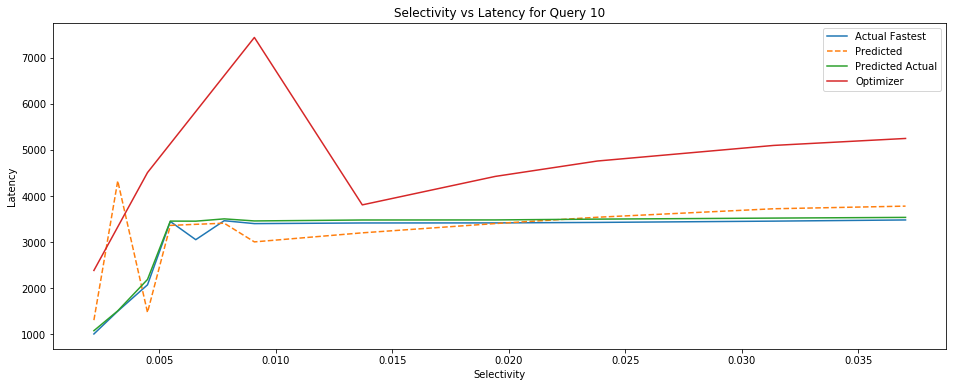

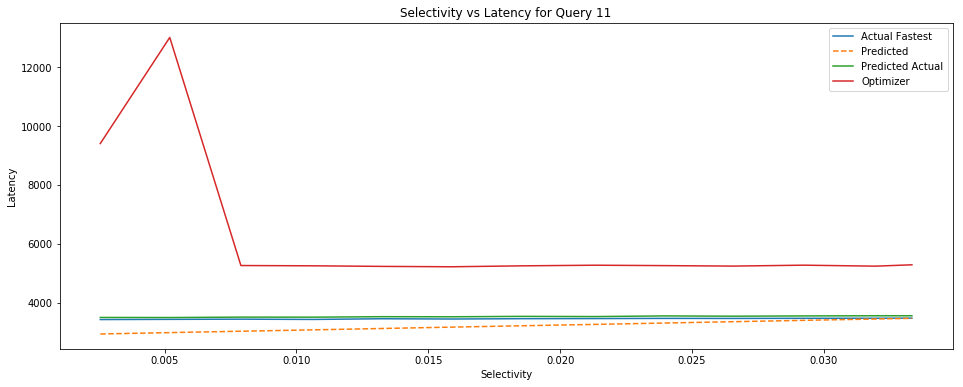

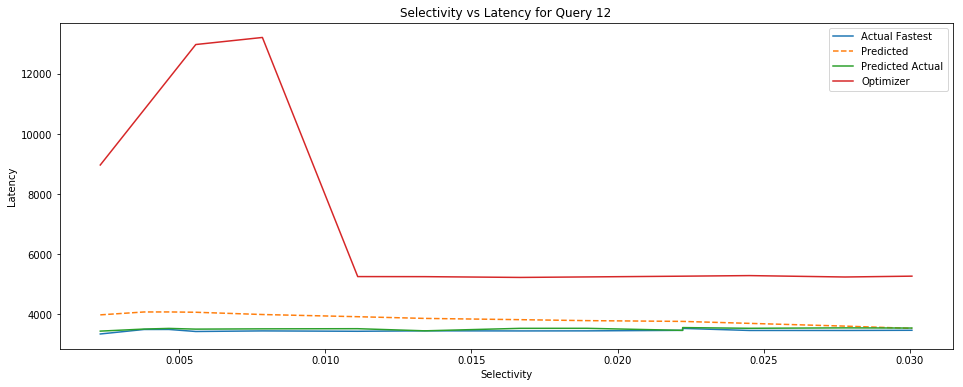

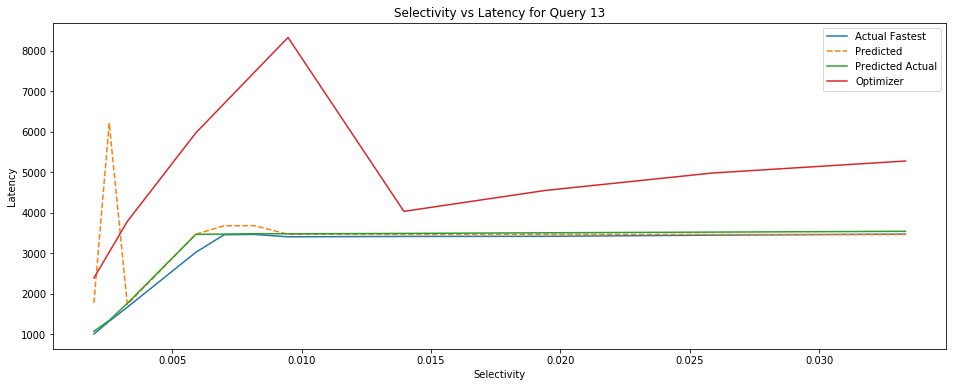

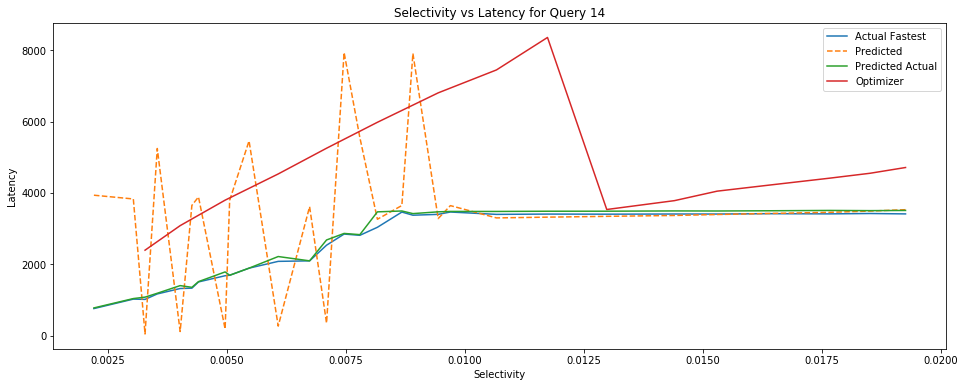

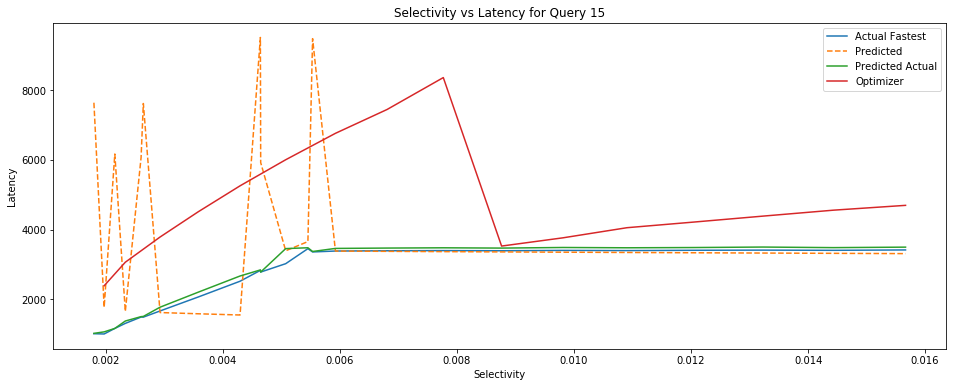

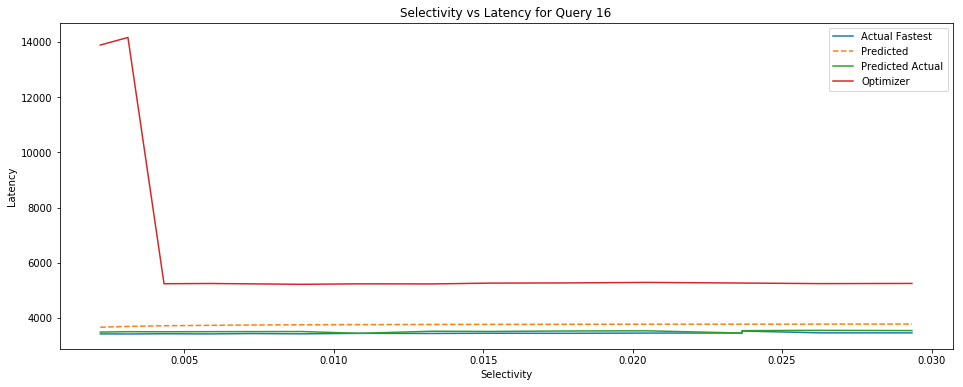

In [23]:
#Now, we plot what the optimizer thought, vs what was the best, vs what we predicted latency 
# would be, vs how the predicted item actually fares (Predicted Actual)
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

# Architecture 2
Seeing if less neurons will give us similar results

In [24]:
#less neurons
model = get_model(128, 64, "relu", "relu")
hist = train_model(model, "ModelMLP-2.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 36us/step - loss: 1430706012.4444 - mean_squared_error: 1430706012.4444 - mean_absolute_error: 16325.2414 - mean_absolute_percentage_error: 32275.5432 - cosine_proximity: -0.9988 - val_loss: 60660995.2333 - val_mean_squared_error: 60660995.2333 - val_mean_absolute_error: 7479.3001 - val_mean_absolute_percentage_error: 330.0067 - val_cosine_proximity: -1.0000
Epoch 2/100
20263/20263 [==============================] - 1s 28us/step - loss: 1178083873.3787 - mean_squared_error: 1178083873.3787 - mean_absolute_error: 18079.5758 - mean_absolute_percentage_error: 53069.7022 - cosine_proximity: -1.0000 - val_loss: 40953535.0996 - val_mean_squared_error: 40953535.0996 - val_mean_absolute_error: 5162.6271 - val_mean_absolute_percentage_error: 236.8983 - val_cosine_proximity: -1.0000
Epoch 3/100
20263/20263 [==============================] - 1s 28us/step - loss: 948047037.7073 - mean_squ

20263/20263 [==============================] - 1s 29us/step - loss: 190790815.8113 - mean_squared_error: 190790815.8113 - mean_absolute_error: 5705.5343 - mean_absolute_percentage_error: 28661.5387 - cosine_proximity: -1.0000 - val_loss: 2675822.3082 - val_mean_squared_error: 2675822.3082 - val_mean_absolute_error: 1353.8228 - val_mean_absolute_percentage_error: 63.1506 - val_cosine_proximity: -1.0000
Epoch 21/100
20263/20263 [==============================] - 1s 29us/step - loss: 186730699.9453 - mean_squared_error: 186730699.9453 - mean_absolute_error: 5632.5122 - mean_absolute_percentage_error: 28589.8843 - cosine_proximity: -1.0000 - val_loss: 2678441.2439 - val_mean_squared_error: 2678441.2439 - val_mean_absolute_error: 1342.3909 - val_mean_absolute_percentage_error: 62.4111 - val_cosine_proximity: -1.0000
Epoch 22/100
20263/20263 [==============================] - 1s 32us/step - loss: 182059501.7550 - mean_squared_error: 182059501.7550 - mean_absolute_error: 5559.8155 - mean_abso

Epoch 40/100
20263/20263 [==============================] - 1s 30us/step - loss: 127580749.6881 - mean_squared_error: 127580749.6881 - mean_absolute_error: 4642.4511 - mean_absolute_percentage_error: 27106.4659 - cosine_proximity: -1.0000 - val_loss: 2598265.8591 - val_mean_squared_error: 2598265.8591 - val_mean_absolute_error: 1246.6435 - val_mean_absolute_percentage_error: 53.5591 - val_cosine_proximity: -1.0000
Epoch 41/100
20263/20263 [==============================] - 1s 29us/step - loss: 125919313.8969 - mean_squared_error: 125919313.8969 - mean_absolute_error: 4614.8734 - mean_absolute_percentage_error: 27102.3055 - cosine_proximity: -1.0000 - val_loss: 2593366.7417 - val_mean_squared_error: 2593366.7417 - val_mean_absolute_error: 1246.0335 - val_mean_absolute_percentage_error: 53.5683 - val_cosine_proximity: -1.0000
Epoch 42/100
20263/20263 [==============================] - 1s 30us/step - loss: 123781444.0680 - mean_squared_error: 123781444.0680 - mean_absolute_error: 4572.844

Epoch 60/100
20263/20263 [==============================] - 1s 31us/step - loss: 105928478.8738 - mean_squared_error: 105928478.8738 - mean_absolute_error: 4208.4591 - mean_absolute_percentage_error: 26615.9043 - cosine_proximity: -1.0000 - val_loss: 2426747.3421 - val_mean_squared_error: 2426747.3421 - val_mean_absolute_error: 1189.1703 - val_mean_absolute_percentage_error: 52.3016 - val_cosine_proximity: -1.0000
Epoch 61/100
20263/20263 [==============================] - 1s 30us/step - loss: 106052599.8560 - mean_squared_error: 106052599.8560 - mean_absolute_error: 4193.6027 - mean_absolute_percentage_error: 26859.4177 - cosine_proximity: -1.0000 - val_loss: 2375178.4886 - val_mean_squared_error: 2375178.4886 - val_mean_absolute_error: 1178.9228 - val_mean_absolute_percentage_error: 53.0175 - val_cosine_proximity: -1.0000
Epoch 62/100
20263/20263 [==============================] - 1s 30us/step - loss: 104682736.6309 - mean_squared_error: 104682736.6309 - mean_absolute_error: 4185.961

Epoch 80/100
20263/20263 [==============================] - 1s 30us/step - loss: 85805661.3036 - mean_squared_error: 85805661.3036 - mean_absolute_error: 3853.7808 - mean_absolute_percentage_error: 26736.2607 - cosine_proximity: -1.0000 - val_loss: 2494246.5806 - val_mean_squared_error: 2494246.5806 - val_mean_absolute_error: 1275.8115 - val_mean_absolute_percentage_error: 56.0869 - val_cosine_proximity: -1.0000
Epoch 81/100
20263/20263 [==============================] - 1s 29us/step - loss: 84375588.6936 - mean_squared_error: 84375588.6936 - mean_absolute_error: 3815.4250 - mean_absolute_percentage_error: 26716.8275 - cosine_proximity: -1.0000 - val_loss: 2473830.1680 - val_mean_squared_error: 2473830.1680 - val_mean_absolute_error: 1269.4716 - val_mean_absolute_percentage_error: 56.3661 - val_cosine_proximity: -1.0000
Epoch 82/100
20263/20263 [==============================] - 1s 29us/step - loss: 84061509.2239 - mean_squared_error: 84061509.2239 - mean_absolute_error: 3816.4018 - me

Epoch 100/100
20263/20263 [==============================] - 1s 31us/step - loss: 69527212.9057 - mean_squared_error: 69527212.9057 - mean_absolute_error: 3559.3665 - mean_absolute_percentage_error: 26226.7910 - cosine_proximity: -1.0000 - val_loss: 2477417.1524 - val_mean_squared_error: 2477417.1524 - val_mean_absolute_error: 1287.9838 - val_mean_absolute_percentage_error: 57.6121 - val_cosine_proximity: -1.0000
Evaluating Model
25329/25329 [==============================] - 0s 9us/step
[55214733.80149113, 55214733.80149113, 3065.066942734782, 20887.73113859293, -0.9999999921684923]


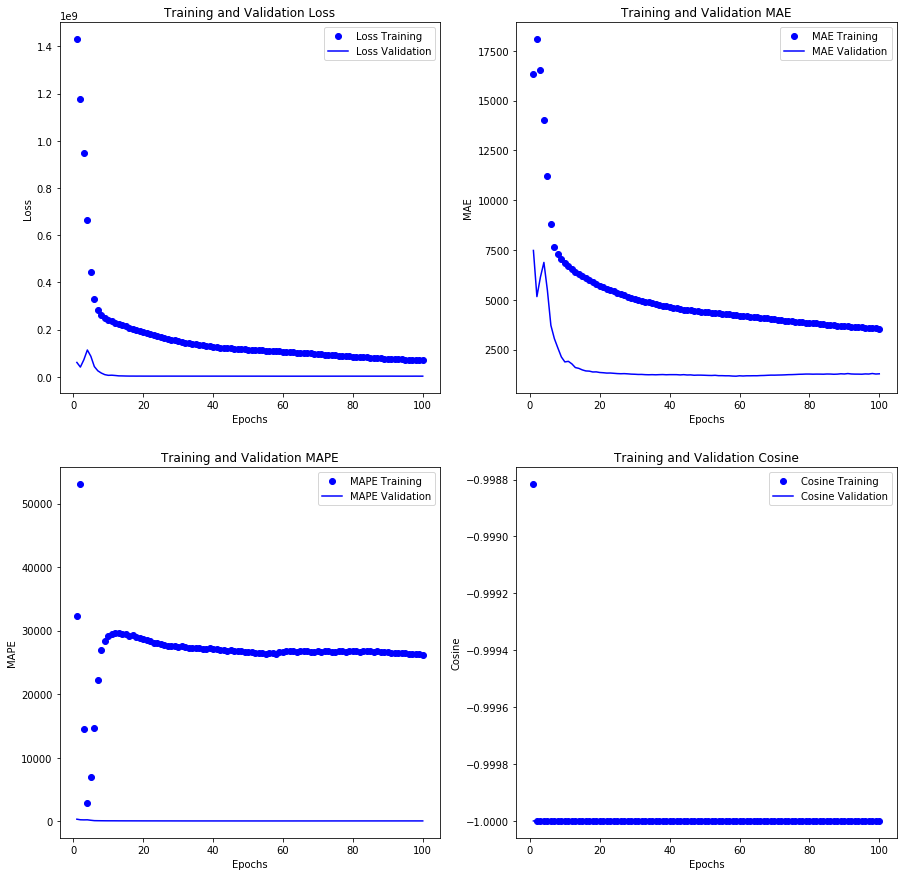

In [25]:
plot_hist(100, hist)

In [26]:
df["predicted"] = model.predict(extract_features(df))
df_f = find_best(df, "latency").sort_values("selectivity") 
df_p = find_best(df, "predicted").sort_values("selectivity") 

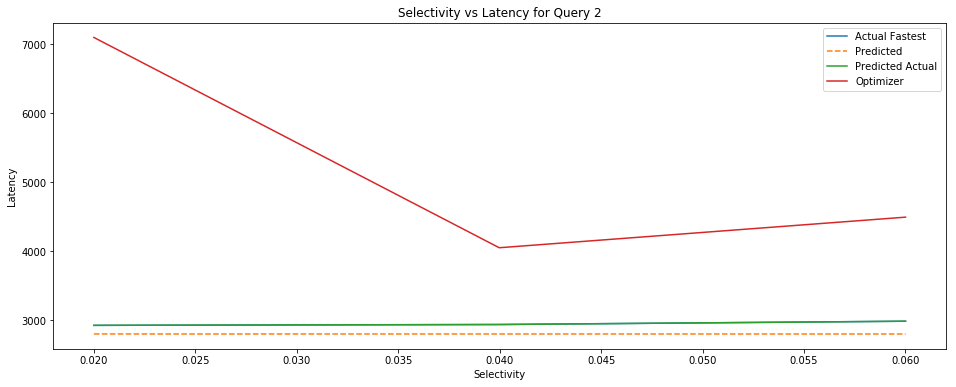

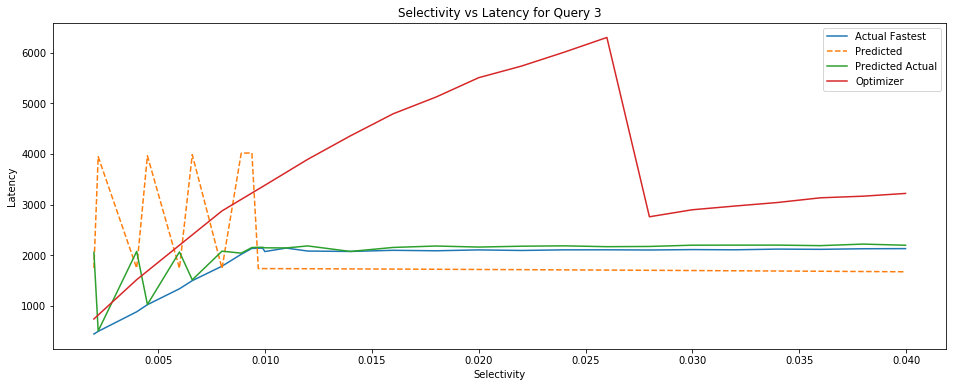

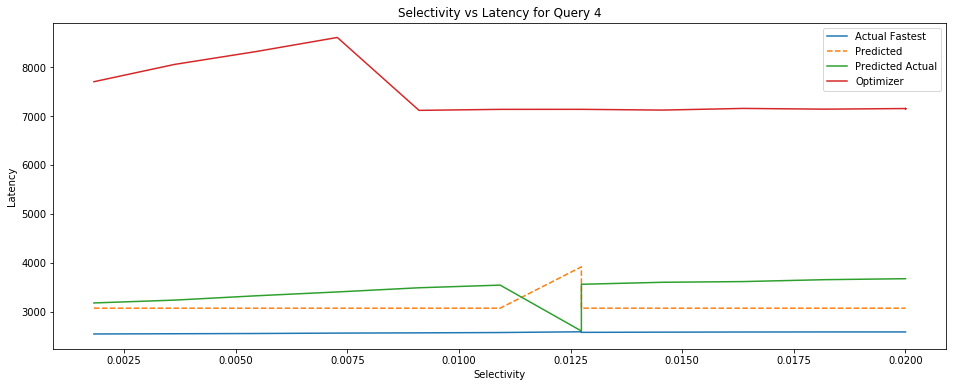

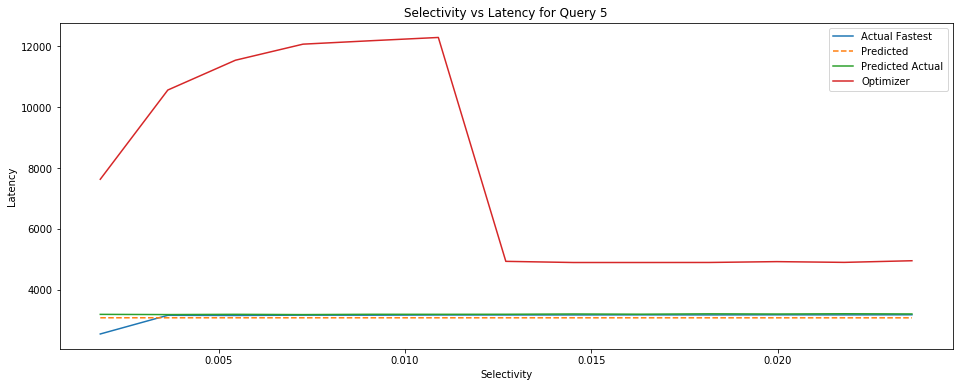

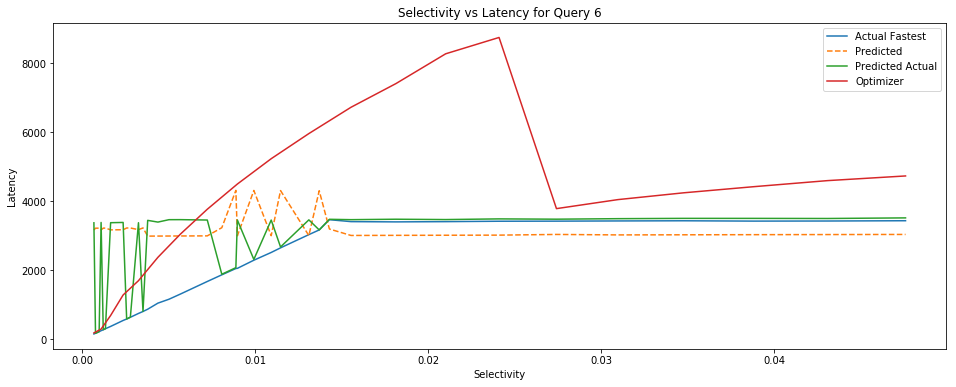

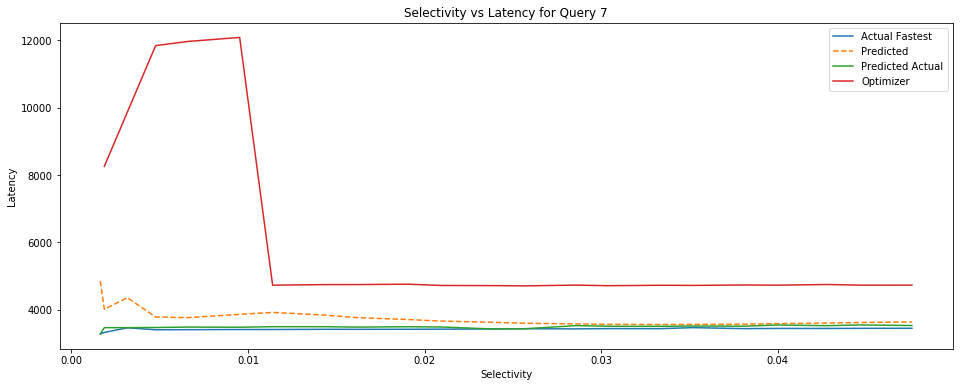

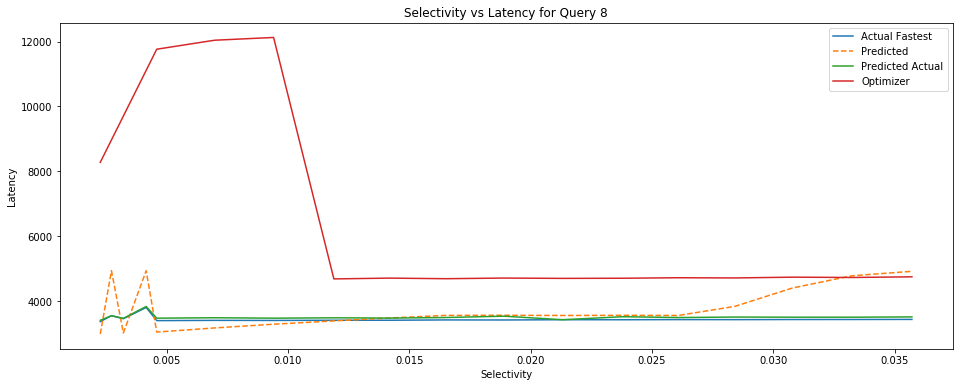

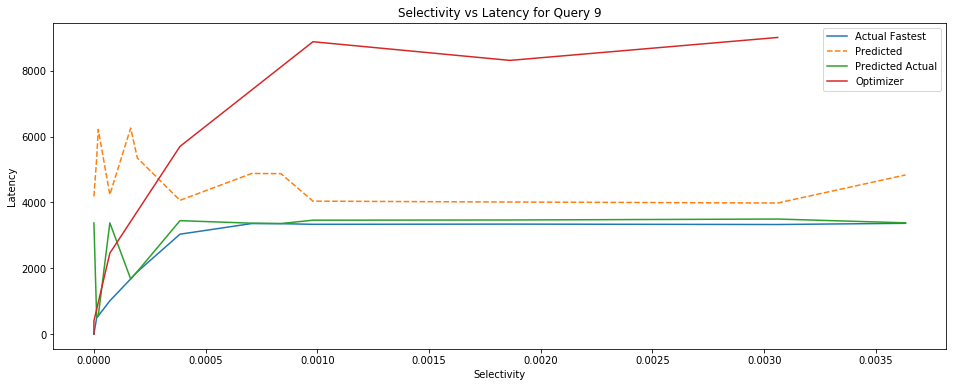

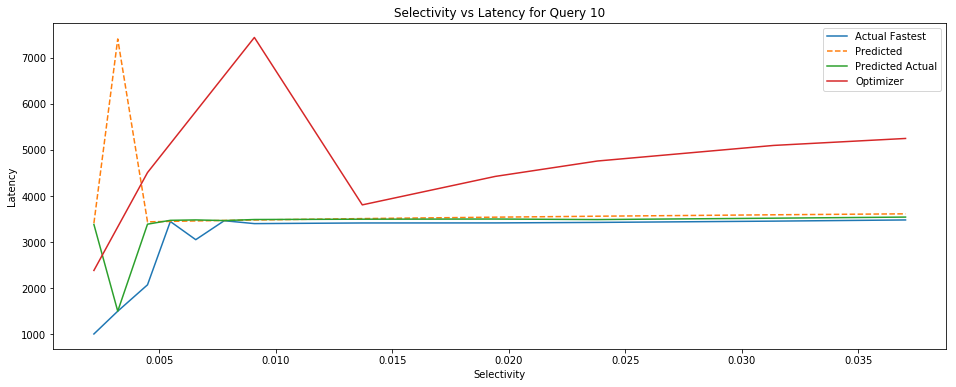

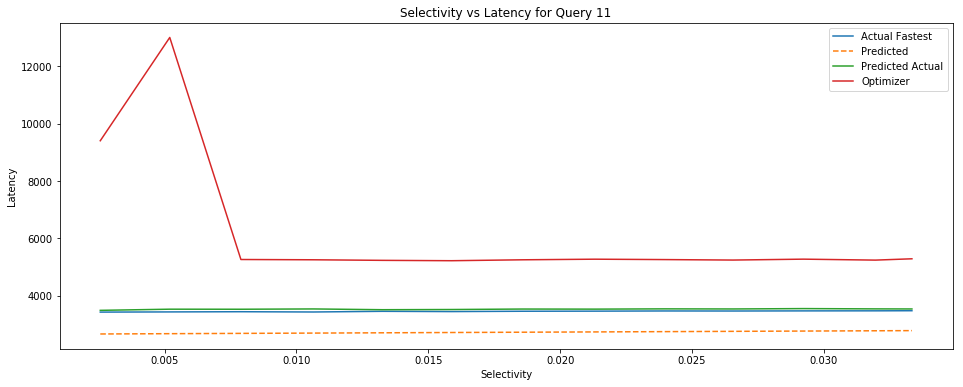

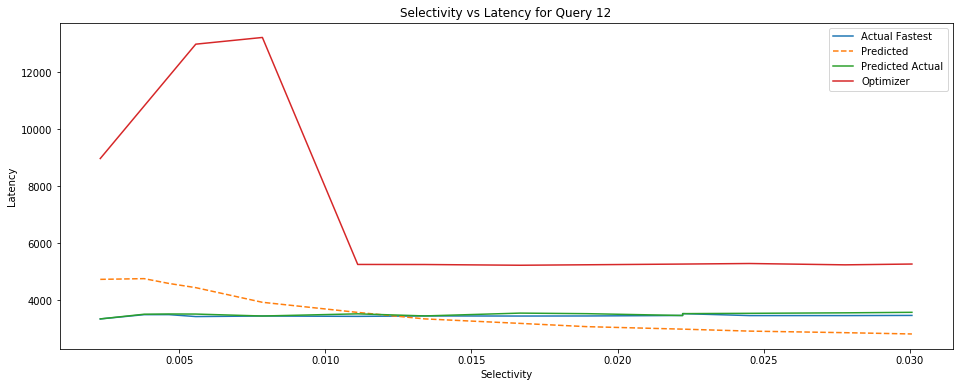

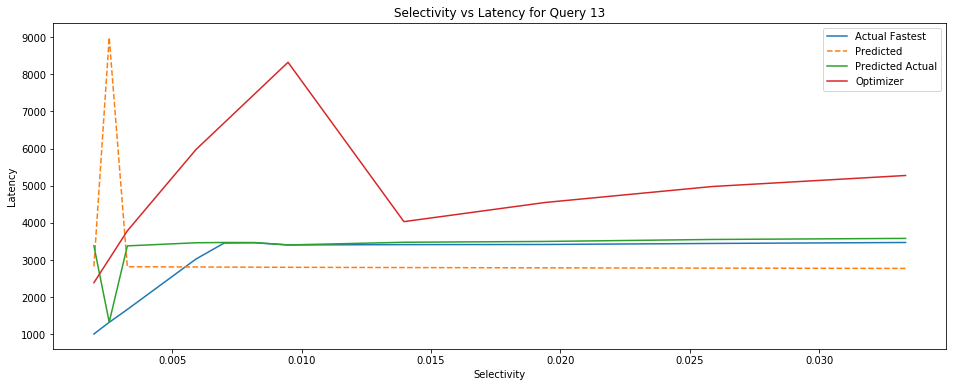

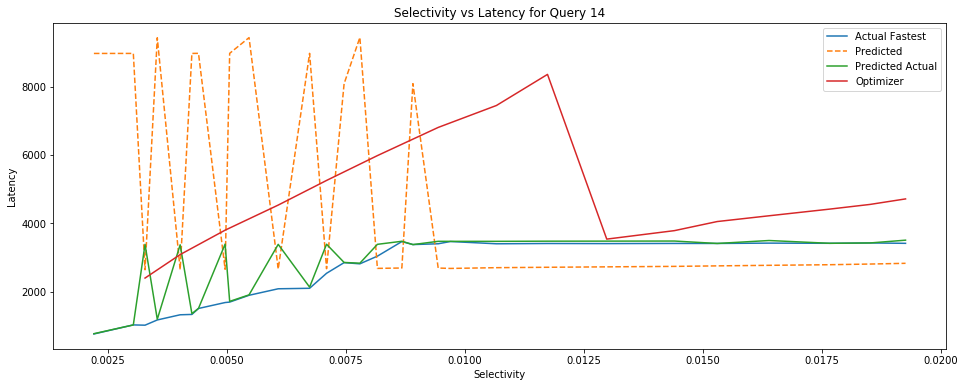

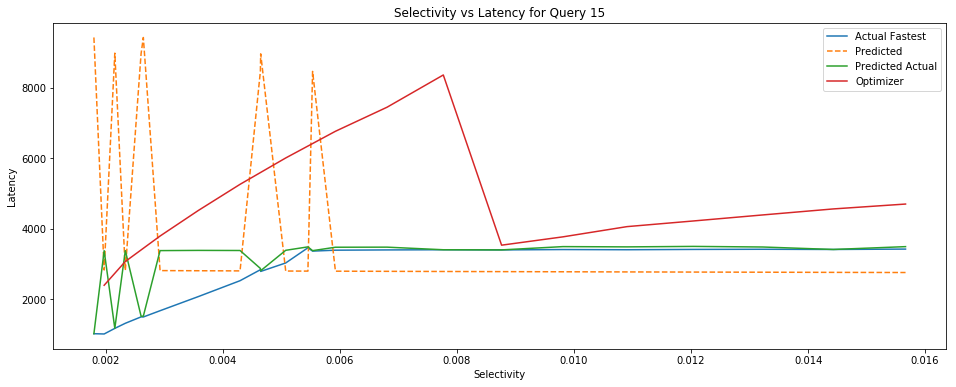

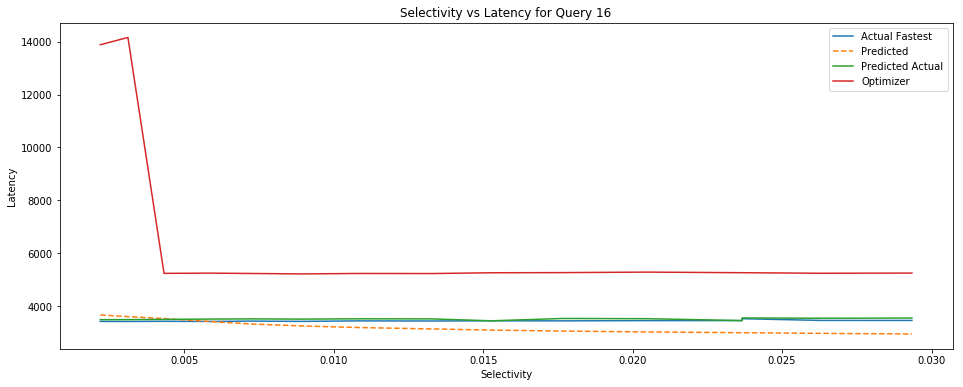

In [27]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

They give us about the same results, however the precision is definitely less. We want a more accurate model.

# Architecure 3
Seeing if very few neurons give us similar results

In [28]:
#less neurons
model = get_model(32, 16, "relu", "relu")
hist = train_model(model, "ModelMLP-3.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 36us/step - loss: 1608055543.1043 - mean_squared_error: 1608055543.1043 - mean_absolute_error: 15824.6645 - mean_absolute_percentage_error: 4557.9787 - cosine_proximity: -0.9570 - val_loss: 4487334.4516 - val_mean_squared_error: 4487334.4516 - val_mean_absolute_error: 1634.4034 - val_mean_absolute_percentage_error: 54.1192 - val_cosine_proximity: -1.0000
Epoch 2/100
20263/20263 [==============================] - 1s 29us/step - loss: 1382333310.2850 - mean_squared_error: 1382333310.2850 - mean_absolute_error: 14868.7481 - mean_absolute_percentage_error: 43460.5339 - cosine_proximity: -1.0000 - val_loss: 41645799.3415 - val_mean_squared_error: 41645799.3415 - val_mean_absolute_error: 6067.3114 - val_mean_absolute_percentage_error: 275.8599 - val_cosine_proximity: -1.0000
Epoch 3/100
20263/20263 [==============================] - 1s 28us/step - loss: 1288095379.3796 - mean_square

20263/20263 [==============================] - 1s 28us/step - loss: 291355582.9751 - mean_squared_error: 291355582.9751 - mean_absolute_error: 7933.1503 - mean_absolute_percentage_error: 20868.4378 - cosine_proximity: -1.0000 - val_loss: 48579884.0932 - val_mean_squared_error: 48579884.0932 - val_mean_absolute_error: 4727.7851 - val_mean_absolute_percentage_error: 128.6880 - val_cosine_proximity: -1.0000
Epoch 21/100
20263/20263 [==============================] - 1s 28us/step - loss: 279955228.1964 - mean_squared_error: 279955228.1964 - mean_absolute_error: 7659.9508 - mean_absolute_percentage_error: 22208.3811 - cosine_proximity: -1.0000 - val_loss: 40336524.2748 - val_mean_squared_error: 40336524.2748 - val_mean_absolute_error: 4390.3235 - val_mean_absolute_percentage_error: 119.7636 - val_cosine_proximity: -1.0000
Epoch 22/100
20263/20263 [==============================] - 1s 29us/step - loss: 271446013.6423 - mean_squared_error: 271446013.6423 - mean_absolute_error: 7446.5559 - mea

20263/20263 [==============================] - 1s 29us/step - loss: 219612853.2363 - mean_squared_error: 219612853.2363 - mean_absolute_error: 6219.8368 - mean_absolute_percentage_error: 28128.9503 - cosine_proximity: -1.0000 - val_loss: 8167614.2621 - val_mean_squared_error: 8167614.2621 - val_mean_absolute_error: 2568.1821 - val_mean_absolute_percentage_error: 88.3530 - val_cosine_proximity: -1.0000
Epoch 40/100
20263/20263 [==============================] - 1s 29us/step - loss: 218230133.1175 - mean_squared_error: 218230133.1175 - mean_absolute_error: 6188.6359 - mean_absolute_percentage_error: 28130.2058 - cosine_proximity: -1.0000 - val_loss: 8130053.2961 - val_mean_squared_error: 8130053.2961 - val_mean_absolute_error: 2564.3756 - val_mean_absolute_percentage_error: 88.6580 - val_cosine_proximity: -1.0000
Epoch 41/100
20263/20263 [==============================] - 1s 29us/step - loss: 216363028.8790 - mean_squared_error: 216363028.8790 - mean_absolute_error: 6149.2675 - mean_abso

Epoch 59/100
20263/20263 [==============================] - 1s 29us/step - loss: 188456120.0773 - mean_squared_error: 188456120.0773 - mean_absolute_error: 5670.6021 - mean_absolute_percentage_error: 28887.3421 - cosine_proximity: -1.0000 - val_loss: 6839495.6806 - val_mean_squared_error: 6839495.6806 - val_mean_absolute_error: 2320.6622 - val_mean_absolute_percentage_error: 83.3504 - val_cosine_proximity: -1.0000
Epoch 60/100
20263/20263 [==============================] - 1s 31us/step - loss: 186886247.9932 - mean_squared_error: 186886247.9932 - mean_absolute_error: 5655.0947 - mean_absolute_percentage_error: 28968.3511 - cosine_proximity: -1.0000 - val_loss: 6821529.1571 - val_mean_squared_error: 6821529.1571 - val_mean_absolute_error: 2307.5202 - val_mean_absolute_percentage_error: 82.8451 - val_cosine_proximity: -1.0000
Epoch 61/100
20263/20263 [==============================] - 1s 30us/step - loss: 185384968.2957 - mean_squared_error: 185384968.2957 - mean_absolute_error: 5627.217

Epoch 79/100
20263/20263 [==============================] - 1s 30us/step - loss: 159802373.3998 - mean_squared_error: 159802373.3998 - mean_absolute_error: 5300.0553 - mean_absolute_percentage_error: 28478.3875 - cosine_proximity: -1.0000 - val_loss: 6560456.3991 - val_mean_squared_error: 6560456.3991 - val_mean_absolute_error: 2250.4816 - val_mean_absolute_percentage_error: 80.7005 - val_cosine_proximity: -1.0000
Epoch 80/100
20263/20263 [==============================] - 1s 30us/step - loss: 158547527.2182 - mean_squared_error: 158547527.2182 - mean_absolute_error: 5275.7961 - mean_absolute_percentage_error: 28547.7965 - cosine_proximity: -1.0000 - val_loss: 6629969.5077 - val_mean_squared_error: 6629969.5077 - val_mean_absolute_error: 2250.5977 - val_mean_absolute_percentage_error: 80.0100 - val_cosine_proximity: -1.0000
Epoch 81/100
20263/20263 [==============================] - 1s 29us/step - loss: 157243860.7985 - mean_squared_error: 157243860.7985 - mean_absolute_error: 5263.720

Epoch 99/100
20263/20263 [==============================] - 1s 29us/step - loss: 138456862.3168 - mean_squared_error: 138456862.3168 - mean_absolute_error: 4974.5173 - mean_absolute_percentage_error: 27813.8350 - cosine_proximity: -1.0000 - val_loss: 6340471.0999 - val_mean_squared_error: 6340471.0999 - val_mean_absolute_error: 2194.1332 - val_mean_absolute_percentage_error: 78.0407 - val_cosine_proximity: -1.0000
Epoch 100/100
20263/20263 [==============================] - 1s 29us/step - loss: 137772182.1428 - mean_squared_error: 137772182.1428 - mean_absolute_error: 4955.7955 - mean_absolute_percentage_error: 27942.3484 - cosine_proximity: -1.0000 - val_loss: 6353106.8614 - val_mean_squared_error: 6353106.8614 - val_mean_absolute_error: 2192.4114 - val_mean_absolute_percentage_error: 77.7650 - val_cosine_proximity: -1.0000
Evaluating Model
25329/25329 [==============================] - 0s 9us/step
[111073701.10353744, 111073701.10353744, 4373.918596639321, 22466.601988983424, -0.9999

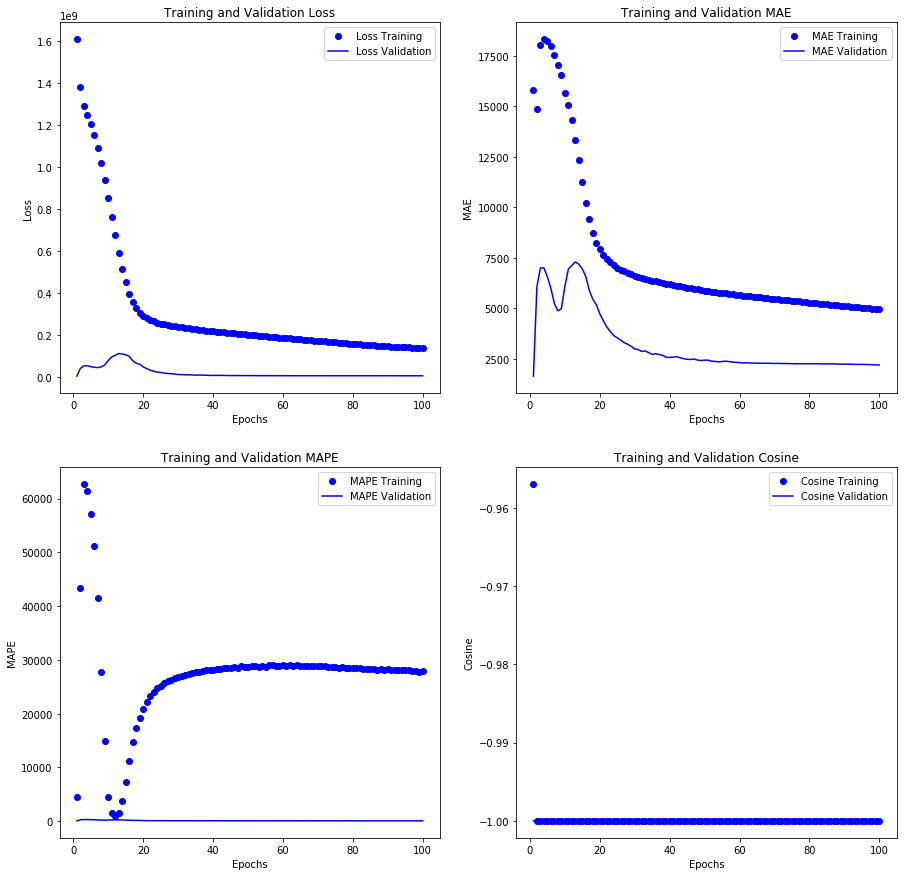

In [29]:
plot_hist(100, hist)

In [30]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

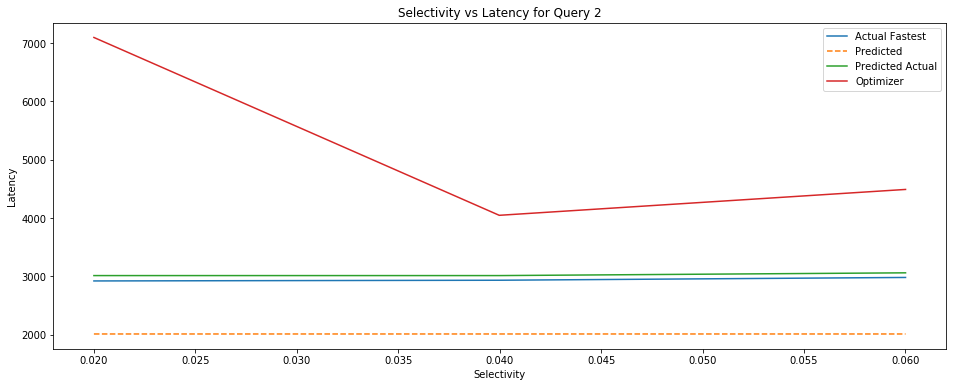

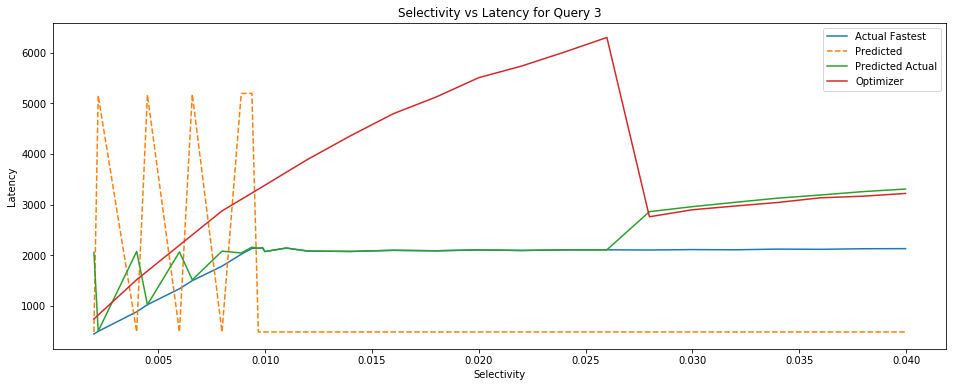

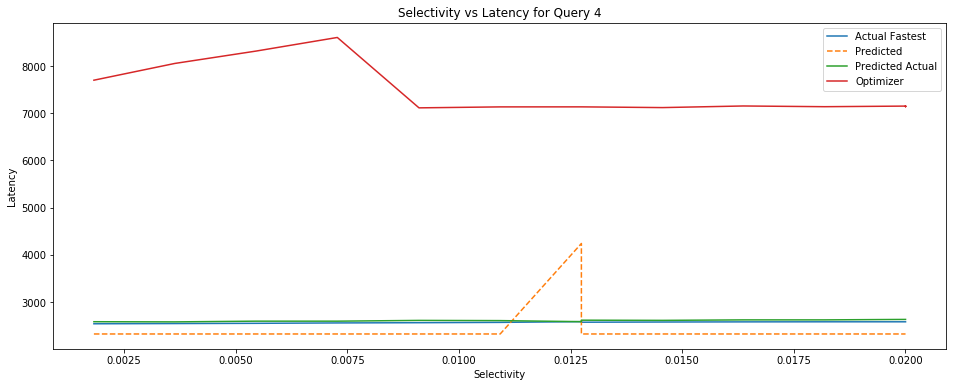

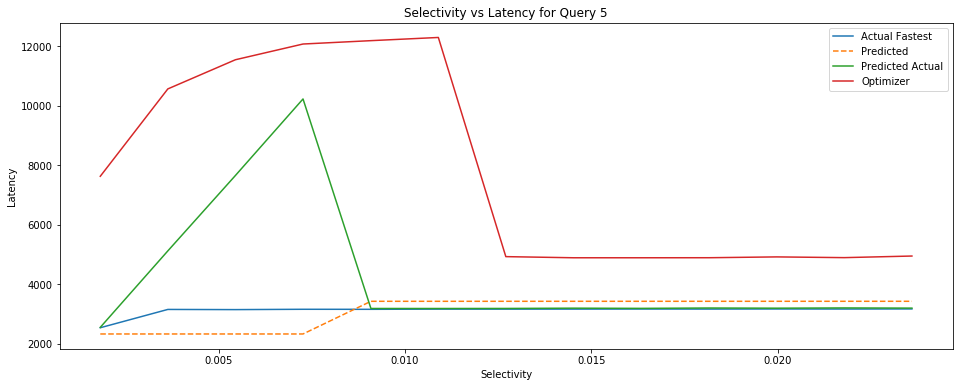

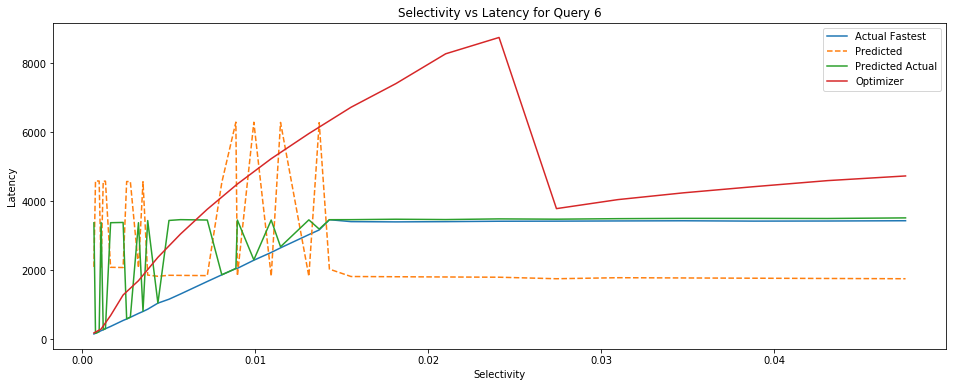

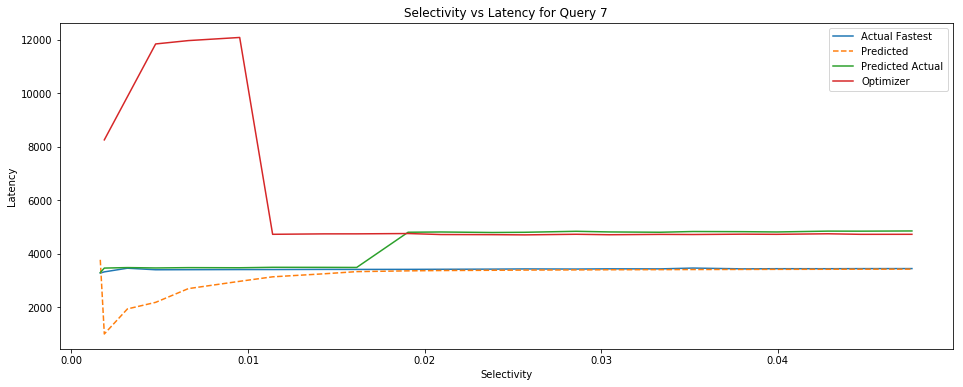

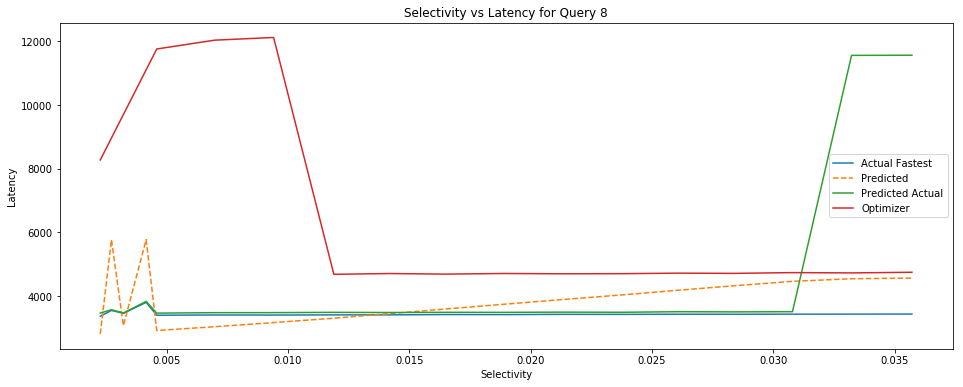

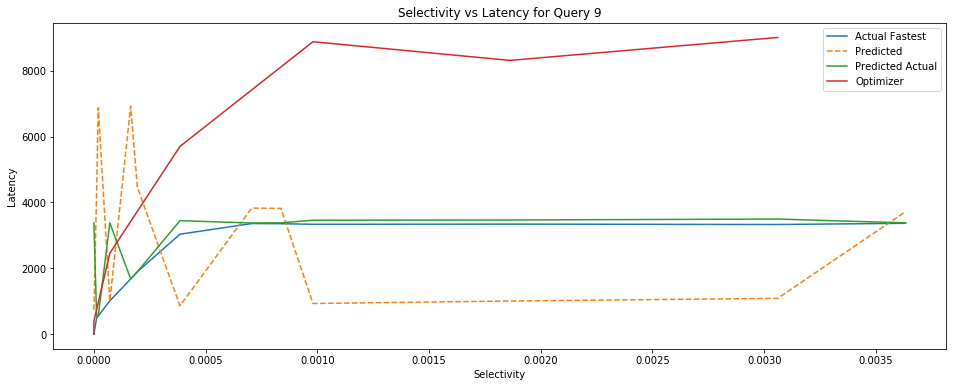

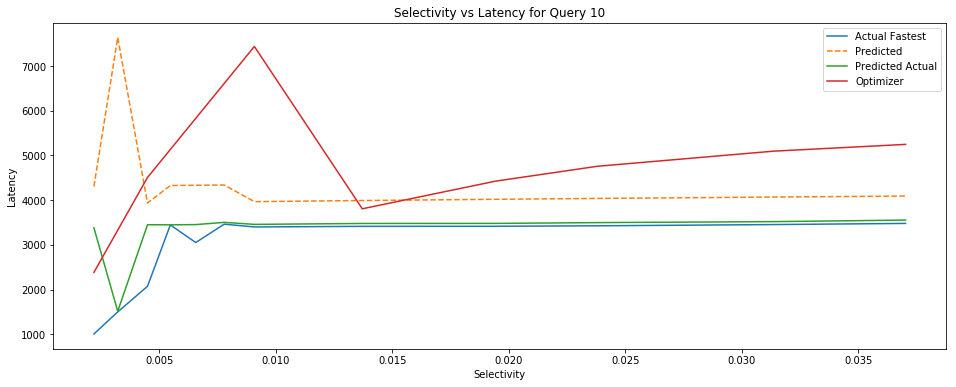

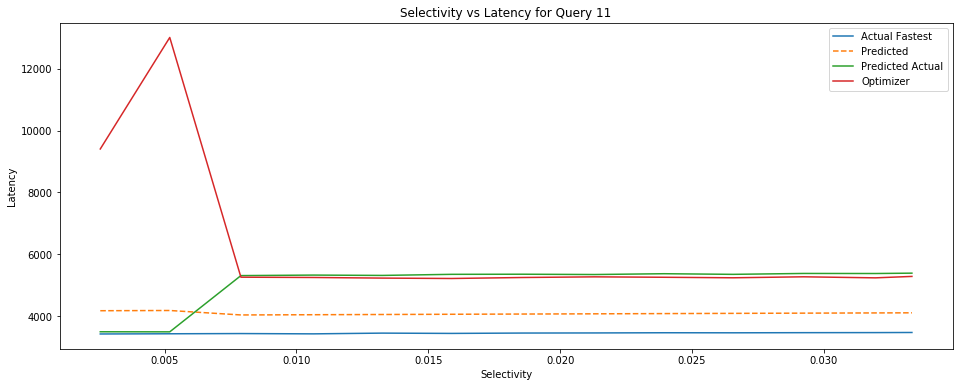

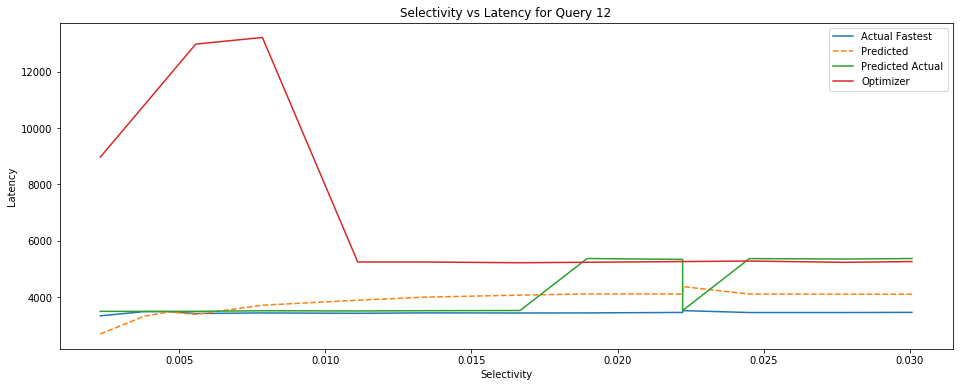

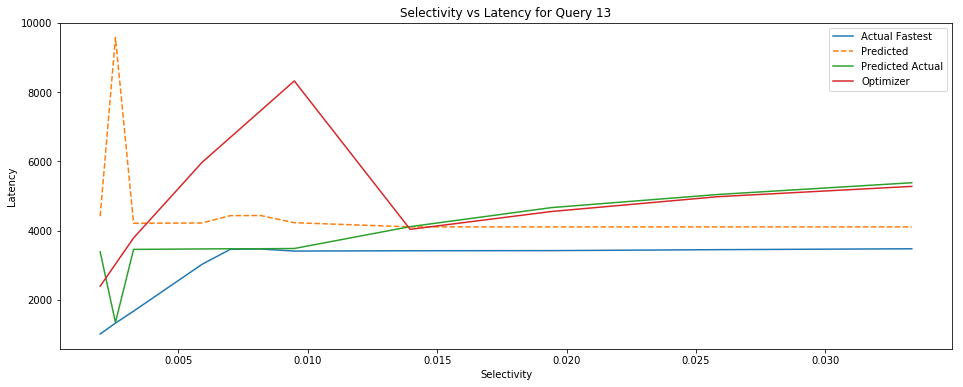

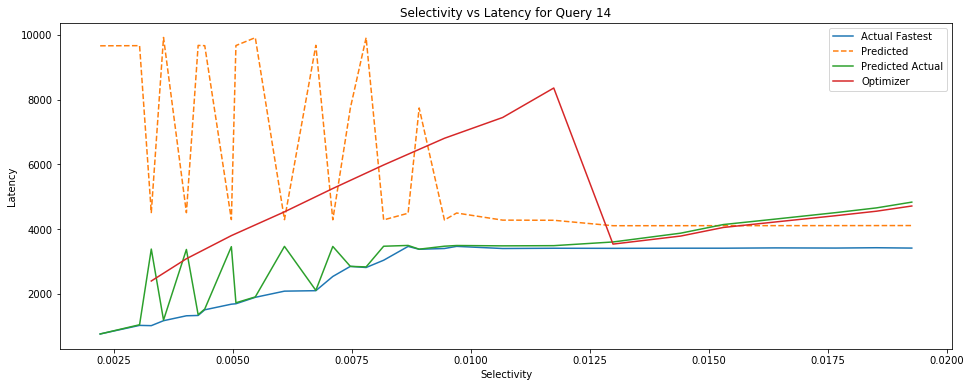

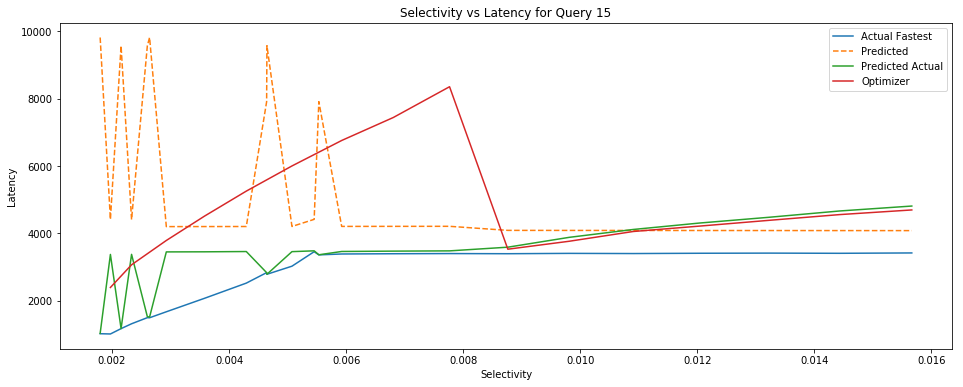

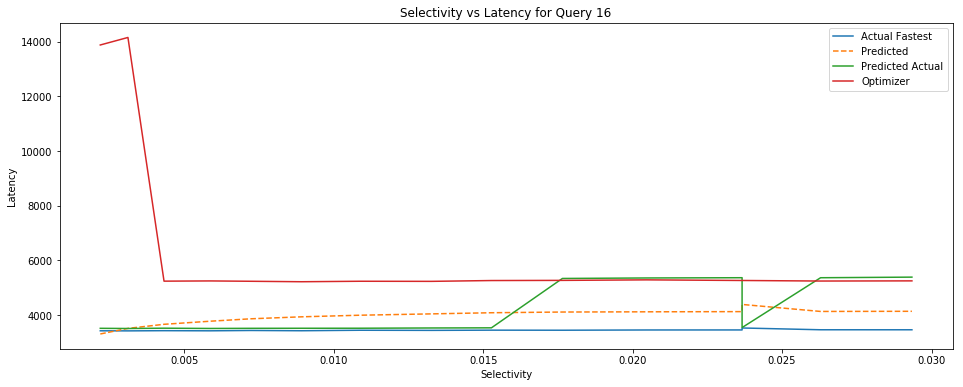

In [31]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

This network definitely will not work.

# Architecture 4
Architecture 2 with more epochs to see if we get better loss

In [32]:
model = get_model(128, 64, "relu", "relu")
hist = train_model(model, "ModelMLP-4.h5", X, Y, 200)

Train on 20263 samples, validate on 5066 samples
Epoch 1/200
20263/20263 [==============================] - 1s 37us/step - loss: 1425206949.0709 - mean_squared_error: 1425206949.0709 - mean_absolute_error: 16450.5351 - mean_absolute_percentage_error: 34884.5813 - cosine_proximity: -1.0000 - val_loss: 51171502.3877 - val_mean_squared_error: 51171502.3877 - val_mean_absolute_error: 6818.6826 - val_mean_absolute_percentage_error: 304.6132 - val_cosine_proximity: -1.0000
Epoch 2/200
20263/20263 [==============================] - 1s 30us/step - loss: 1161674185.0301 - mean_squared_error: 1161674185.0301 - mean_absolute_error: 17982.1454 - mean_absolute_percentage_error: 49296.2510 - cosine_proximity: -1.0000 - val_loss: 39854292.2325 - val_mean_squared_error: 39854292.2325 - val_mean_absolute_error: 4703.7898 - val_mean_absolute_percentage_error: 216.0476 - val_cosine_proximity: -1.0000
Epoch 3/200
20263/20263 [==============================] - 1s 29us/step - loss: 897942689.2713 - mean_squ

20263/20263 [==============================] - 1s 31us/step - loss: 184857603.0517 - mean_squared_error: 184857603.0517 - mean_absolute_error: 5713.7981 - mean_absolute_percentage_error: 29457.6080 - cosine_proximity: -1.0000 - val_loss: 2536614.3835 - val_mean_squared_error: 2536614.3835 - val_mean_absolute_error: 1337.8990 - val_mean_absolute_percentage_error: 60.7283 - val_cosine_proximity: -1.0000
Epoch 21/200
20263/20263 [==============================] - 1s 30us/step - loss: 180288870.7686 - mean_squared_error: 180288870.7686 - mean_absolute_error: 5646.3789 - mean_absolute_percentage_error: 29594.1002 - cosine_proximity: -1.0000 - val_loss: 2512501.7704 - val_mean_squared_error: 2512501.7704 - val_mean_absolute_error: 1322.9393 - val_mean_absolute_percentage_error: 59.6272 - val_cosine_proximity: -1.0000
Epoch 22/200
20263/20263 [==============================] - 1s 30us/step - loss: 175859059.3803 - mean_squared_error: 175859059.3803 - mean_absolute_error: 5568.3910 - mean_abso

Epoch 40/200
20263/20263 [==============================] - 1s 31us/step - loss: 123583526.7970 - mean_squared_error: 123583526.7970 - mean_absolute_error: 4608.2987 - mean_absolute_percentage_error: 27783.6345 - cosine_proximity: -1.0000 - val_loss: 2451104.8755 - val_mean_squared_error: 2451104.8755 - val_mean_absolute_error: 1253.5119 - val_mean_absolute_percentage_error: 57.7300 - val_cosine_proximity: -1.0000
Epoch 41/200
20263/20263 [==============================] - 1s 30us/step - loss: 121745624.1723 - mean_squared_error: 121745624.1723 - mean_absolute_error: 4575.8668 - mean_absolute_percentage_error: 27750.9191 - cosine_proximity: -1.0000 - val_loss: 2437731.8555 - val_mean_squared_error: 2437731.8555 - val_mean_absolute_error: 1248.4784 - val_mean_absolute_percentage_error: 57.6021 - val_cosine_proximity: -1.0000
Epoch 42/200
20263/20263 [==============================] - 1s 30us/step - loss: 120296955.9858 - mean_squared_error: 120296955.9858 - mean_absolute_error: 4528.695

Epoch 60/200
20263/20263 [==============================] - 1s 32us/step - loss: 102755226.9291 - mean_squared_error: 102755226.9291 - mean_absolute_error: 4156.1607 - mean_absolute_percentage_error: 27314.4414 - cosine_proximity: -1.0000 - val_loss: 2344490.1576 - val_mean_squared_error: 2344490.1576 - val_mean_absolute_error: 1213.9332 - val_mean_absolute_percentage_error: 57.5087 - val_cosine_proximity: -1.0000
Epoch 61/200
20263/20263 [==============================] - 1s 31us/step - loss: 101832993.7903 - mean_squared_error: 101832993.7903 - mean_absolute_error: 4137.3832 - mean_absolute_percentage_error: 27219.9271 - cosine_proximity: -1.0000 - val_loss: 2343680.6999 - val_mean_squared_error: 2343680.6999 - val_mean_absolute_error: 1216.6592 - val_mean_absolute_percentage_error: 57.8072 - val_cosine_proximity: -1.0000
Epoch 62/200
20263/20263 [==============================] - 1s 31us/step - loss: 99955870.1941 - mean_squared_error: 99955870.1941 - mean_absolute_error: 4119.5429 

Epoch 80/200
20263/20263 [==============================] - 1s 30us/step - loss: 81388649.7559 - mean_squared_error: 81388649.7559 - mean_absolute_error: 3782.2512 - mean_absolute_percentage_error: 26766.7774 - cosine_proximity: -1.0000 - val_loss: 2587158.5755 - val_mean_squared_error: 2587158.5755 - val_mean_absolute_error: 1320.0851 - val_mean_absolute_percentage_error: 64.0589 - val_cosine_proximity: -1.0000
Epoch 81/200
20263/20263 [==============================] - 1s 30us/step - loss: 79753403.4798 - mean_squared_error: 79753403.4798 - mean_absolute_error: 3753.8238 - mean_absolute_percentage_error: 26769.7266 - cosine_proximity: -1.0000 - val_loss: 2602811.1873 - val_mean_squared_error: 2602811.1873 - val_mean_absolute_error: 1328.3589 - val_mean_absolute_percentage_error: 63.9628 - val_cosine_proximity: -1.0000
Epoch 82/200
20263/20263 [==============================] - 1s 30us/step - loss: 79926633.1663 - mean_squared_error: 79926633.1663 - mean_absolute_error: 3744.5610 - me

Epoch 100/200
20263/20263 [==============================] - 1s 30us/step - loss: 67274404.2059 - mean_squared_error: 67274404.2059 - mean_absolute_error: 3514.9932 - mean_absolute_percentage_error: 26118.9155 - cosine_proximity: -1.0000 - val_loss: 2894227.6595 - val_mean_squared_error: 2894227.6595 - val_mean_absolute_error: 1415.3876 - val_mean_absolute_percentage_error: 68.4677 - val_cosine_proximity: -1.0000
Epoch 101/200
20263/20263 [==============================] - 1s 30us/step - loss: 67359937.3135 - mean_squared_error: 67359937.3135 - mean_absolute_error: 3519.4827 - mean_absolute_percentage_error: 26217.1289 - cosine_proximity: -1.0000 - val_loss: 2902220.7244 - val_mean_squared_error: 2902220.7244 - val_mean_absolute_error: 1418.7907 - val_mean_absolute_percentage_error: 68.5631 - val_cosine_proximity: -1.0000
Epoch 102/200
20263/20263 [==============================] - 1s 30us/step - loss: 67272538.0330 - mean_squared_error: 67272538.0330 - mean_absolute_error: 3513.4248 -

Epoch 120/200
20263/20263 [==============================] - 1s 30us/step - loss: 59732010.4223 - mean_squared_error: 59732010.4223 - mean_absolute_error: 3365.6115 - mean_absolute_percentage_error: 25610.7195 - cosine_proximity: -1.0000 - val_loss: 3019700.6372 - val_mean_squared_error: 3019700.6372 - val_mean_absolute_error: 1463.2232 - val_mean_absolute_percentage_error: 70.2234 - val_cosine_proximity: -1.0000
Epoch 121/200
20263/20263 [==============================] - 1s 30us/step - loss: 59764724.4476 - mean_squared_error: 59764724.4476 - mean_absolute_error: 3352.2941 - mean_absolute_percentage_error: 25568.1039 - cosine_proximity: -1.0000 - val_loss: 3030949.8666 - val_mean_squared_error: 3030949.8666 - val_mean_absolute_error: 1466.8024 - val_mean_absolute_percentage_error: 70.3489 - val_cosine_proximity: -1.0000
Epoch 122/200
20263/20263 [==============================] - 1s 30us/step - loss: 59743995.0823 - mean_squared_error: 59743995.0823 - mean_absolute_error: 3363.0528 -

Epoch 140/200
20263/20263 [==============================] - 1s 30us/step - loss: 53103891.1397 - mean_squared_error: 53103891.1397 - mean_absolute_error: 3207.0224 - mean_absolute_percentage_error: 24877.7417 - cosine_proximity: -1.0000 - val_loss: 3267677.1090 - val_mean_squared_error: 3267677.1090 - val_mean_absolute_error: 1515.4408 - val_mean_absolute_percentage_error: 70.4006 - val_cosine_proximity: -1.0000
Epoch 141/200
20263/20263 [==============================] - 1s 30us/step - loss: 53373766.3529 - mean_squared_error: 53373766.3529 - mean_absolute_error: 3207.6459 - mean_absolute_percentage_error: 24801.3972 - cosine_proximity: -1.0000 - val_loss: 3284904.6688 - val_mean_squared_error: 3284904.6688 - val_mean_absolute_error: 1517.2090 - val_mean_absolute_percentage_error: 71.0296 - val_cosine_proximity: -1.0000
Epoch 142/200
20263/20263 [==============================] - 1s 31us/step - loss: 53135670.1022 - mean_squared_error: 53135670.1022 - mean_absolute_error: 3219.8978 -

Epoch 160/200
20263/20263 [==============================] - 1s 31us/step - loss: 47607537.7153 - mean_squared_error: 47607537.7153 - mean_absolute_error: 3090.6680 - mean_absolute_percentage_error: 24479.9271 - cosine_proximity: -1.0000 - val_loss: 3493129.9913 - val_mean_squared_error: 3493129.9913 - val_mean_absolute_error: 1562.3243 - val_mean_absolute_percentage_error: 69.8782 - val_cosine_proximity: -0.8938
Epoch 161/200
20263/20263 [==============================] - 1s 32us/step - loss: 47320605.4953 - mean_squared_error: 47320605.4953 - mean_absolute_error: 3096.8545 - mean_absolute_percentage_error: 24292.0457 - cosine_proximity: -1.0000 - val_loss: 3469349.9643 - val_mean_squared_error: 3469349.9643 - val_mean_absolute_error: 1554.1239 - val_mean_absolute_percentage_error: 69.7889 - val_cosine_proximity: -0.8938
Epoch 162/200
20263/20263 [==============================] - 1s 30us/step - loss: 47664350.5443 - mean_squared_error: 47664350.5443 - mean_absolute_error: 3095.4367 -

Epoch 180/200
20263/20263 [==============================] - 1s 30us/step - loss: 42331551.2408 - mean_squared_error: 42331551.2408 - mean_absolute_error: 2981.4787 - mean_absolute_percentage_error: 23752.6755 - cosine_proximity: -1.0000 - val_loss: 3485284.2724 - val_mean_squared_error: 3485284.2724 - val_mean_absolute_error: 1546.7858 - val_mean_absolute_percentage_error: 69.2685 - val_cosine_proximity: -0.8938
Epoch 181/200
20263/20263 [==============================] - 1s 30us/step - loss: 41719321.8935 - mean_squared_error: 41719321.8935 - mean_absolute_error: 2967.0835 - mean_absolute_percentage_error: 23522.5186 - cosine_proximity: -1.0000 - val_loss: 3562141.2943 - val_mean_squared_error: 3562141.2943 - val_mean_absolute_error: 1572.1754 - val_mean_absolute_percentage_error: 69.5720 - val_cosine_proximity: -0.8022
Epoch 182/200
20263/20263 [==============================] - 1s 30us/step - loss: 41757279.9776 - mean_squared_error: 41757279.9776 - mean_absolute_error: 2973.4685 -

Epoch 200/200
20263/20263 [==============================] - 1s 30us/step - loss: 36452237.9078 - mean_squared_error: 36452237.9078 - mean_absolute_error: 2867.4919 - mean_absolute_percentage_error: 23168.2856 - cosine_proximity: -1.0000 - val_loss: 3241487.9854 - val_mean_squared_error: 3241487.9854 - val_mean_absolute_error: 1487.9764 - val_mean_absolute_percentage_error: 69.3549 - val_cosine_proximity: -1.0000
Evaluating Model
25329/25329 [==============================] - 0s 9us/step
[28482925.705252625, 28482925.705252625, 2540.7522079020173, 18391.657683634476, -0.9999999933733397]


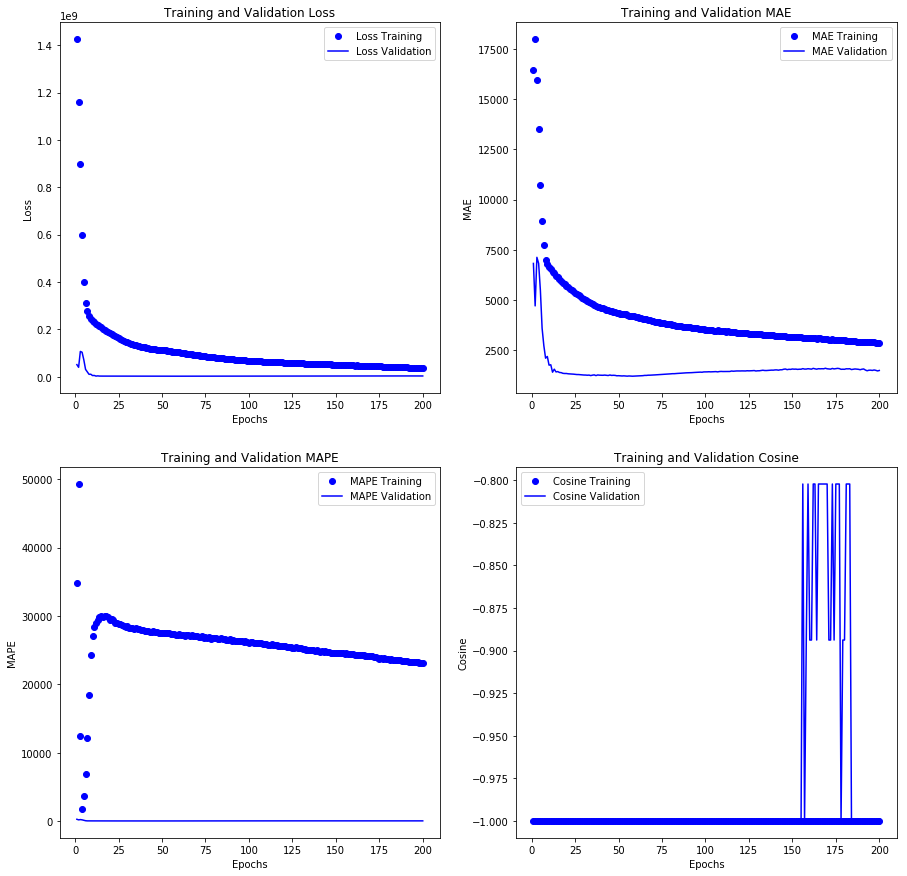

In [33]:
plot_hist(200, hist)

In [34]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

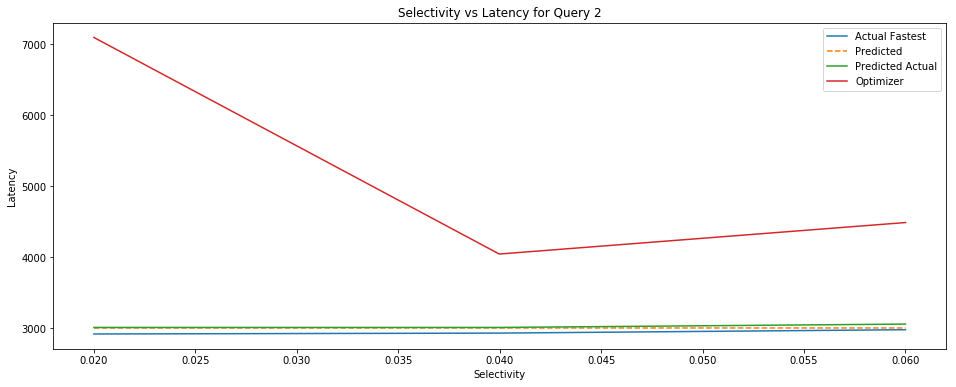

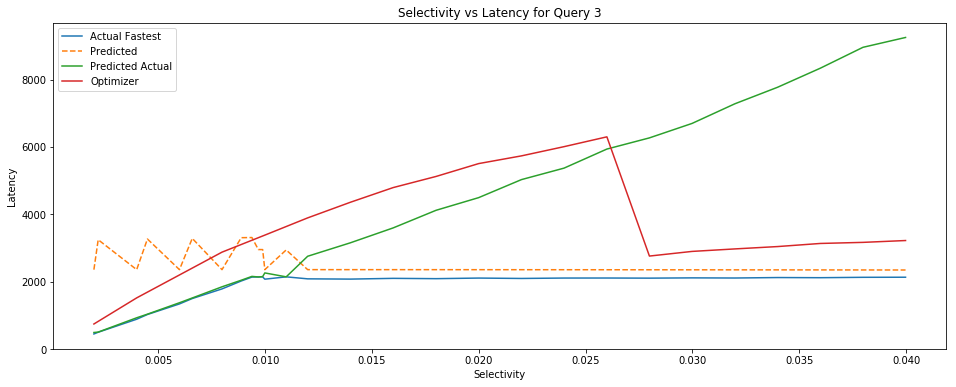

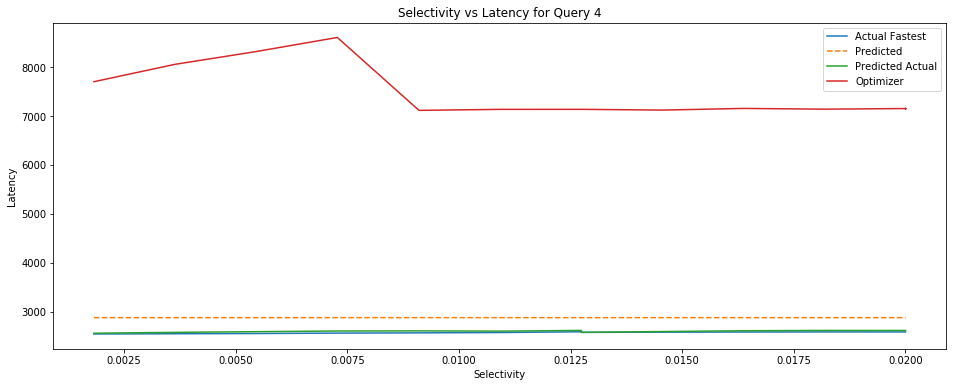

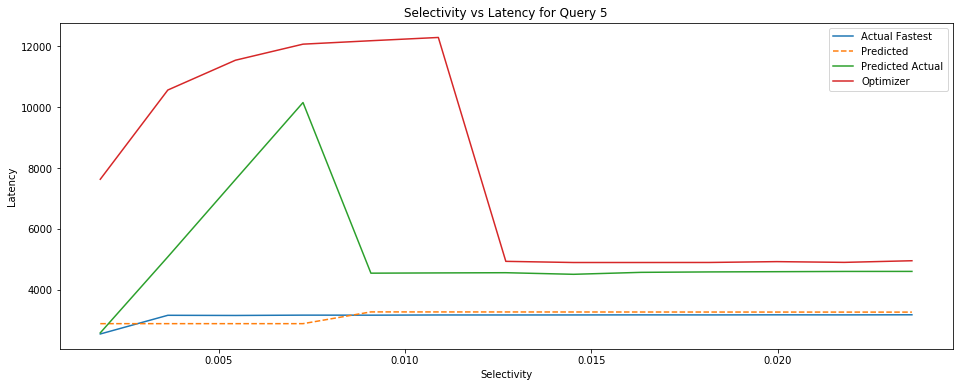

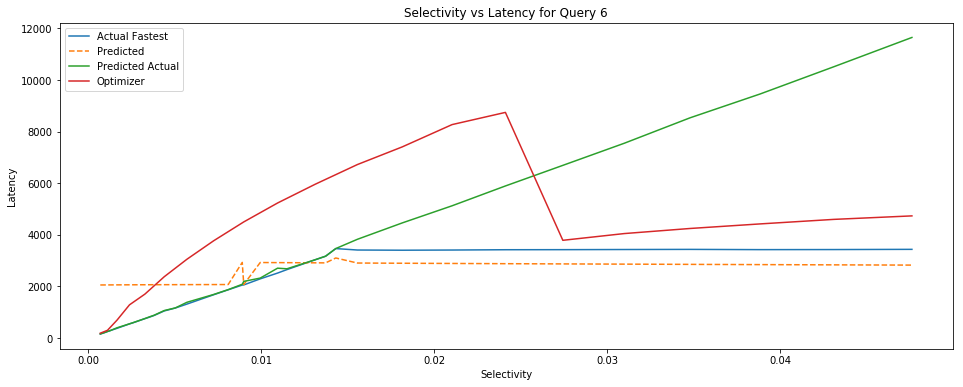

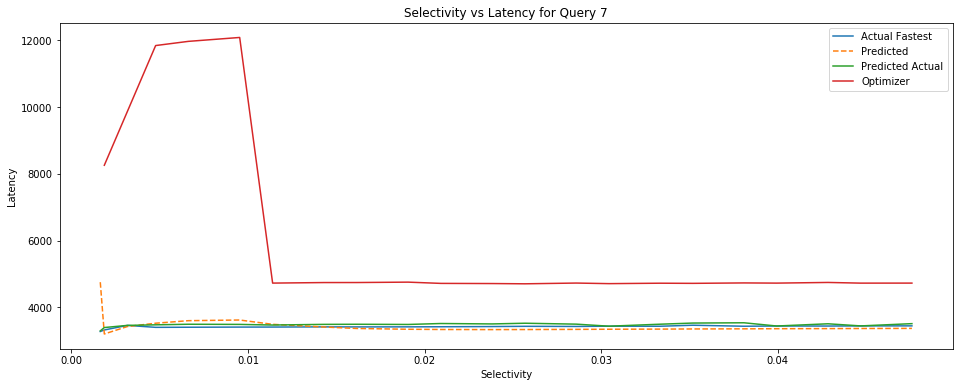

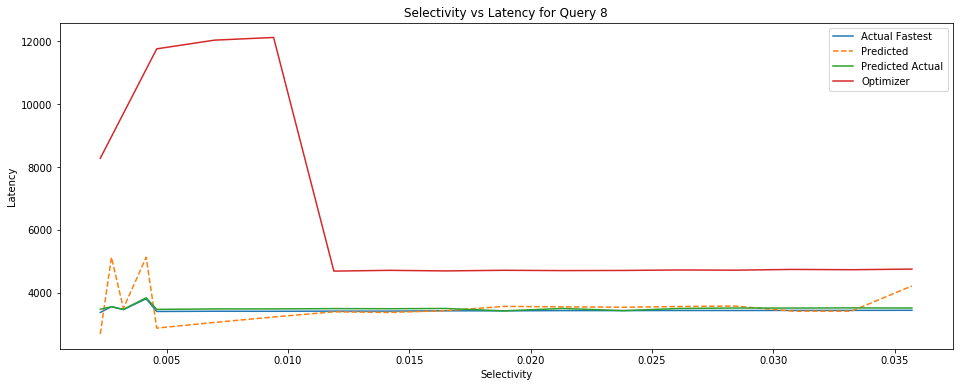

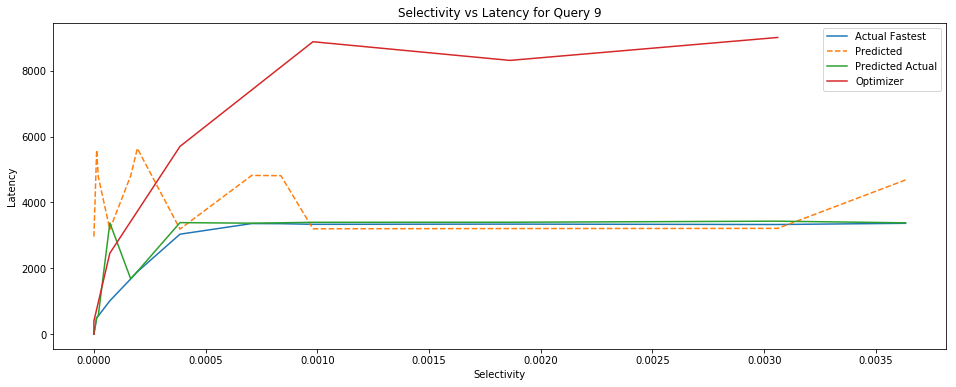

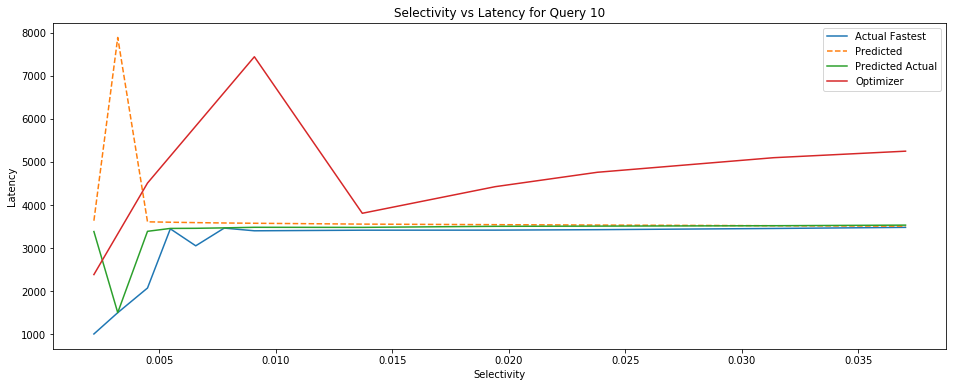

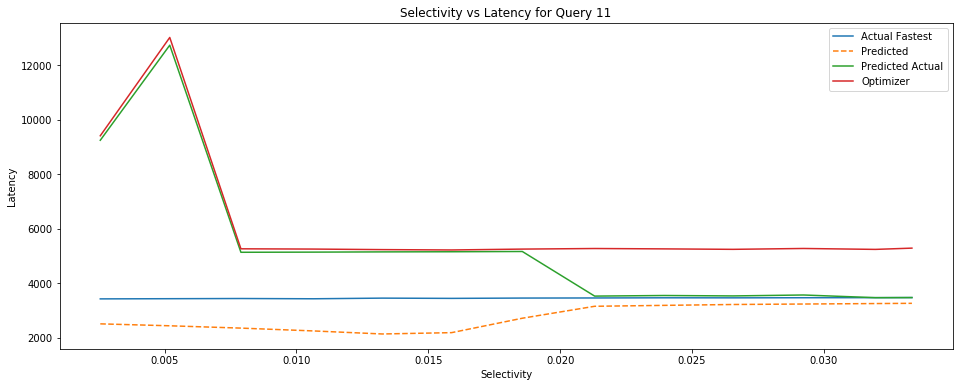

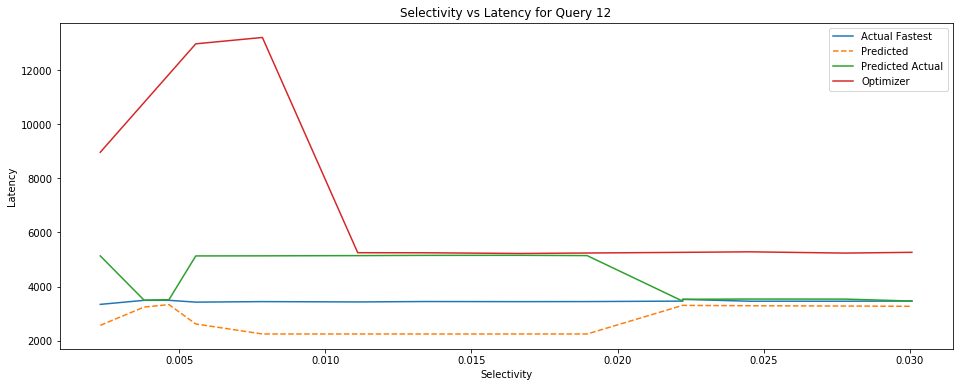

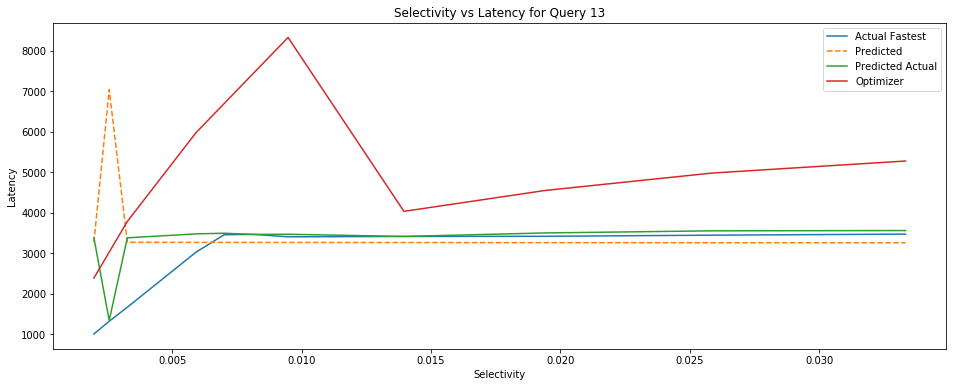

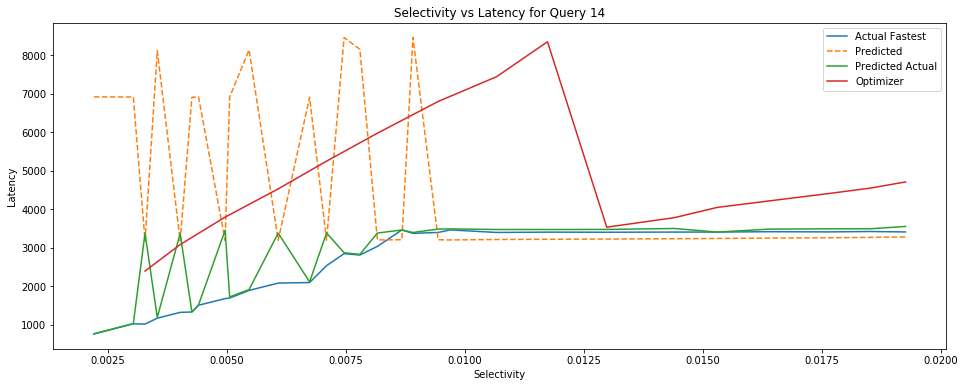

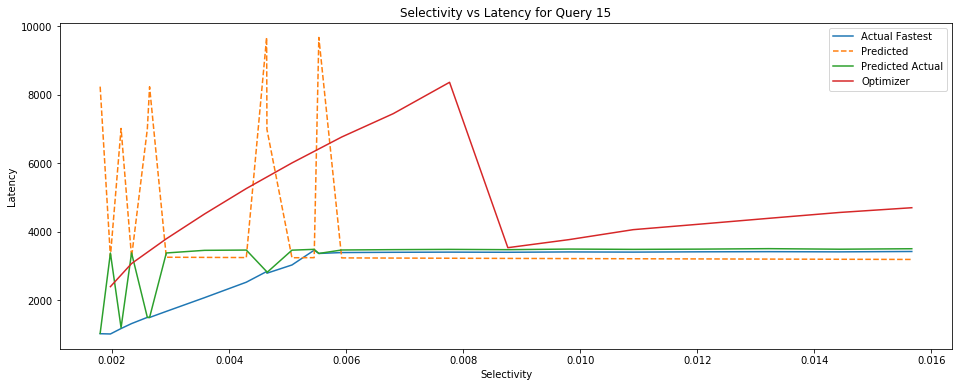

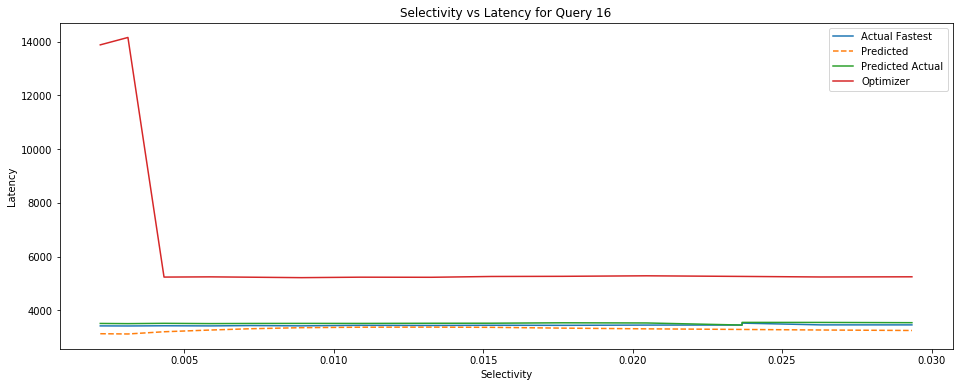

In [35]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

We do, but is it worth the extra time?

# Architecture 5
Less epochs of Architecure 2

In [36]:
model = get_model(128, 64, "relu", "relu")
hist = train_model(model, "ModelMLP-5.h5", X, Y, 50)


Train on 20263 samples, validate on 5066 samples
Epoch 1/50
20263/20263 [==============================] - 1s 36us/step - loss: 1418272195.6528 - mean_squared_error: 1418272195.6528 - mean_absolute_error: 16449.5248 - mean_absolute_percentage_error: 37187.5462 - cosine_proximity: -0.9991 - val_loss: 58288671.0430 - val_mean_squared_error: 58288671.0430 - val_mean_absolute_error: 7311.8810 - val_mean_absolute_percentage_error: 323.6269 - val_cosine_proximity: -1.0000
Epoch 2/50
20263/20263 [==============================] - 1s 28us/step - loss: 1158719896.2128 - mean_squared_error: 1158719896.2128 - mean_absolute_error: 18001.9466 - mean_absolute_percentage_error: 50471.5858 - cosine_proximity: -1.0000 - val_loss: 41711586.3193 - val_mean_squared_error: 41711586.3193 - val_mean_absolute_error: 4845.2667 - val_mean_absolute_percentage_error: 222.2586 - val_cosine_proximity: -1.0000
Epoch 3/50
20263/20263 [==============================] - 1s 28us/step - loss: 898146132.7294 - mean_square

20263/20263 [==============================] - 1s 30us/step - loss: 181994328.4448 - mean_squared_error: 181994328.4448 - mean_absolute_error: 5559.4744 - mean_absolute_percentage_error: 27657.7694 - cosine_proximity: -1.0000 - val_loss: 5230291.3924 - val_mean_squared_error: 5230291.3924 - val_mean_absolute_error: 2051.9773 - val_mean_absolute_percentage_error: 80.8463 - val_cosine_proximity: -1.0000
Epoch 21/50
20263/20263 [==============================] - 1s 30us/step - loss: 178066093.4718 - mean_squared_error: 178066093.4718 - mean_absolute_error: 5484.2820 - mean_absolute_percentage_error: 27369.5488 - cosine_proximity: -1.0000 - val_loss: 5080906.5626 - val_mean_squared_error: 5080906.5626 - val_mean_absolute_error: 2026.0667 - val_mean_absolute_percentage_error: 80.4963 - val_cosine_proximity: -1.0000
Epoch 22/50
20263/20263 [==============================] - 1s 29us/step - loss: 173186993.3941 - mean_squared_error: 173186993.3941 - mean_absolute_error: 5418.4517 - mean_absolu

Epoch 40/50
20263/20263 [==============================] - 1s 30us/step - loss: 122065798.5420 - mean_squared_error: 122065798.5420 - mean_absolute_error: 4519.2173 - mean_absolute_percentage_error: 24507.7774 - cosine_proximity: -1.0000 - val_loss: 3274035.2602 - val_mean_squared_error: 3274035.2602 - val_mean_absolute_error: 1488.9885 - val_mean_absolute_percentage_error: 60.6232 - val_cosine_proximity: -1.0000
Epoch 41/50
20263/20263 [==============================] - 1s 29us/step - loss: 120312083.9994 - mean_squared_error: 120312083.9994 - mean_absolute_error: 4481.6228 - mean_absolute_percentage_error: 24195.1232 - cosine_proximity: -1.0000 - val_loss: 3149522.6228 - val_mean_squared_error: 3149522.6228 - val_mean_absolute_error: 1446.4076 - val_mean_absolute_percentage_error: 59.8203 - val_cosine_proximity: -1.0000
Epoch 42/50
20263/20263 [==============================] - 1s 29us/step - loss: 119261307.1123 - mean_squared_error: 119261307.1123 - mean_absolute_error: 4450.8963 -

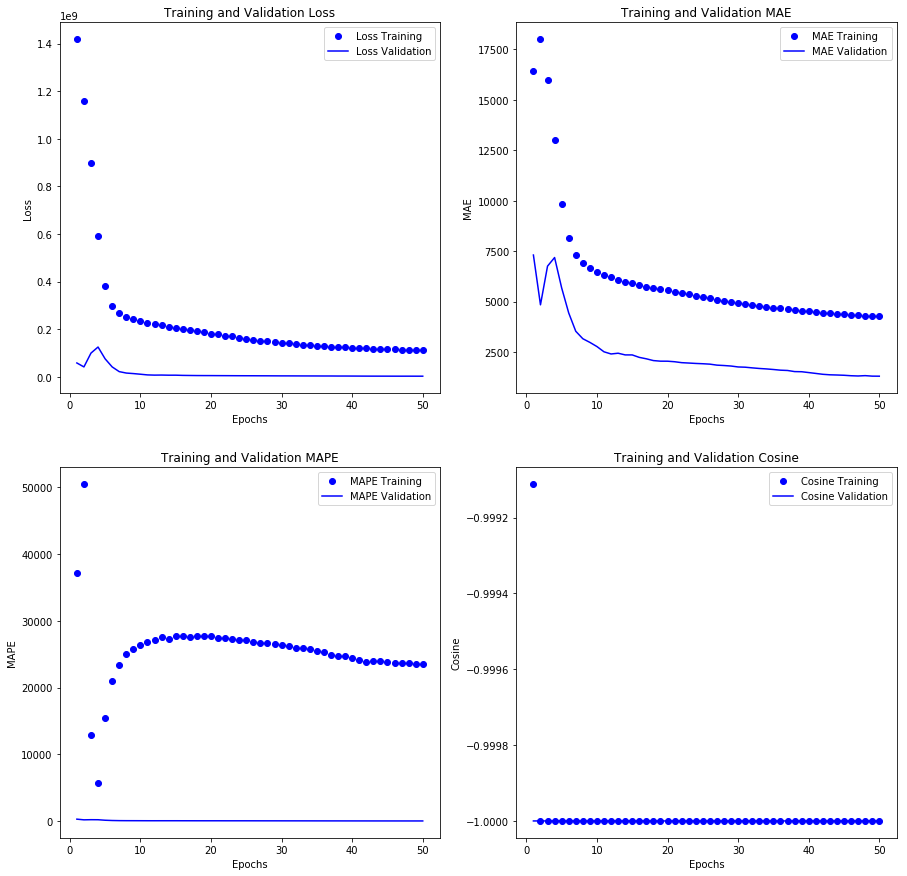

In [38]:
plot_hist(50, hist)

In [39]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

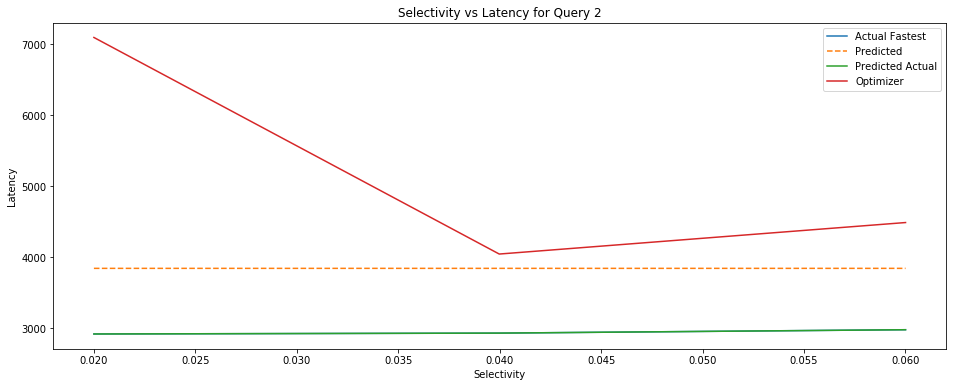

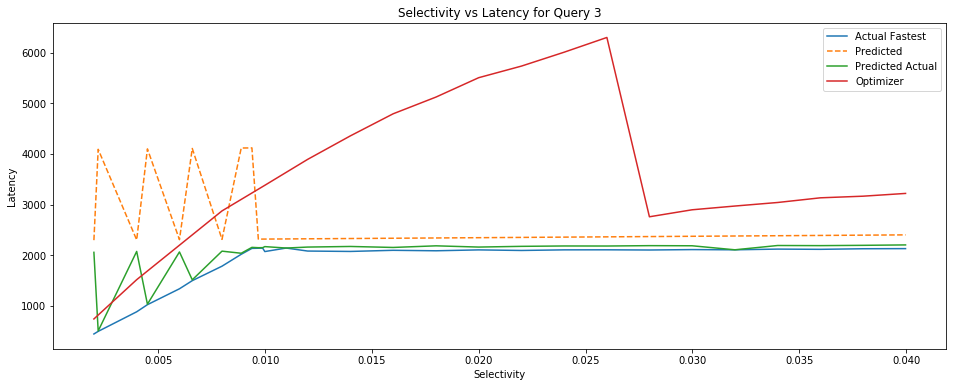

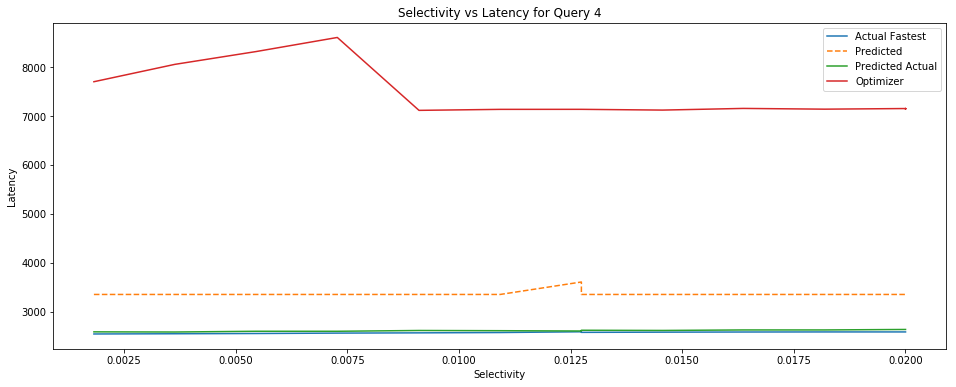

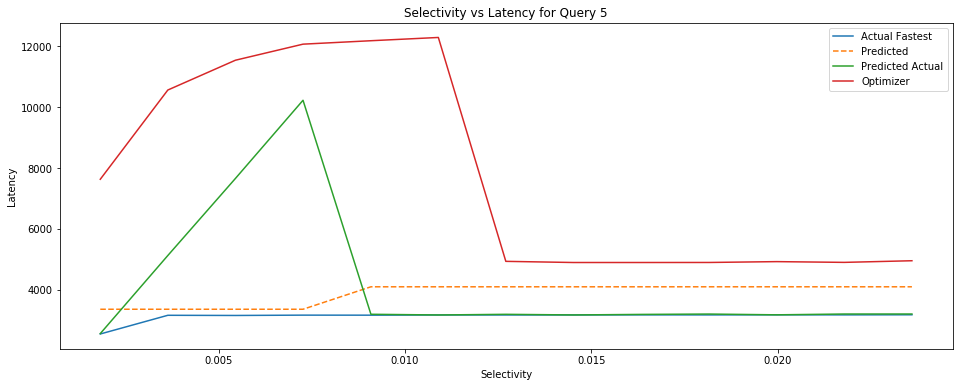

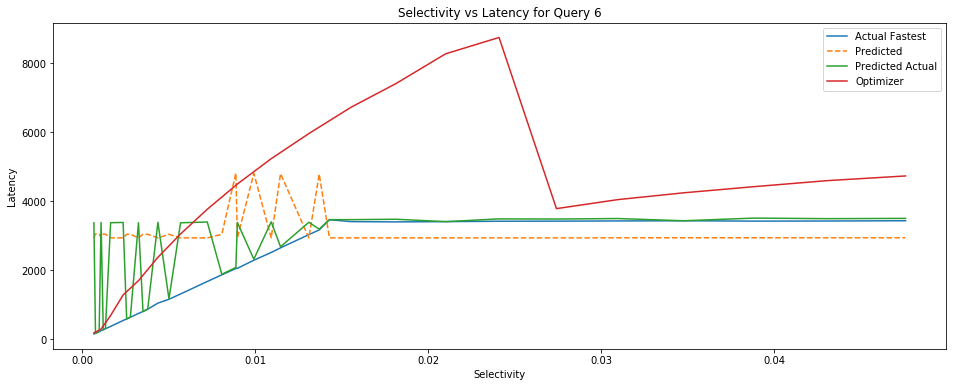

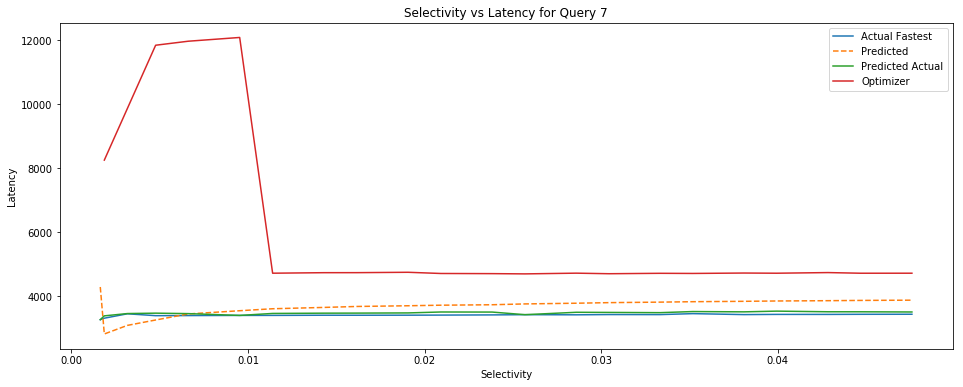

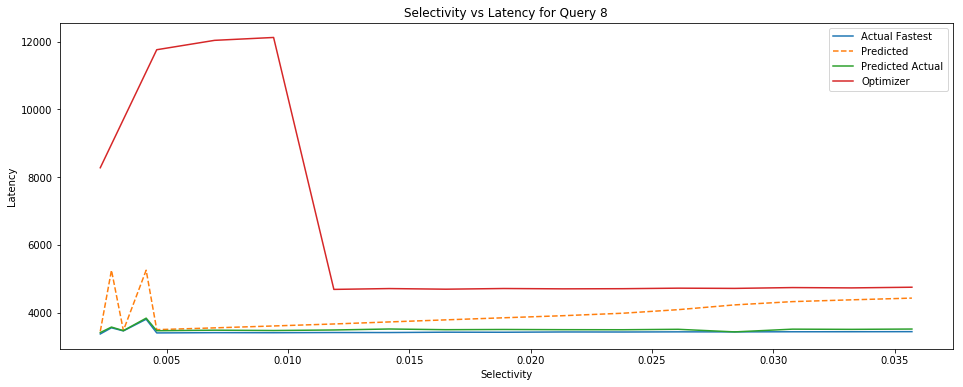

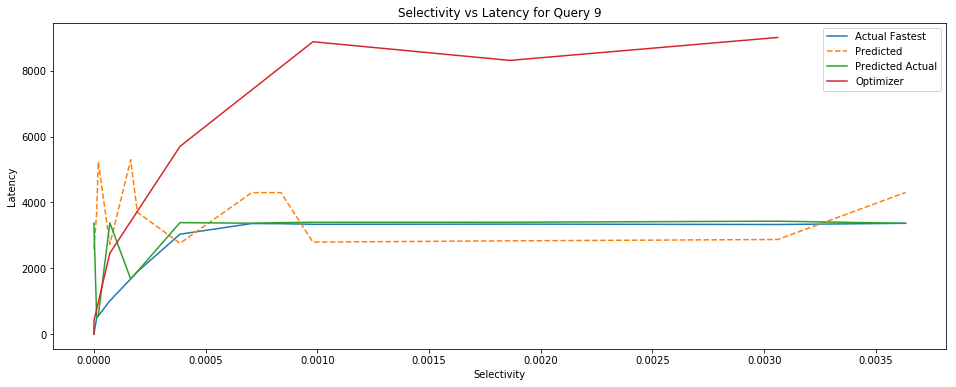

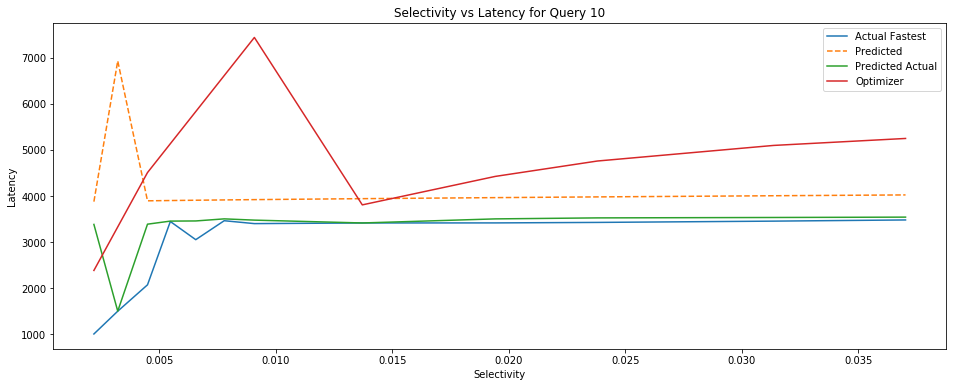

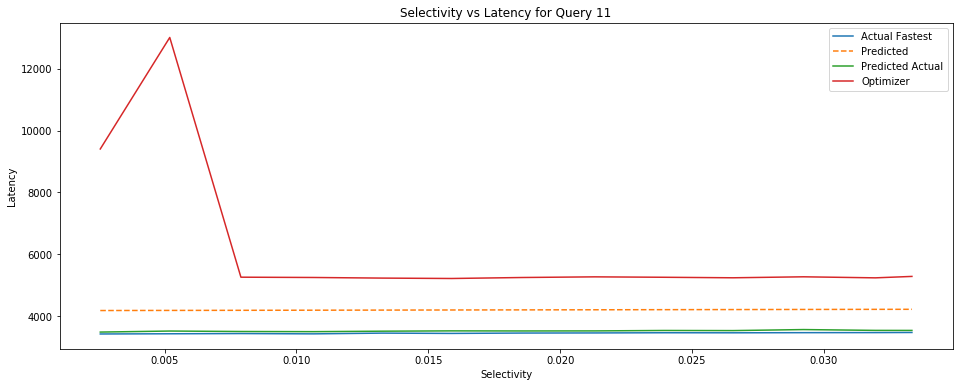

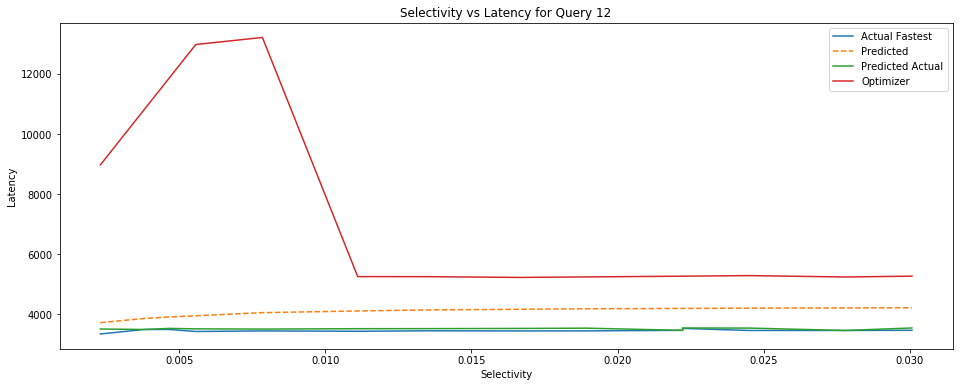

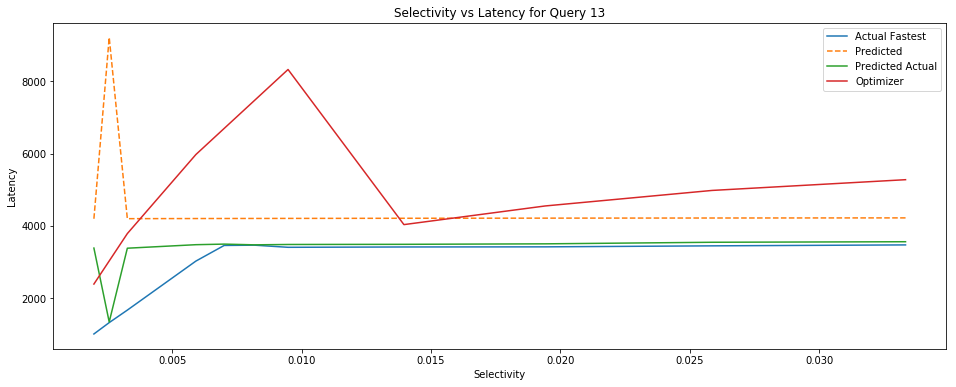

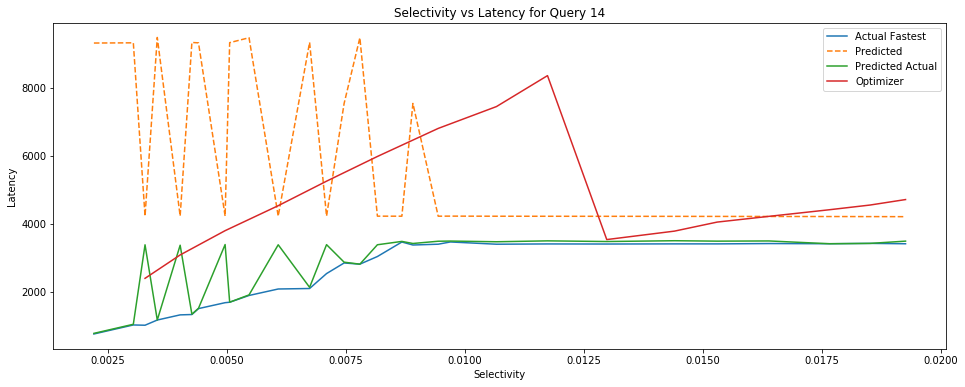

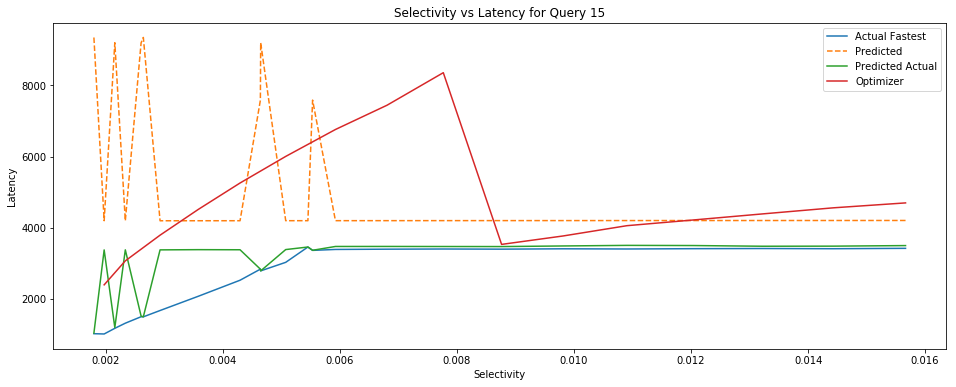

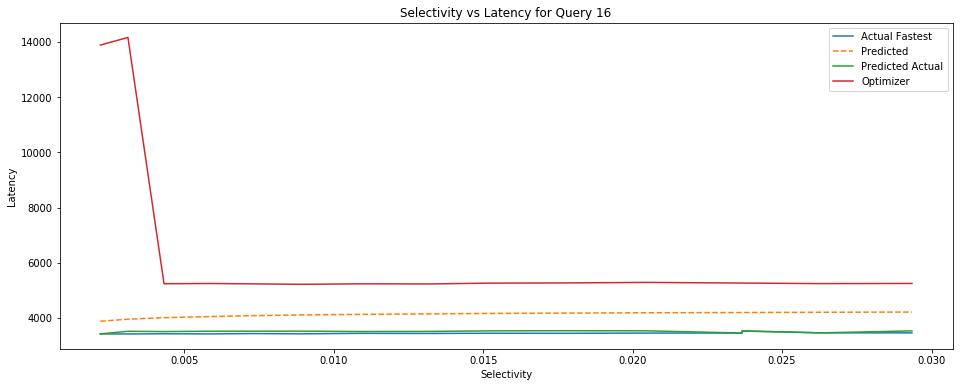

In [40]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

We definitely need more epochs.

# Architecture 6
3 layers with descending neurons (hoping to find the most important features)

In [41]:
keras.backend.clear_session()

model = Sequential()

model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, kernel_initializer='normal')) 

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

In [42]:
hist = train_model(model, "ModelMLP-6.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 42us/step - loss: 1334240257.5447 - mean_squared_error: 1334240257.5447 - mean_absolute_error: 17394.7690 - mean_absolute_percentage_error: 45654.8362 - cosine_proximity: -0.9921 - val_loss: 54877646.4732 - val_mean_squared_error: 54877646.4732 - val_mean_absolute_error: 6302.6589 - val_mean_absolute_percentage_error: 282.7529 - val_cosine_proximity: -1.0000
Epoch 2/100
20263/20263 [==============================] - 1s 32us/step - loss: 688327872.7691 - mean_squared_error: 688327872.7691 - mean_absolute_error: 13801.1368 - mean_absolute_percentage_error: 17230.0475 - cosine_proximity: -1.0000 - val_loss: 79761594.1902 - val_mean_squared_error: 79761594.1902 - val_mean_absolute_error: 5433.7568 - val_mean_absolute_percentage_error: 184.6239 - val_cosine_proximity: -1.0000
Epoch 3/100
20263/20263 [==============================] - 1s 32us/step - loss: 282192088.2744 - mean_squar

20263/20263 [==============================] - 1s 34us/step - loss: 113123108.5861 - mean_squared_error: 113123108.5861 - mean_absolute_error: 4289.3461 - mean_absolute_percentage_error: 23367.6799 - cosine_proximity: -1.0000 - val_loss: 2478019.9553 - val_mean_squared_error: 2478019.9553 - val_mean_absolute_error: 1217.3248 - val_mean_absolute_percentage_error: 48.9575 - val_cosine_proximity: -1.0000
Epoch 21/100
20263/20263 [==============================] - 1s 34us/step - loss: 110949584.0038 - mean_squared_error: 110949584.0038 - mean_absolute_error: 4226.9992 - mean_absolute_percentage_error: 23180.4056 - cosine_proximity: -1.0000 - val_loss: 2478867.4744 - val_mean_squared_error: 2478867.4744 - val_mean_absolute_error: 1233.2891 - val_mean_absolute_percentage_error: 49.9904 - val_cosine_proximity: -1.0000
Epoch 22/100
20263/20263 [==============================] - 1s 34us/step - loss: 109233951.0461 - mean_squared_error: 109233951.0461 - mean_absolute_error: 4217.3439 - mean_abso

Epoch 40/100
20263/20263 [==============================] - 1s 34us/step - loss: 68851705.5979 - mean_squared_error: 68851705.5979 - mean_absolute_error: 3501.6215 - mean_absolute_percentage_error: 19705.3465 - cosine_proximity: -1.0000 - val_loss: 2062359.2185 - val_mean_squared_error: 2062359.2185 - val_mean_absolute_error: 1128.8394 - val_mean_absolute_percentage_error: 49.6501 - val_cosine_proximity: -1.0000
Epoch 41/100
20263/20263 [==============================] - 1s 34us/step - loss: 67271896.1298 - mean_squared_error: 67271896.1298 - mean_absolute_error: 3467.3111 - mean_absolute_percentage_error: 19732.8972 - cosine_proximity: -1.0000 - val_loss: 2165393.8730 - val_mean_squared_error: 2165393.8730 - val_mean_absolute_error: 1170.5071 - val_mean_absolute_percentage_error: 49.9801 - val_cosine_proximity: -1.0000
Epoch 42/100
20263/20263 [==============================] - 1s 34us/step - loss: 66177316.6447 - mean_squared_error: 66177316.6447 - mean_absolute_error: 3456.2655 - me

Epoch 60/100
20263/20263 [==============================] - 1s 35us/step - loss: 52637118.9009 - mean_squared_error: 52637118.9009 - mean_absolute_error: 3157.7715 - mean_absolute_percentage_error: 17174.1174 - cosine_proximity: -1.0000 - val_loss: 2190787.7279 - val_mean_squared_error: 2190787.7279 - val_mean_absolute_error: 1160.2367 - val_mean_absolute_percentage_error: 55.8057 - val_cosine_proximity: -1.0000
Epoch 61/100
20263/20263 [==============================] - 1s 35us/step - loss: 51417803.3354 - mean_squared_error: 51417803.3354 - mean_absolute_error: 3130.6395 - mean_absolute_percentage_error: 17002.3579 - cosine_proximity: -1.0000 - val_loss: 2223782.1970 - val_mean_squared_error: 2223782.1970 - val_mean_absolute_error: 1140.5807 - val_mean_absolute_percentage_error: 56.3098 - val_cosine_proximity: -1.0000
Epoch 62/100
20263/20263 [==============================] - 1s 36us/step - loss: 50949104.5995 - mean_squared_error: 50949104.5995 - mean_absolute_error: 3126.6125 - me

Epoch 80/100
20263/20263 [==============================] - 1s 36us/step - loss: 40865269.5151 - mean_squared_error: 40865269.5151 - mean_absolute_error: 2942.0324 - mean_absolute_percentage_error: 14817.1217 - cosine_proximity: -1.0000 - val_loss: 2672400.2278 - val_mean_squared_error: 2672400.2278 - val_mean_absolute_error: 1203.4976 - val_mean_absolute_percentage_error: 58.6862 - val_cosine_proximity: -1.0000
Epoch 81/100
20263/20263 [==============================] - 1s 35us/step - loss: 40398013.7174 - mean_squared_error: 40398013.7174 - mean_absolute_error: 2934.0347 - mean_absolute_percentage_error: 14699.8537 - cosine_proximity: -1.0000 - val_loss: 2848784.0135 - val_mean_squared_error: 2848784.0135 - val_mean_absolute_error: 1206.4688 - val_mean_absolute_percentage_error: 59.1641 - val_cosine_proximity: -1.0000
Epoch 82/100
20263/20263 [==============================] - 1s 35us/step - loss: 39979439.3398 - mean_squared_error: 39979439.3398 - mean_absolute_error: 2896.0504 - me

Epoch 100/100
20263/20263 [==============================] - 1s 36us/step - loss: 27242894.6407 - mean_squared_error: 27242894.6407 - mean_absolute_error: 2612.2398 - mean_absolute_percentage_error: 12434.5161 - cosine_proximity: -1.0000 - val_loss: 3578477.2353 - val_mean_squared_error: 3578477.2353 - val_mean_absolute_error: 1272.2959 - val_mean_absolute_percentage_error: 63.0180 - val_cosine_proximity: -1.0000
Evaluating Model
25329/25329 [==============================] - 0s 10us/step
[19497933.193630572, 19497933.193630572, 2258.235592233165, 9279.923823092504, -0.9999999906624332]


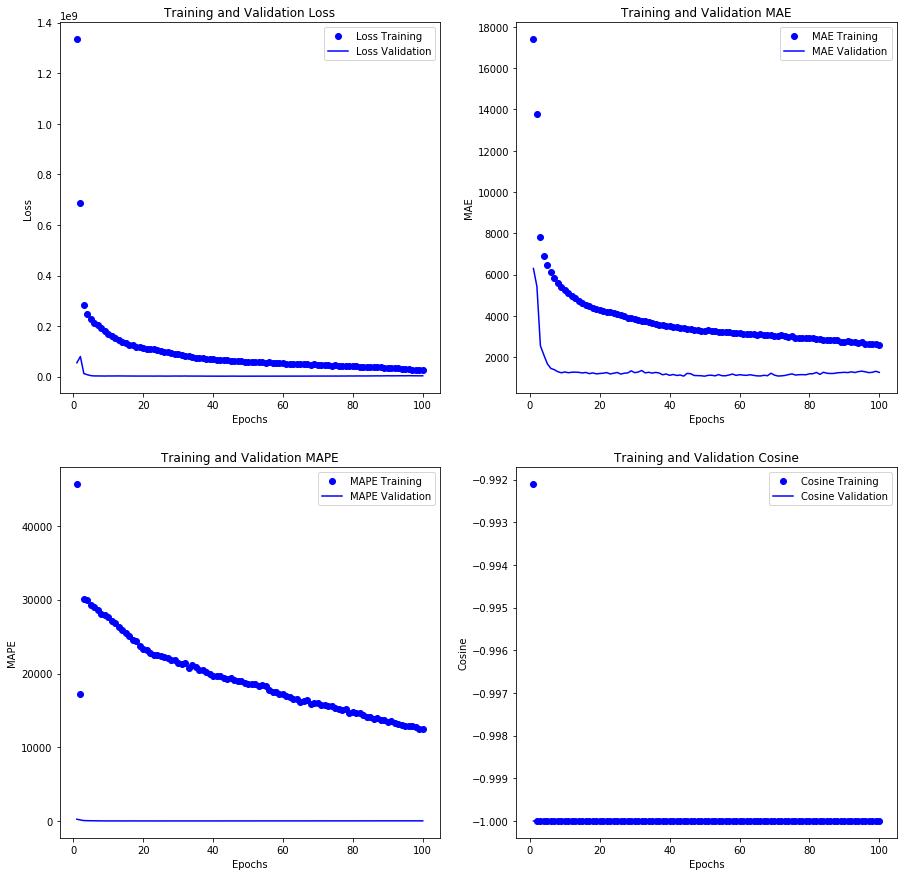

In [43]:
plot_hist(100, hist)

In [44]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

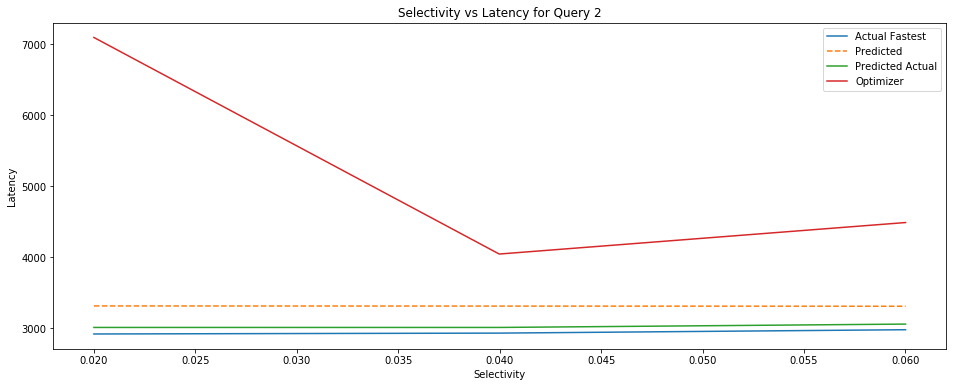

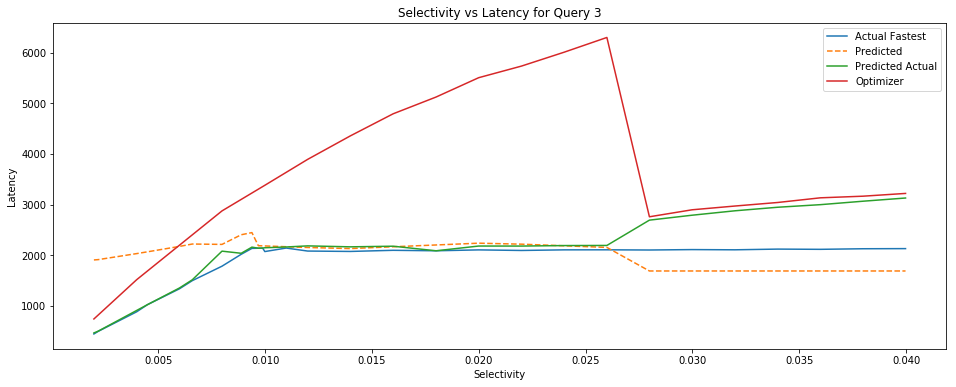

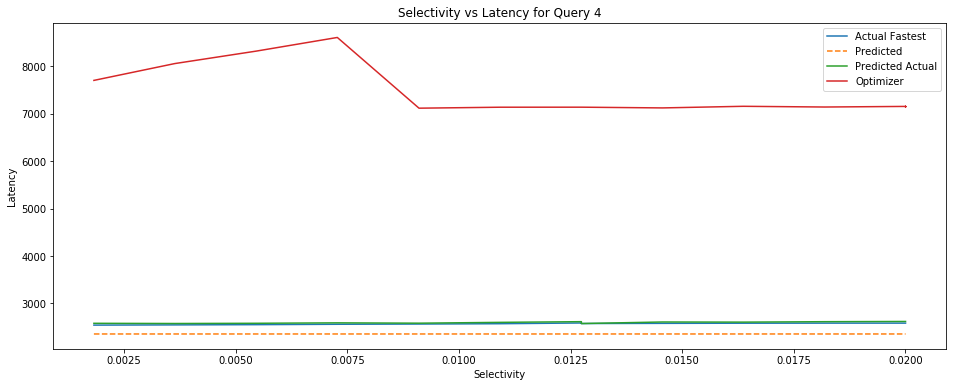

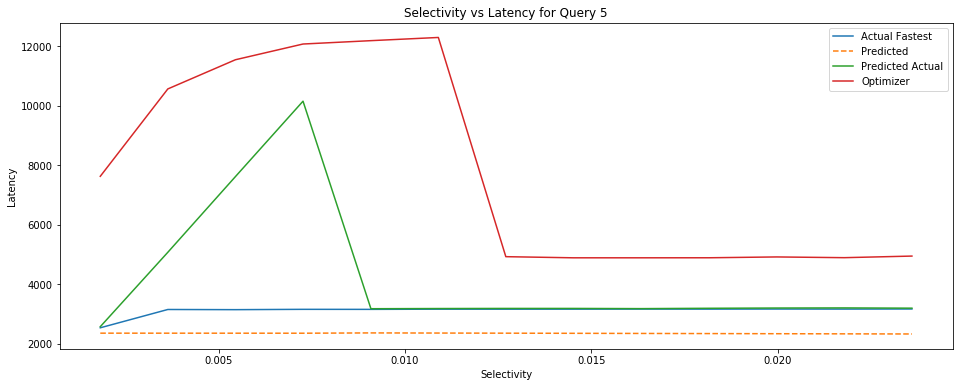

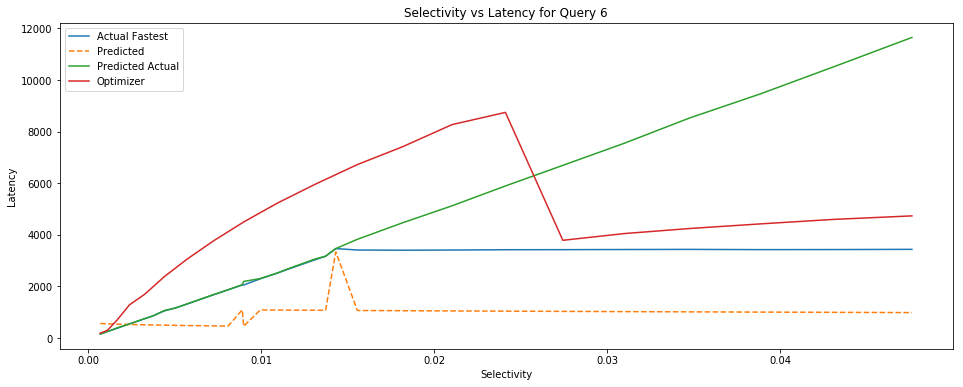

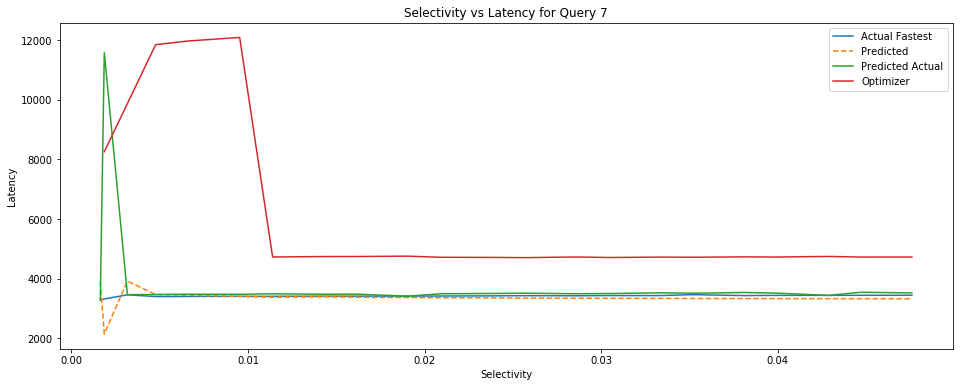

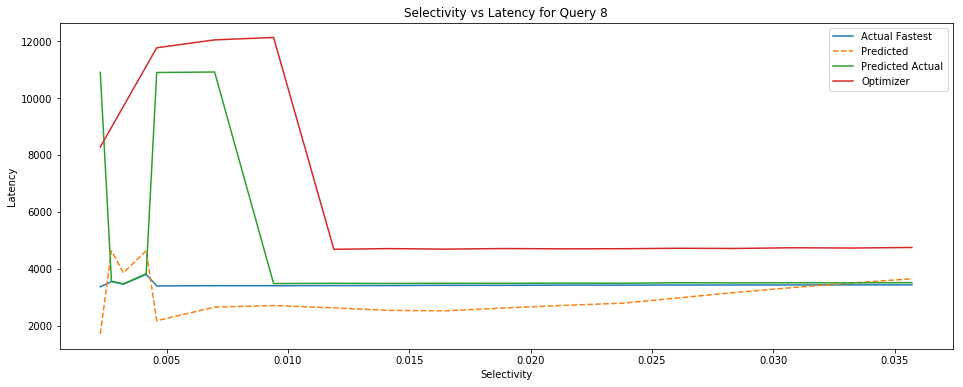

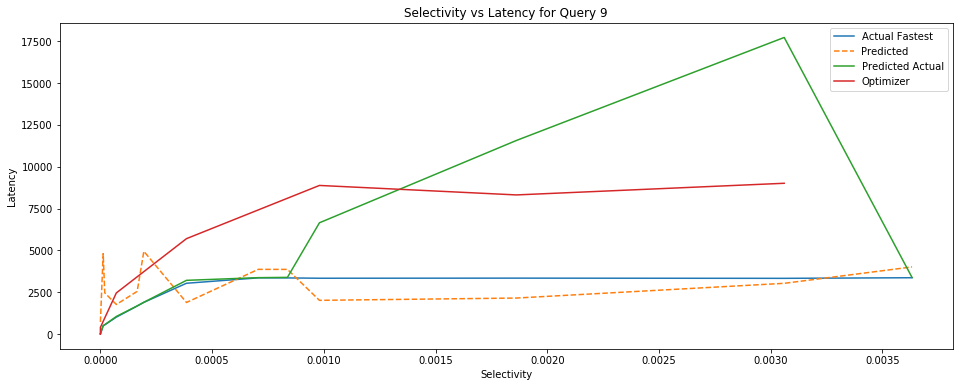

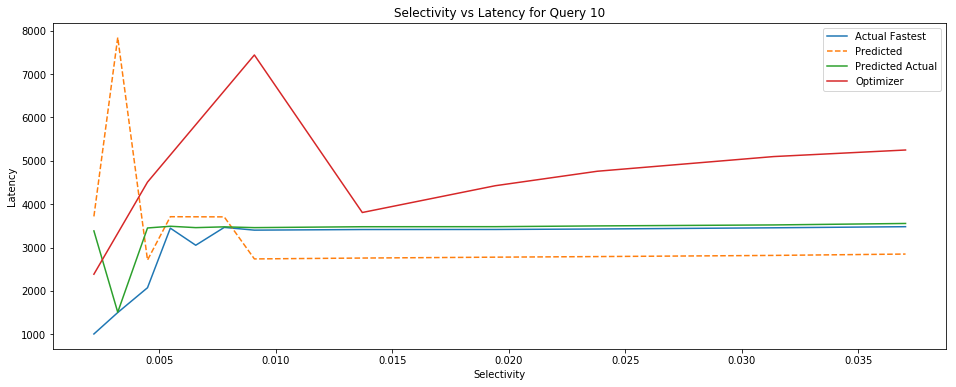

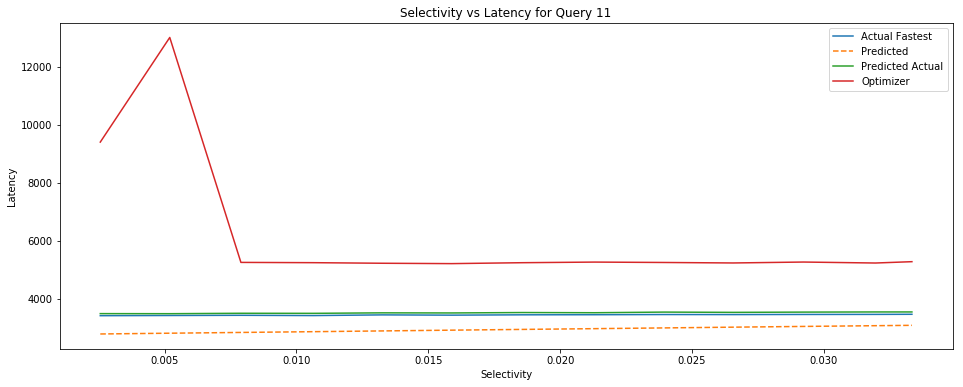

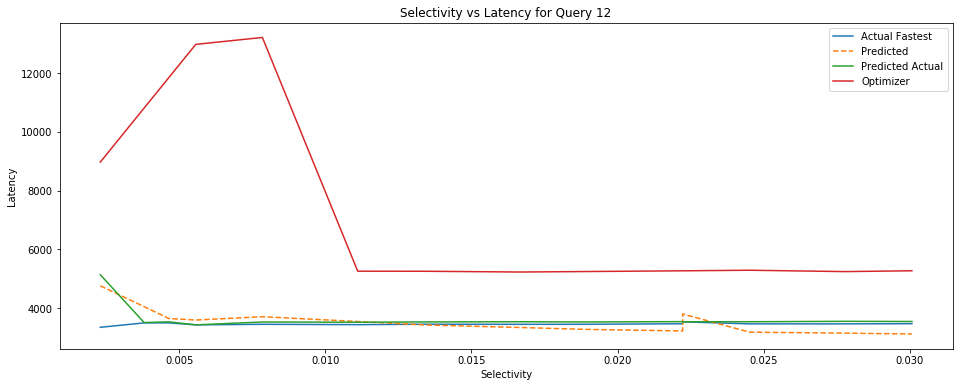

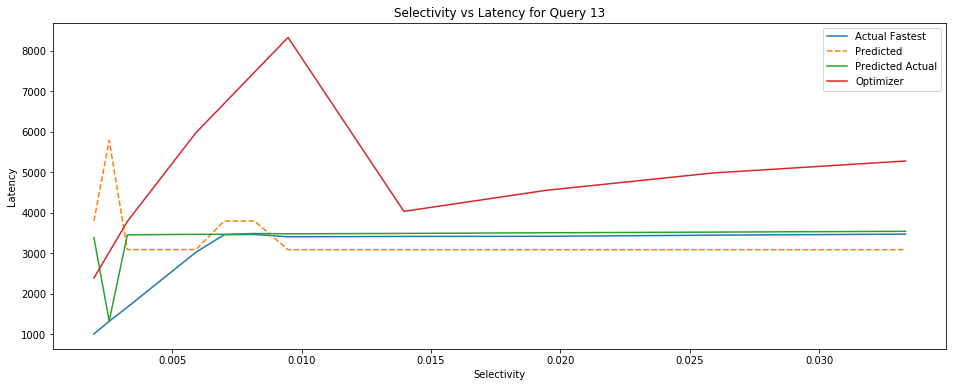

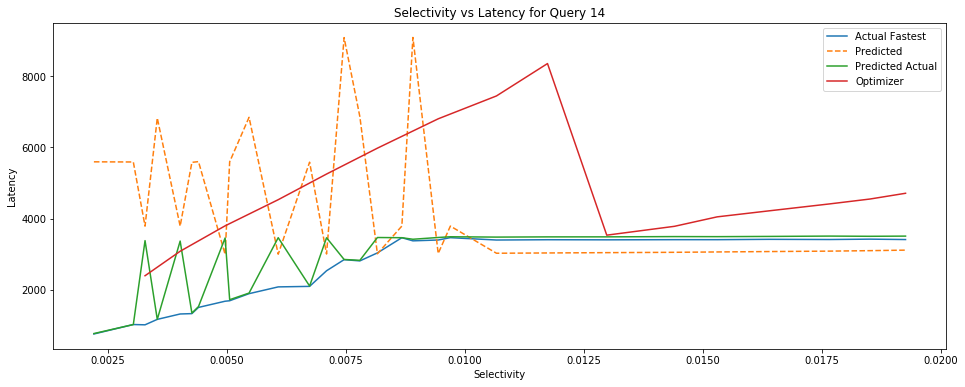

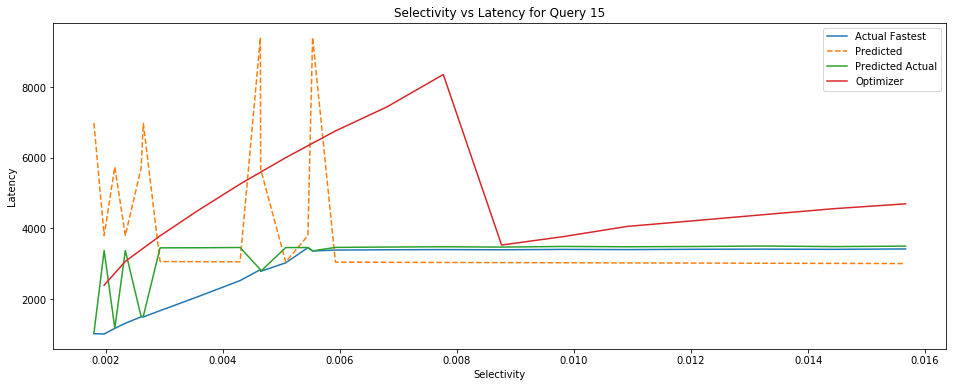

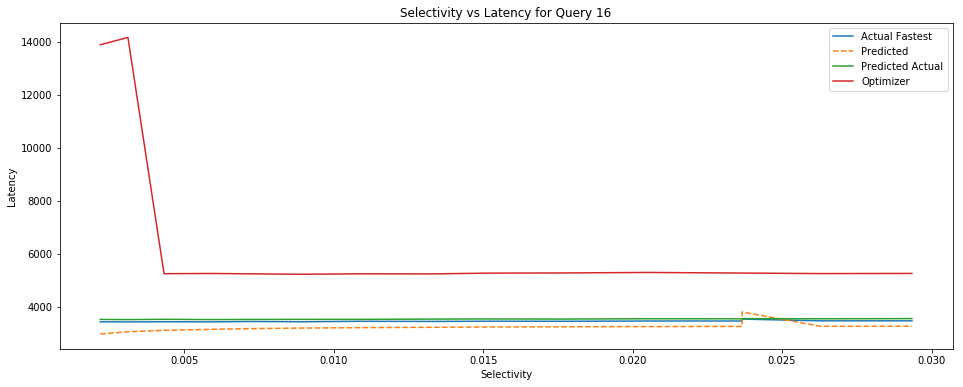

In [45]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

It performed admirably. It seems it's better to add layers than epochs.

# Architecture 7
Here, rather than make the neurons descend, we'll use an encoder/decoder style by decreasing the neurons, then increasing them.

In [46]:
keras.backend.clear_session()

model = Sequential()

model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

In [47]:
hist = train_model(model, "ModelMLP-7.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 42us/step - loss: 1173869758.7398 - mean_squared_error: 1173869758.7398 - mean_absolute_error: 16871.7518 - mean_absolute_percentage_error: 35901.6687 - cosine_proximity: -0.9970 - val_loss: 148465926.4540 - val_mean_squared_error: 148465926.4540 - val_mean_absolute_error: 7803.3031 - val_mean_absolute_percentage_error: 275.4186 - val_cosine_proximity: -1.0000
Epoch 2/100
20263/20263 [==============================] - 1s 33us/step - loss: 323147065.3231 - mean_squared_error: 323147065.3231 - mean_absolute_error: 8494.0860 - mean_absolute_percentage_error: 20667.0800 - cosine_proximity: -1.0000 - val_loss: 17077929.8041 - val_mean_squared_error: 17077929.8041 - val_mean_absolute_error: 2765.0695 - val_mean_absolute_percentage_error: 95.0835 - val_cosine_proximity: -1.0000
Epoch 3/100
20263/20263 [==============================] - 1s 34us/step - loss: 239187018.3655 - mean_squar

20263/20263 [==============================] - 1s 34us/step - loss: 84470710.9101 - mean_squared_error: 84470710.9101 - mean_absolute_error: 3787.4239 - mean_absolute_percentage_error: 23705.9533 - cosine_proximity: -1.0000 - val_loss: 2976545.6832 - val_mean_squared_error: 2976545.6832 - val_mean_absolute_error: 1446.3427 - val_mean_absolute_percentage_error: 56.3845 - val_cosine_proximity: -1.0000
Epoch 21/100
20263/20263 [==============================] - 1s 34us/step - loss: 81593632.5022 - mean_squared_error: 81593632.5022 - mean_absolute_error: 3700.4928 - mean_absolute_percentage_error: 23007.8747 - cosine_proximity: -1.0000 - val_loss: 3031982.2783 - val_mean_squared_error: 3031982.2783 - val_mean_absolute_error: 1464.9333 - val_mean_absolute_percentage_error: 58.1214 - val_cosine_proximity: -1.0000
Epoch 22/100
20263/20263 [==============================] - 1s 34us/step - loss: 78907768.2757 - mean_squared_error: 78907768.2757 - mean_absolute_error: 3665.4648 - mean_absolute_p

Epoch 40/100
20263/20263 [==============================] - 1s 35us/step - loss: 56118694.4058 - mean_squared_error: 56118694.4058 - mean_absolute_error: 3163.5443 - mean_absolute_percentage_error: 17835.0842 - cosine_proximity: -1.0000 - val_loss: 3414889.5904 - val_mean_squared_error: 3414889.5904 - val_mean_absolute_error: 1478.7579 - val_mean_absolute_percentage_error: 46.5236 - val_cosine_proximity: -1.0000
Epoch 41/100
20263/20263 [==============================] - 1s 34us/step - loss: 56416977.4426 - mean_squared_error: 56416977.4426 - mean_absolute_error: 3154.7036 - mean_absolute_percentage_error: 18054.7235 - cosine_proximity: -1.0000 - val_loss: 3092818.0059 - val_mean_squared_error: 3092818.0059 - val_mean_absolute_error: 1387.5456 - val_mean_absolute_percentage_error: 45.5698 - val_cosine_proximity: -1.0000
Epoch 42/100
20263/20263 [==============================] - 1s 35us/step - loss: 55419102.3736 - mean_squared_error: 55419102.3736 - mean_absolute_error: 3149.0382 - me

Epoch 60/100
20263/20263 [==============================] - 1s 35us/step - loss: 40025613.7064 - mean_squared_error: 40025613.7064 - mean_absolute_error: 2871.9045 - mean_absolute_percentage_error: 14239.8886 - cosine_proximity: -1.0000 - val_loss: 2894321.2631 - val_mean_squared_error: 2894321.2631 - val_mean_absolute_error: 1357.3061 - val_mean_absolute_percentage_error: 45.8224 - val_cosine_proximity: -1.0000
Epoch 61/100
20263/20263 [==============================] - 1s 35us/step - loss: 39370056.8822 - mean_squared_error: 39370056.8822 - mean_absolute_error: 2838.0250 - mean_absolute_percentage_error: 14393.7686 - cosine_proximity: -1.0000 - val_loss: 2972169.5035 - val_mean_squared_error: 2972169.5035 - val_mean_absolute_error: 1406.3026 - val_mean_absolute_percentage_error: 46.9480 - val_cosine_proximity: -1.0000
Epoch 62/100
20263/20263 [==============================] - 1s 35us/step - loss: 37696780.1179 - mean_squared_error: 37696780.1179 - mean_absolute_error: 2798.6062 - me

Epoch 80/100
20263/20263 [==============================] - 1s 35us/step - loss: 26619052.4452 - mean_squared_error: 26619052.4452 - mean_absolute_error: 2635.5088 - mean_absolute_percentage_error: 12928.0051 - cosine_proximity: -1.0000 - val_loss: 4036752.0434 - val_mean_squared_error: 4036752.0434 - val_mean_absolute_error: 1571.8254 - val_mean_absolute_percentage_error: 46.4948 - val_cosine_proximity: -1.0000
Epoch 81/100
20263/20263 [==============================] - 1s 35us/step - loss: 25893891.7084 - mean_squared_error: 25893891.7084 - mean_absolute_error: 2590.2142 - mean_absolute_percentage_error: 12653.1544 - cosine_proximity: -1.0000 - val_loss: 4599484.1605 - val_mean_squared_error: 4599484.1605 - val_mean_absolute_error: 1767.8521 - val_mean_absolute_percentage_error: 52.6444 - val_cosine_proximity: -0.9901
Epoch 82/100
20263/20263 [==============================] - 1s 35us/step - loss: 27913876.6485 - mean_squared_error: 27913876.6485 - mean_absolute_error: 2701.3515 - me

Epoch 100/100
20263/20263 [==============================] - 1s 35us/step - loss: 23549593.6781 - mean_squared_error: 23549593.6781 - mean_absolute_error: 2518.3436 - mean_absolute_percentage_error: 12322.6722 - cosine_proximity: -1.0000 - val_loss: 3482468.8906 - val_mean_squared_error: 3482468.8906 - val_mean_absolute_error: 1427.5684 - val_mean_absolute_percentage_error: 43.9199 - val_cosine_proximity: -1.0000
Evaluating Model
25329/25329 [==============================] - 0s 10us/step
[19188204.11676833, 19188204.11676833, 2296.2502444297884, 9081.525153063294, -0.9999999881021325]


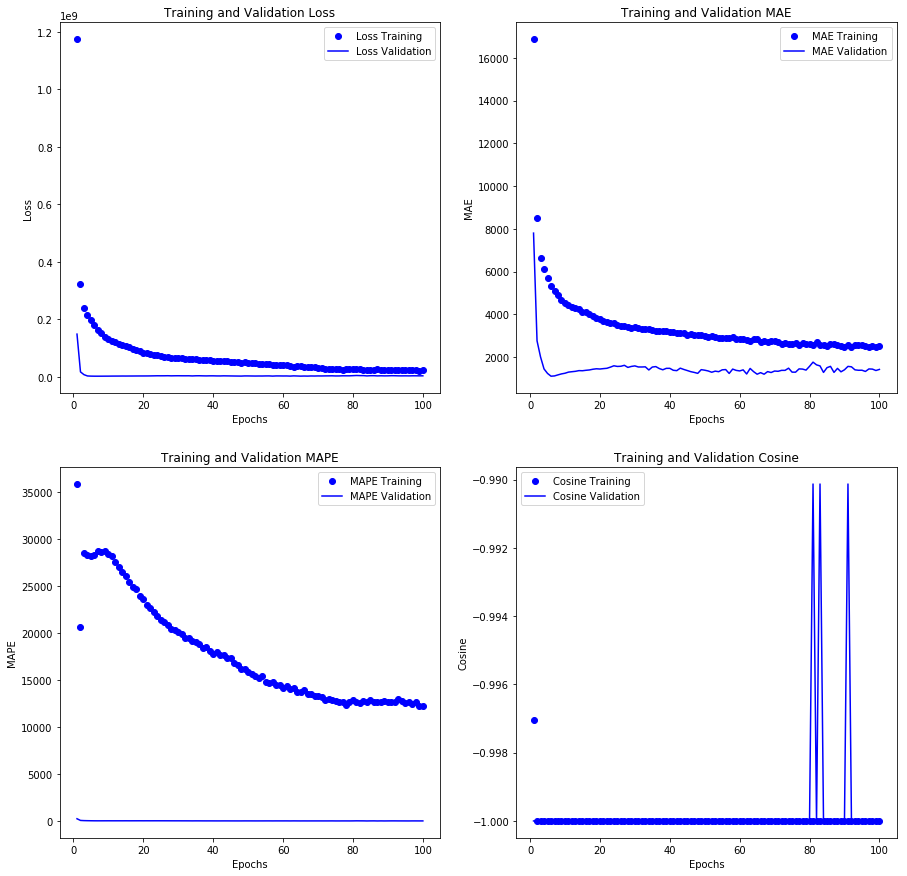

In [48]:
plot_hist(100, hist)

In [49]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

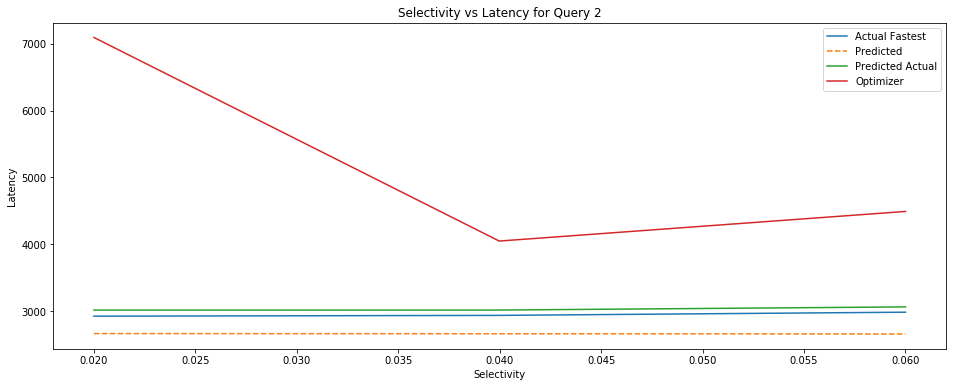

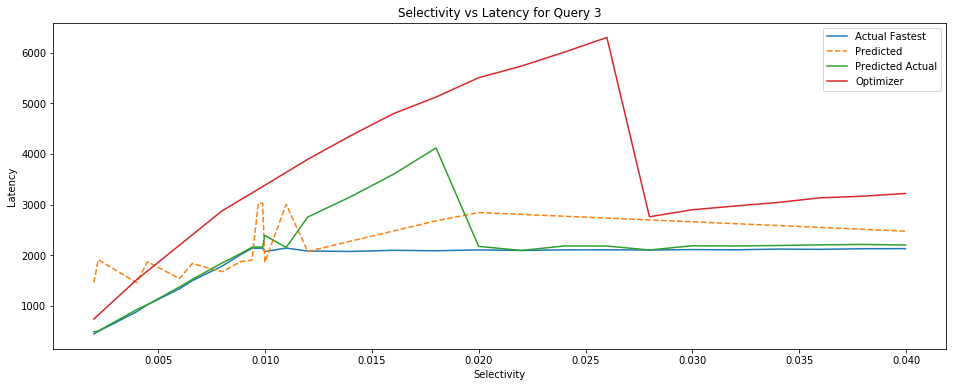

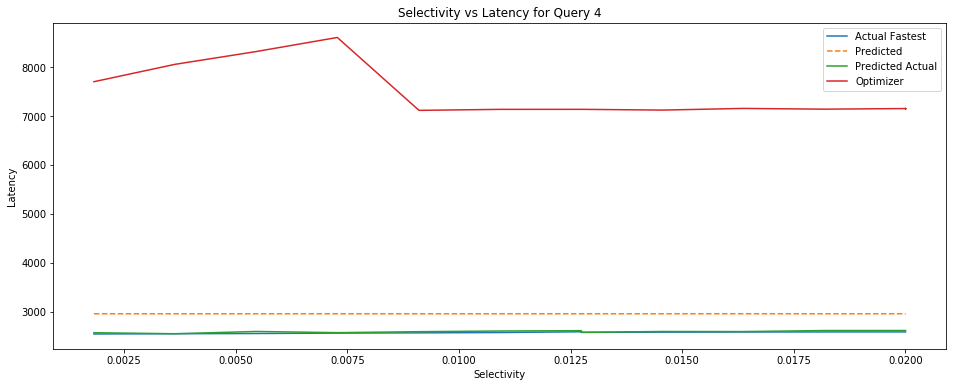

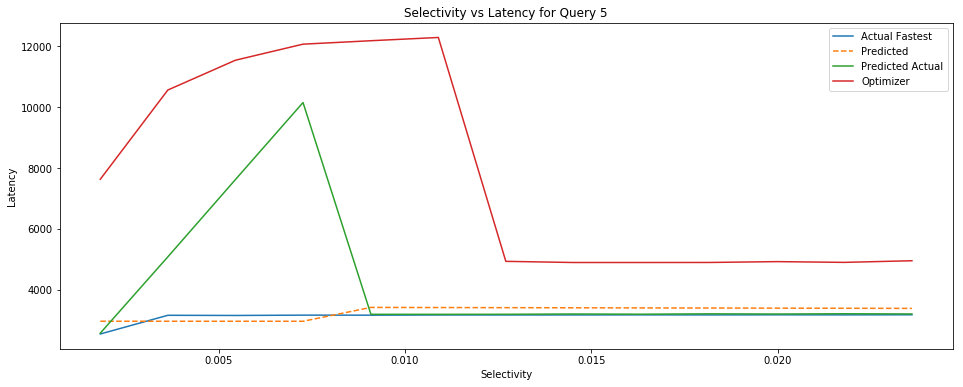

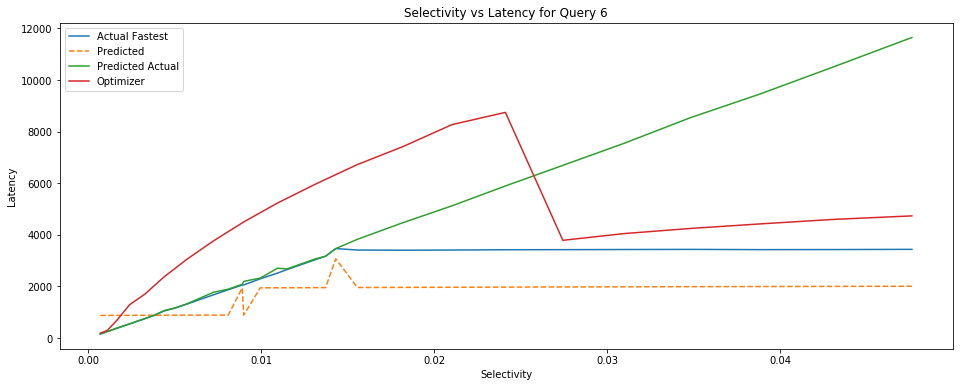

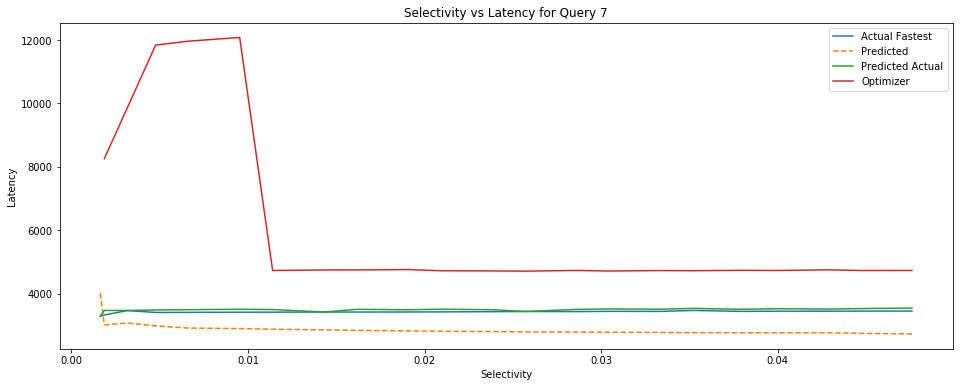

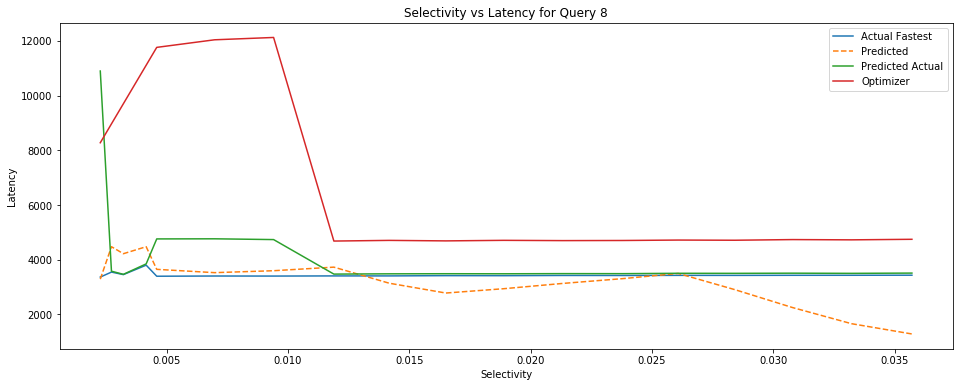

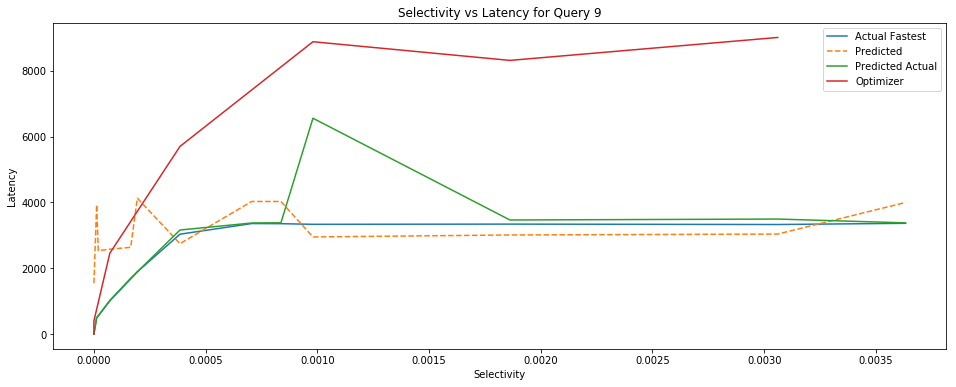

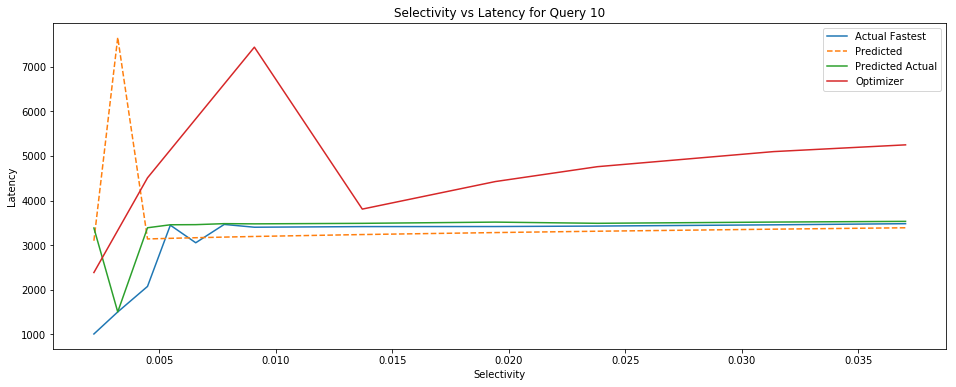

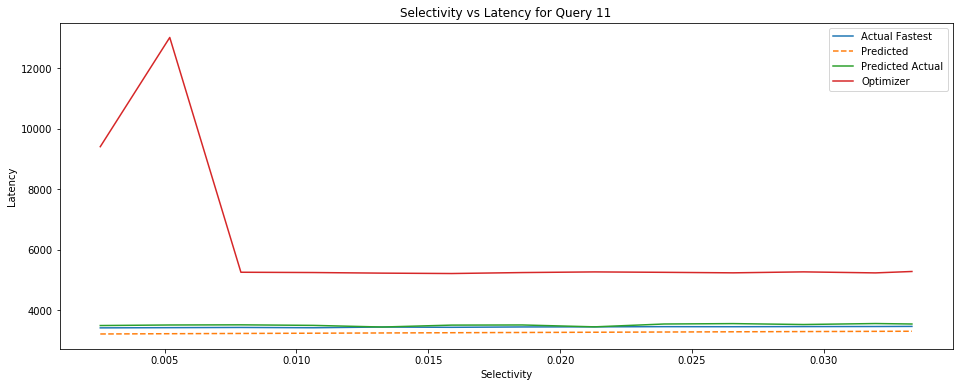

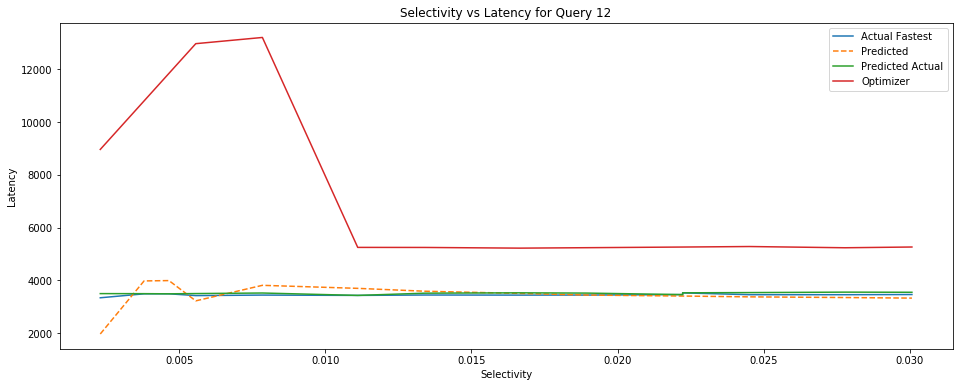

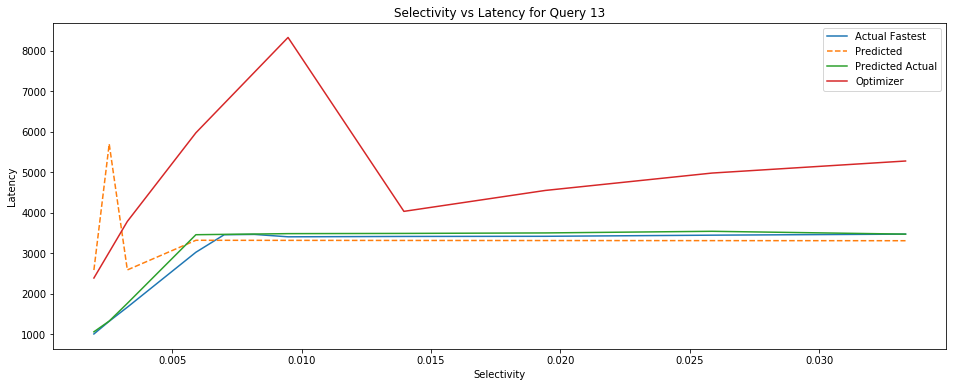

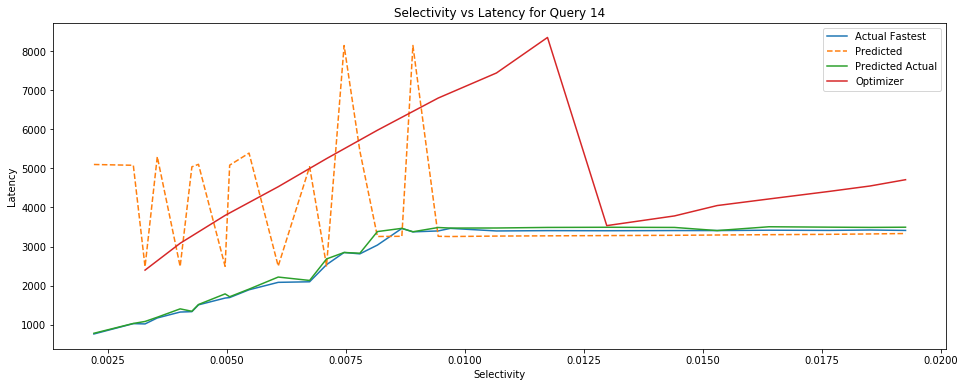

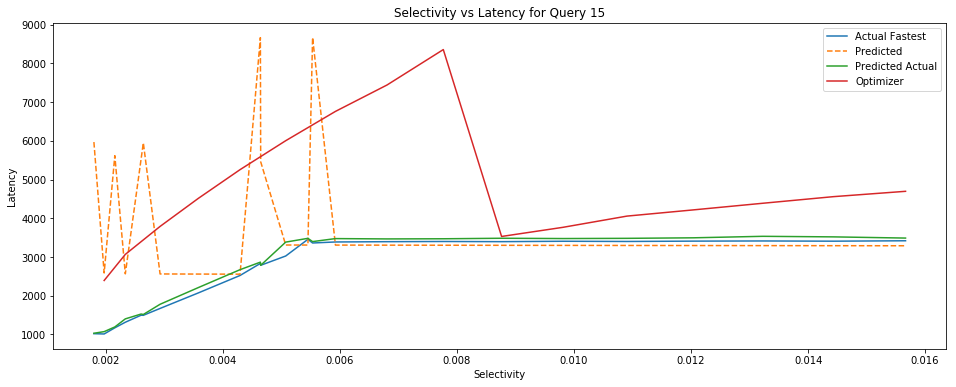

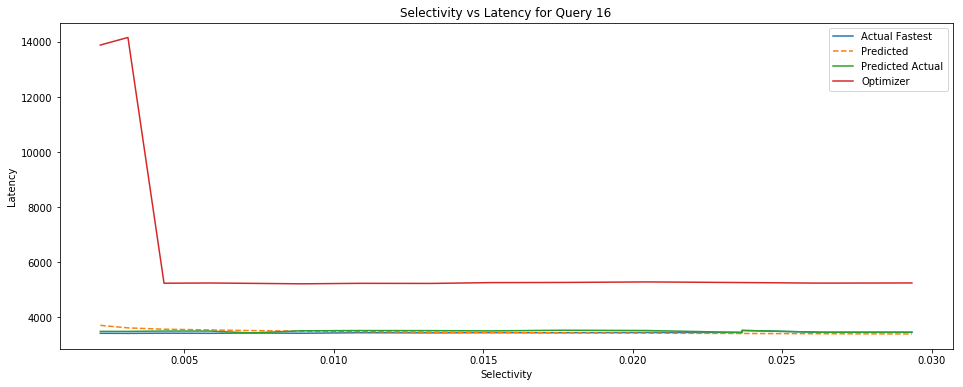

In [50]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

That performed very well.

# Architecture 8

Let's see what happens with only a single layer.

In [51]:
keras.backend.clear_session()

model = Sequential()

model.add(Dense(128, activation="relu"))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

In [52]:
hist = train_model(model, "ModelMLP-8.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 30us/step - loss: 1622743170.2008 - mean_squared_error: 1622743170.2008 - mean_absolute_error: 16183.8087 - mean_absolute_percentage_error: 2568.5503 - cosine_proximity: -0.9855 - val_loss: 9745506.7300 - val_mean_squared_error: 9745506.7300 - val_mean_absolute_error: 2504.2551 - val_mean_absolute_percentage_error: 60.7896 - val_cosine_proximity: -1.0000
Epoch 2/100
20263/20263 [==============================] - 0s 24us/step - loss: 1515353057.9755 - mean_squared_error: 1515353057.9755 - mean_absolute_error: 13849.5698 - mean_absolute_percentage_error: 16212.4987 - cosine_proximity: -1.0000 - val_loss: 4463389.7637 - val_mean_squared_error: 4463389.7637 - val_mean_absolute_error: 1880.4946 - val_mean_absolute_percentage_error: 84.3460 - val_cosine_proximity: -1.0000
Epoch 3/100
20263/20263 [==============================] - 0s 24us/step - loss: 1403171593.9738 - mean_squared_e

20263/20263 [==============================] - 1s 26us/step - loss: 910770548.1937 - mean_squared_error: 910770548.1937 - mean_absolute_error: 16857.9533 - mean_absolute_percentage_error: 11056.6896 - cosine_proximity: -0.7653 - val_loss: 85363293.7473 - val_mean_squared_error: 85363293.7473 - val_mean_absolute_error: 6475.4828 - val_mean_absolute_percentage_error: 265.2855 - val_cosine_proximity: -0.5353
Epoch 21/100
20263/20263 [==============================] - 0s 25us/step - loss: 890575068.8273 - mean_squared_error: 890575068.8273 - mean_absolute_error: 16820.0387 - mean_absolute_percentage_error: 10124.5571 - cosine_proximity: -0.7388 - val_loss: 96926062.3687 - val_mean_squared_error: 96926062.3687 - val_mean_absolute_error: 6945.8690 - val_mean_absolute_percentage_error: 279.9979 - val_cosine_proximity: -0.4840
Epoch 22/100
20263/20263 [==============================] - 1s 25us/step - loss: 871096307.5746 - mean_squared_error: 871096307.5746 - mean_absolute_error: 16857.3242 - 

20263/20263 [==============================] - 1s 25us/step - loss: 589495010.4553 - mean_squared_error: 589495010.4553 - mean_absolute_error: 14684.4626 - mean_absolute_percentage_error: 14594.3043 - cosine_proximity: -0.6227 - val_loss: 349912856.3632 - val_mean_squared_error: 349912856.3632 - val_mean_absolute_error: 16321.8133 - val_mean_absolute_percentage_error: 608.9189 - val_cosine_proximity: 0.5563
Epoch 40/100
20263/20263 [==============================] - 0s 25us/step - loss: 575376207.4102 - mean_squared_error: 575376207.4102 - mean_absolute_error: 14511.9946 - mean_absolute_percentage_error: 14973.7553 - cosine_proximity: -0.6371 - val_loss: 363932771.5878 - val_mean_squared_error: 363932771.5878 - val_mean_absolute_error: 16713.6200 - val_mean_absolute_percentage_error: 622.8314 - val_cosine_proximity: 0.5563
Epoch 41/100
20263/20263 [==============================] - 1s 26us/step - loss: 561845680.5267 - mean_squared_error: 561845680.5267 - mean_absolute_error: 14343.498

20263/20263 [==============================] - 1s 25us/step - loss: 399461249.9725 - mean_squared_error: 399461249.9725 - mean_absolute_error: 11754.8638 - mean_absolute_percentage_error: 15299.0793 - cosine_proximity: -0.6996 - val_loss: 500320745.7023 - val_mean_squared_error: 500320745.7023 - val_mean_absolute_error: 20577.0932 - val_mean_absolute_percentage_error: 754.3874 - val_cosine_proximity: 0.5563
Epoch 59/100
20263/20263 [==============================] - 1s 25us/step - loss: 393343527.1950 - mean_squared_error: 393343527.1950 - mean_absolute_error: 11617.4057 - mean_absolute_percentage_error: 15157.4979 - cosine_proximity: -0.7046 - val_loss: 499840026.6435 - val_mean_squared_error: 499840026.6435 - val_mean_absolute_error: 20512.2053 - val_mean_absolute_percentage_error: 751.8468 - val_cosine_proximity: 0.5563
Epoch 60/100
20263/20263 [==============================] - 1s 25us/step - loss: 387440371.0169 - mean_squared_error: 387440371.0169 - mean_absolute_error: 11536.470

20263/20263 [==============================] - 1s 25us/step - loss: 313756225.7505 - mean_squared_error: 313756225.7505 - mean_absolute_error: 9851.4323 - mean_absolute_percentage_error: 13217.3424 - cosine_proximity: -0.7646 - val_loss: 362134803.9163 - val_mean_squared_error: 362134803.9163 - val_mean_absolute_error: 17540.2619 - val_mean_absolute_percentage_error: 644.0362 - val_cosine_proximity: 0.5563
Epoch 78/100
20263/20263 [==============================] - 1s 25us/step - loss: 310606820.6224 - mean_squared_error: 310606820.6224 - mean_absolute_error: 9763.2635 - mean_absolute_percentage_error: 12941.3866 - cosine_proximity: -0.7650 - val_loss: 350182331.1362 - val_mean_squared_error: 350182331.1362 - val_mean_absolute_error: 17217.3913 - val_mean_absolute_percentage_error: 632.1353 - val_cosine_proximity: 0.5563
Epoch 79/100
20263/20263 [==============================] - 1s 26us/step - loss: 307467380.2884 - mean_squared_error: 307467380.2884 - mean_absolute_error: 9665.3633 -

20263/20263 [==============================] - 1s 25us/step - loss: 264093029.4272 - mean_squared_error: 264093029.4272 - mean_absolute_error: 8291.8196 - mean_absolute_percentage_error: 13354.2082 - cosine_proximity: -0.8519 - val_loss: 147556530.9593 - val_mean_squared_error: 147556530.9593 - val_mean_absolute_error: 10627.0321 - val_mean_absolute_percentage_error: 384.7310 - val_cosine_proximity: 0.5563
Epoch 97/100
20263/20263 [==============================] - 1s 25us/step - loss: 262310676.5269 - mean_squared_error: 262310676.5269 - mean_absolute_error: 8234.8014 - mean_absolute_percentage_error: 13557.9169 - cosine_proximity: -0.8551 - val_loss: 141001317.7134 - val_mean_squared_error: 141001317.7134 - val_mean_absolute_error: 10348.9007 - val_mean_absolute_percentage_error: 374.1651 - val_cosine_proximity: 0.5563
Epoch 98/100
20263/20263 [==============================] - 1s 25us/step - loss: 260621995.2173 - mean_squared_error: 260621995.2173 - mean_absolute_error: 8182.3354 -

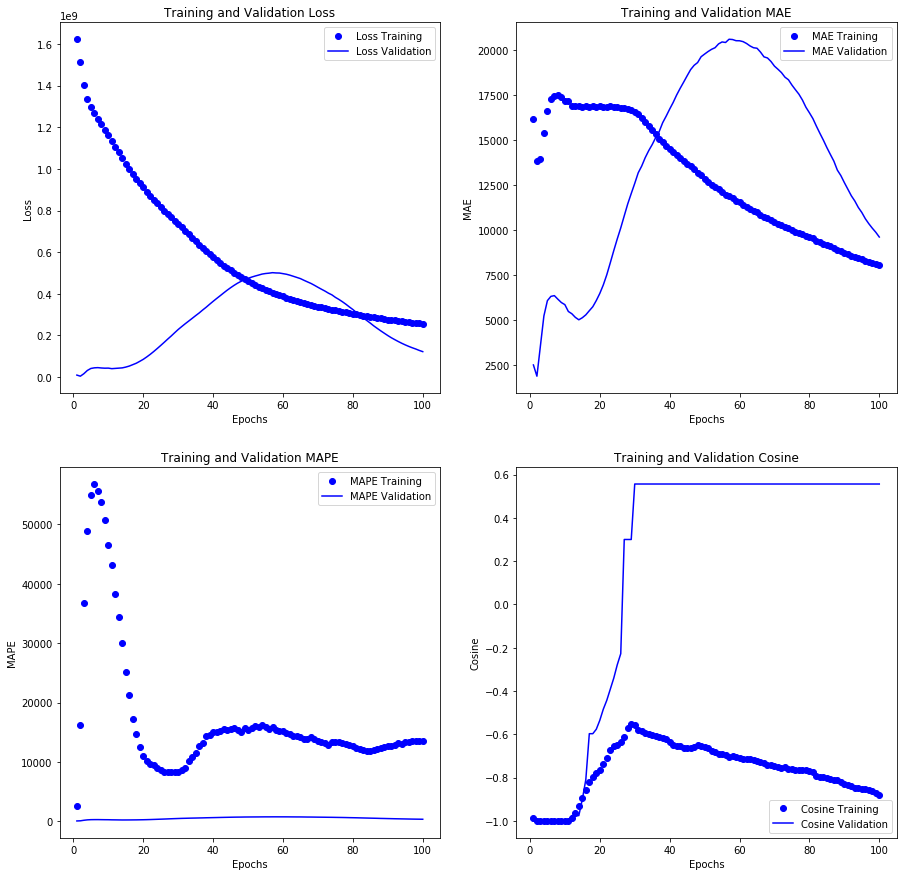

In [53]:
plot_hist(100, hist)

In [54]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

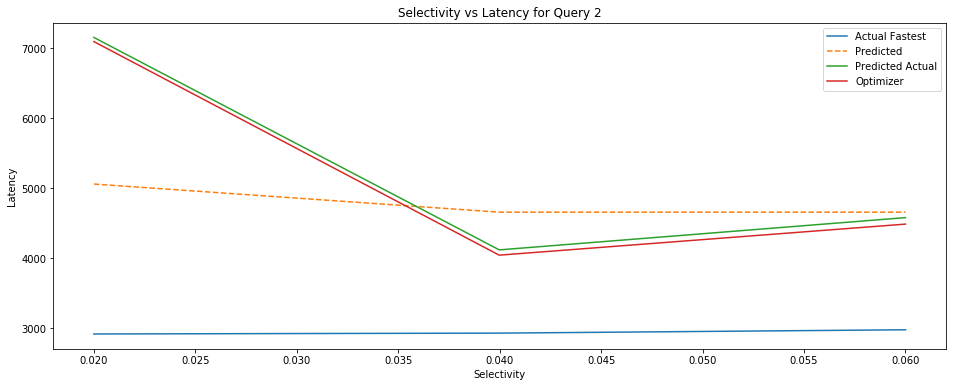

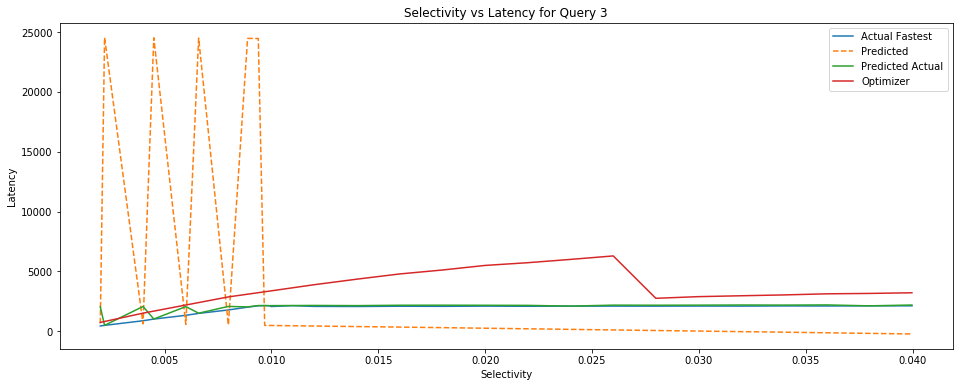

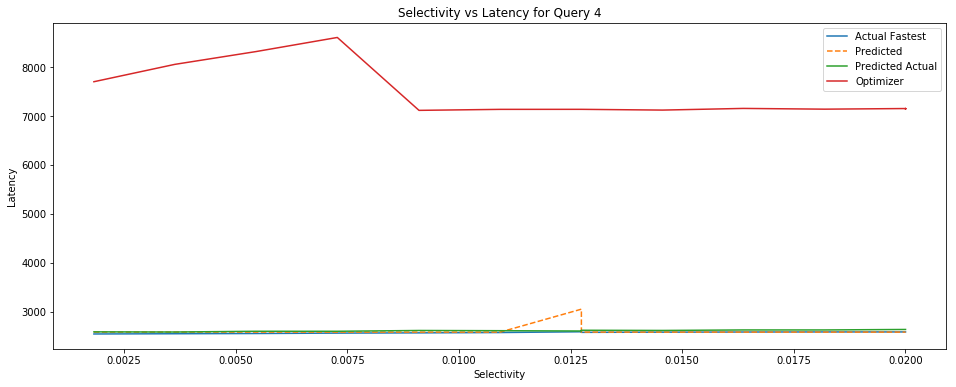

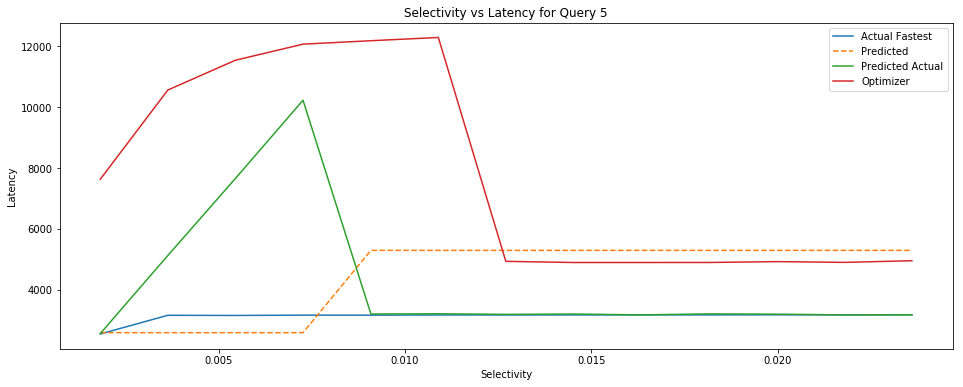

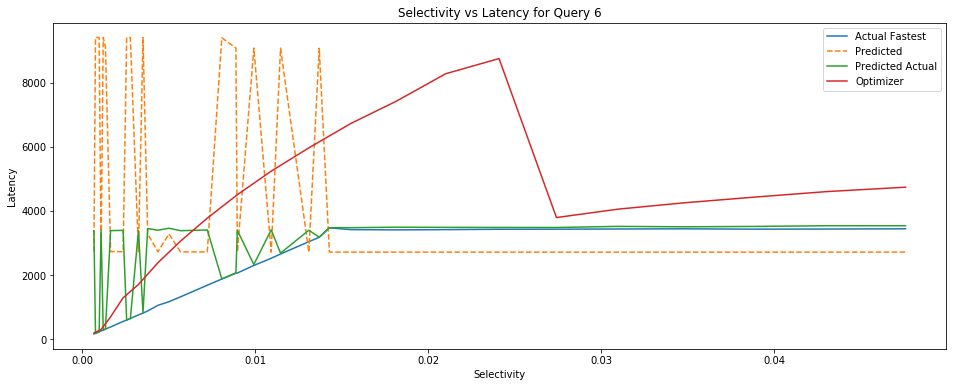

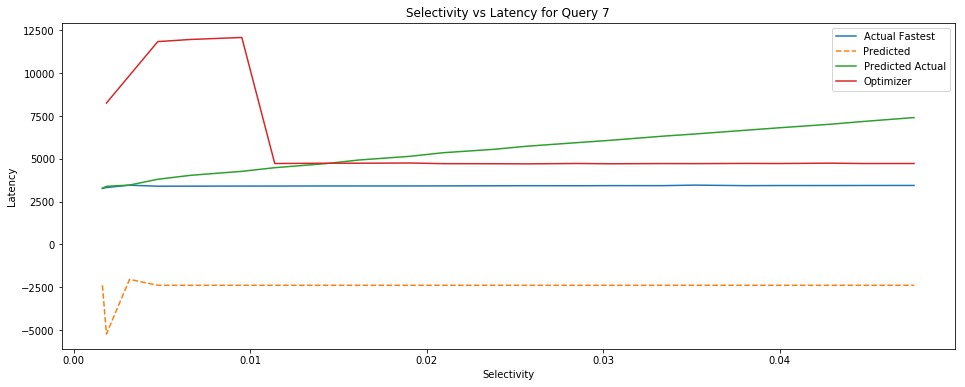

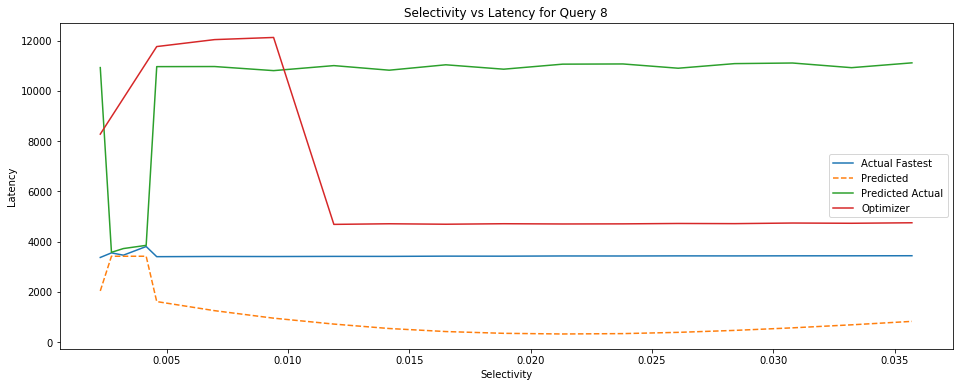

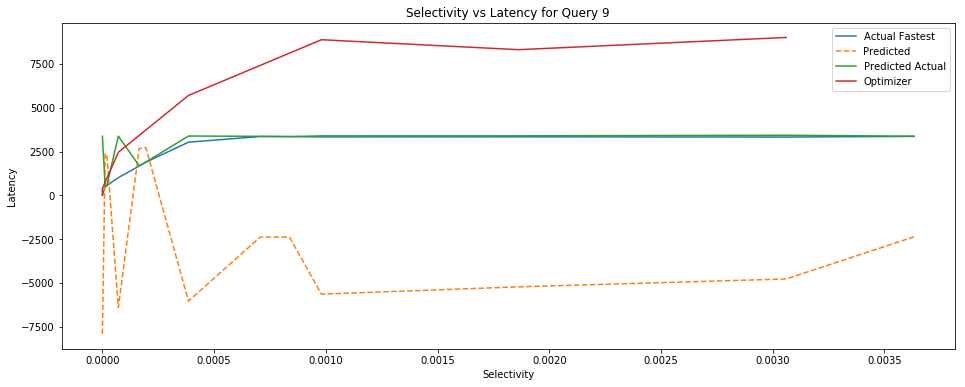

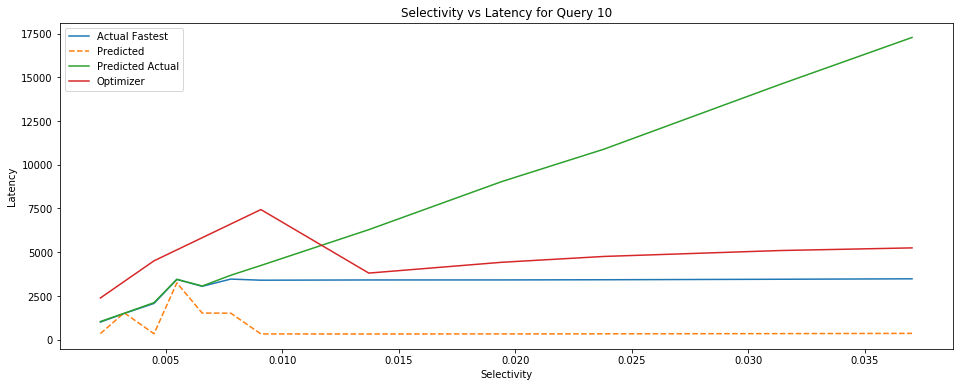

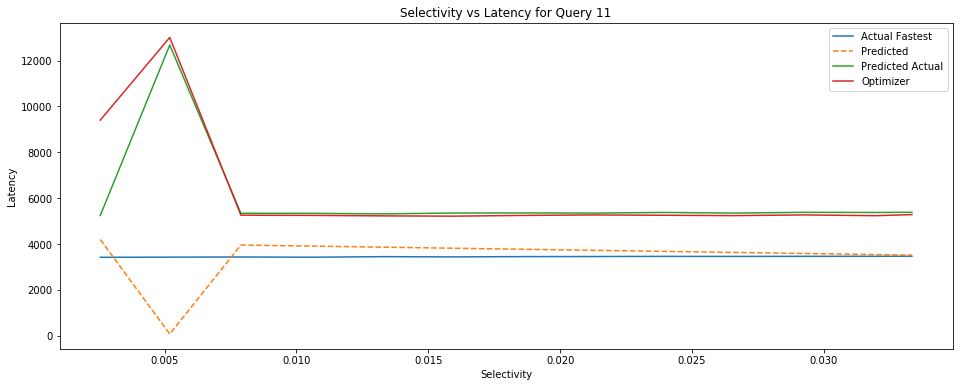

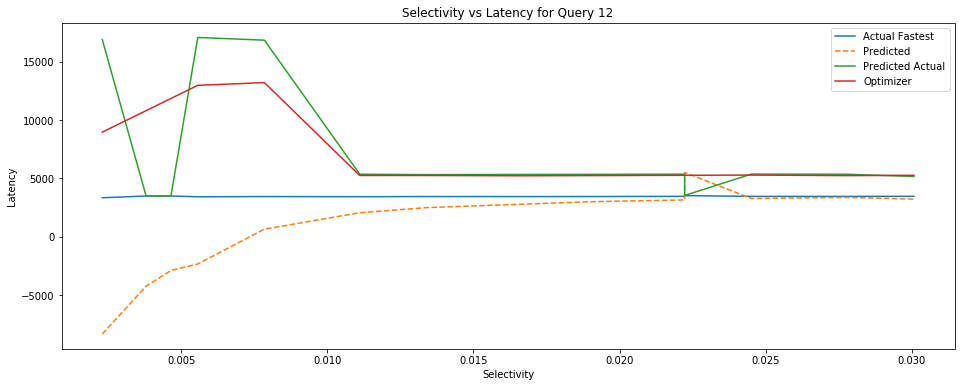

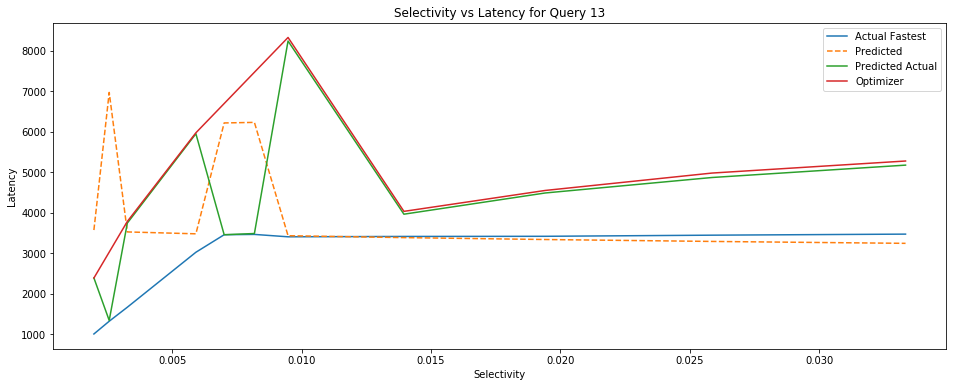

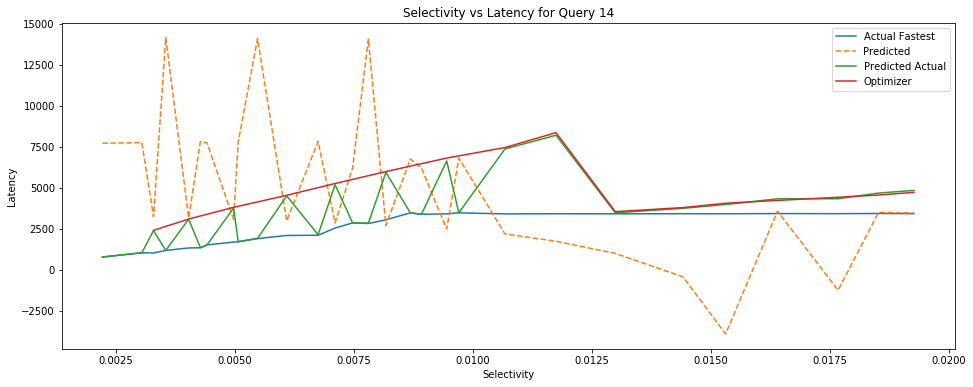

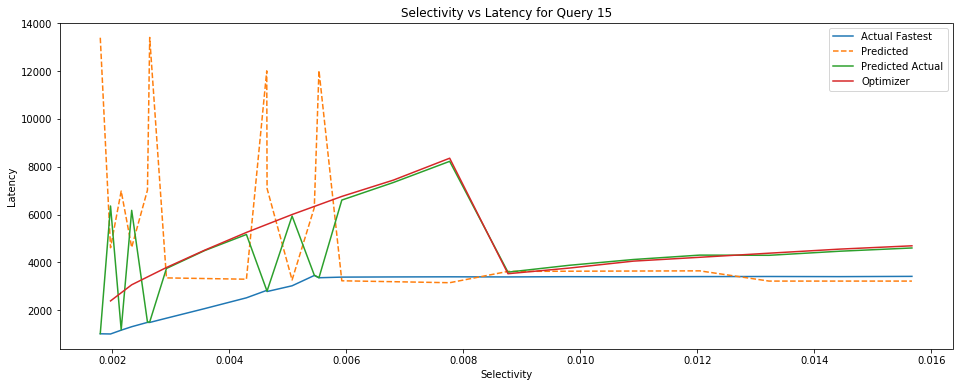

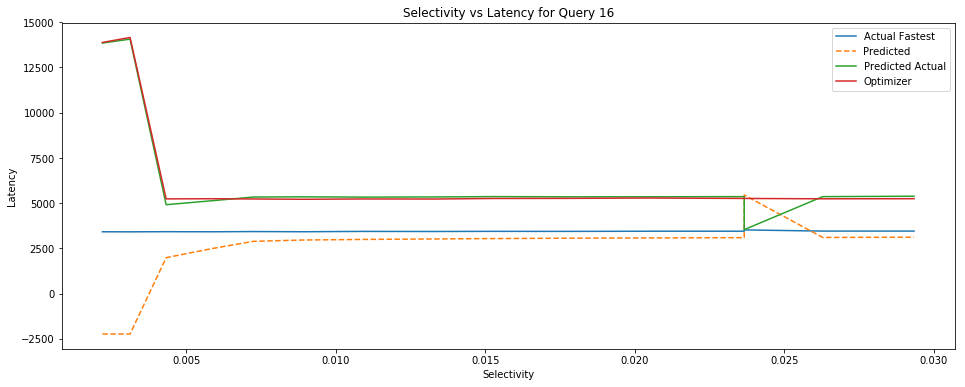

In [55]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

# Architecture 9
This design is similar to the work in this paper: https://arxiv.org/pdf/1809.00677.pdf

Where they describe an architecure with alternating relu and linear dense layers. I chose to apply this in an neuron strategy similar to Architecture 7.

In [56]:
keras.backend.clear_session()

model = Sequential()

model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="linear"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="linear"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="linear"))
model.add(Dense(1, kernel_initializer='normal')) 

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

In [57]:
hist = train_model(model, "ModelMLP-9.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 56us/step - loss: 517629409.1259 - mean_squared_error: 517629409.1259 - mean_absolute_error: 9751.7326 - mean_absolute_percentage_error: 29259.0512 - cosine_proximity: -0.9968 - val_loss: 3232094.7991 - val_mean_squared_error: 3232094.7991 - val_mean_absolute_error: 1393.7498 - val_mean_absolute_percentage_error: 69.6726 - val_cosine_proximity: -1.0000
Epoch 2/100
20263/20263 [==============================] - 1s 43us/step - loss: 164053871.7342 - mean_squared_error: 164053871.7342 - mean_absolute_error: 5087.6294 - mean_absolute_percentage_error: 25831.3425 - cosine_proximity: -1.0000 - val_loss: 3571937.4117 - val_mean_squared_error: 3571937.4117 - val_mean_absolute_error: 1394.3538 - val_mean_absolute_percentage_error: 71.9700 - val_cosine_proximity: -1.0000
Epoch 3/100
20263/20263 [==============================] - 1s 43us/step - loss: 116951620.4964 - mean_squared_error: 

Epoch 21/100
20263/20263 [==============================] - 1s 45us/step - loss: 57689663.6801 - mean_squared_error: 57689663.6801 - mean_absolute_error: 3006.4445 - mean_absolute_percentage_error: 6424.4598 - cosine_proximity: -0.9981 - val_loss: 2685530.3050 - val_mean_squared_error: 2685530.3050 - val_mean_absolute_error: 1237.3026 - val_mean_absolute_percentage_error: 39.7597 - val_cosine_proximity: -0.9791
Epoch 22/100
20263/20263 [==============================] - 1s 44us/step - loss: 60095858.2634 - mean_squared_error: 60095858.2634 - mean_absolute_error: 3047.2958 - mean_absolute_percentage_error: 6262.1680 - cosine_proximity: -0.9987 - val_loss: 2470031.7067 - val_mean_squared_error: 2470031.7067 - val_mean_absolute_error: 1198.5207 - val_mean_absolute_percentage_error: 42.6063 - val_cosine_proximity: -0.9451
Epoch 23/100
20263/20263 [==============================] - 1s 45us/step - loss: 55377675.0371 - mean_squared_error: 55377675.0371 - mean_absolute_error: 2981.9793 - mean

Epoch 41/100
20263/20263 [==============================] - 1s 46us/step - loss: 35356239.3606 - mean_squared_error: 35356239.3606 - mean_absolute_error: 2537.9834 - mean_absolute_percentage_error: 4291.9986 - cosine_proximity: -0.9969 - val_loss: 2400941.6291 - val_mean_squared_error: 2400941.6291 - val_mean_absolute_error: 1135.5102 - val_mean_absolute_percentage_error: 45.8549 - val_cosine_proximity: -1.0000
Epoch 42/100
20263/20263 [==============================] - 1s 45us/step - loss: 33498656.5821 - mean_squared_error: 33498656.5821 - mean_absolute_error: 2497.0971 - mean_absolute_percentage_error: 4024.8081 - cosine_proximity: -0.9971 - val_loss: 1876809.2821 - val_mean_squared_error: 1876809.2821 - val_mean_absolute_error: 1006.9108 - val_mean_absolute_percentage_error: 41.6349 - val_cosine_proximity: -0.9597
Epoch 43/100
20263/20263 [==============================] - 1s 47us/step - loss: 40981113.3939 - mean_squared_error: 40981113.3939 - mean_absolute_error: 2637.1607 - mean

Epoch 61/100
20263/20263 [==============================] - 1s 47us/step - loss: 25247873.0668 - mean_squared_error: 25247873.0668 - mean_absolute_error: 2278.8839 - mean_absolute_percentage_error: 4458.1187 - cosine_proximity: -0.9962 - val_loss: 3409942.1973 - val_mean_squared_error: 3409942.1973 - val_mean_absolute_error: 1378.6862 - val_mean_absolute_percentage_error: 42.9424 - val_cosine_proximity: -1.0000
Epoch 62/100
20263/20263 [==============================] - 1s 47us/step - loss: 32765848.3826 - mean_squared_error: 32765848.3826 - mean_absolute_error: 2460.6792 - mean_absolute_percentage_error: 4061.4995 - cosine_proximity: -0.9968 - val_loss: 3871324.2040 - val_mean_squared_error: 3871324.2040 - val_mean_absolute_error: 1383.2602 - val_mean_absolute_percentage_error: 43.5072 - val_cosine_proximity: -1.0000
Epoch 63/100
20263/20263 [==============================] - 1s 47us/step - loss: 23822883.4979 - mean_squared_error: 23822883.4979 - mean_absolute_error: 2218.0094 - mean

Epoch 81/100
20263/20263 [==============================] - 1s 45us/step - loss: 21080586.9710 - mean_squared_error: 21080586.9710 - mean_absolute_error: 2141.0075 - mean_absolute_percentage_error: 4019.3312 - cosine_proximity: -0.9969 - val_loss: 2677960.4816 - val_mean_squared_error: 2677960.4816 - val_mean_absolute_error: 1186.2253 - val_mean_absolute_percentage_error: 37.3795 - val_cosine_proximity: -1.0000
Epoch 82/100
20263/20263 [==============================] - 1s 45us/step - loss: 20509615.7928 - mean_squared_error: 20509615.7928 - mean_absolute_error: 2133.4030 - mean_absolute_percentage_error: 4039.4454 - cosine_proximity: -0.9976 - val_loss: 2334676.4227 - val_mean_squared_error: 2334676.4227 - val_mean_absolute_error: 1219.8356 - val_mean_absolute_percentage_error: 44.4108 - val_cosine_proximity: -1.0000
Epoch 83/100
20263/20263 [==============================] - 1s 46us/step - loss: 26355404.9036 - mean_squared_error: 26355404.9036 - mean_absolute_error: 2258.7822 - mean

Evaluating Model
25329/25329 [==============================] - 0s 13us/step
[10678477.853974817, 10678477.853974817, 1614.6372352391359, 2718.8710041762274, -0.9947096142288239]


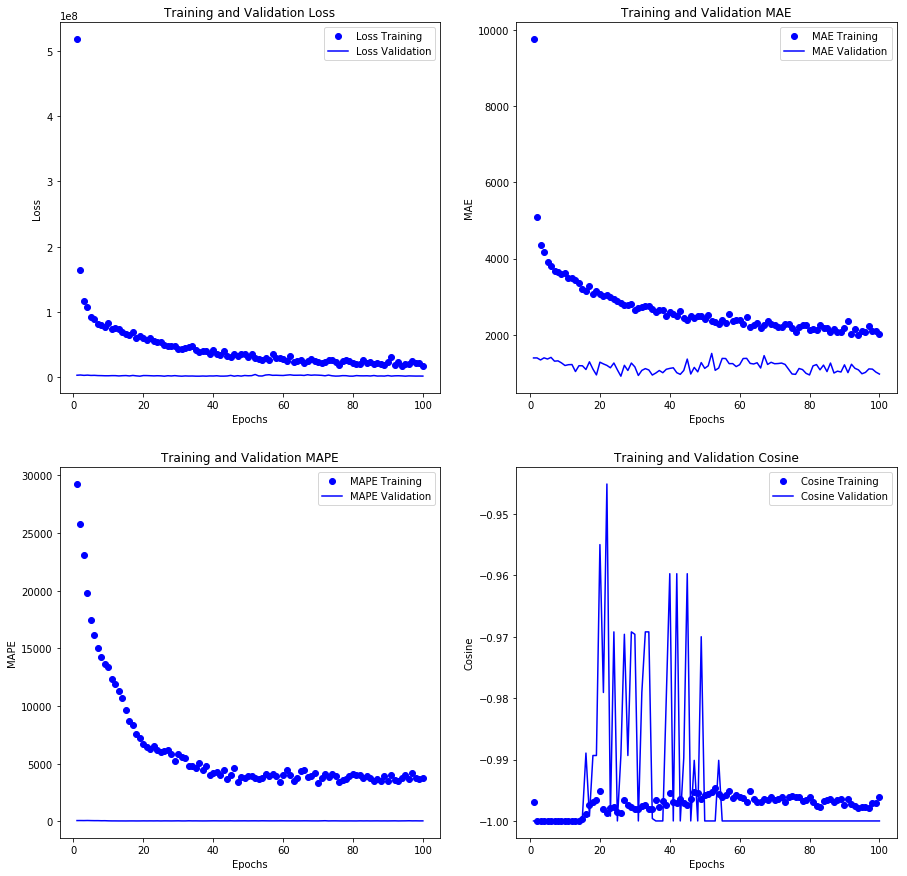

In [58]:
plot_hist(100, hist)

In [59]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

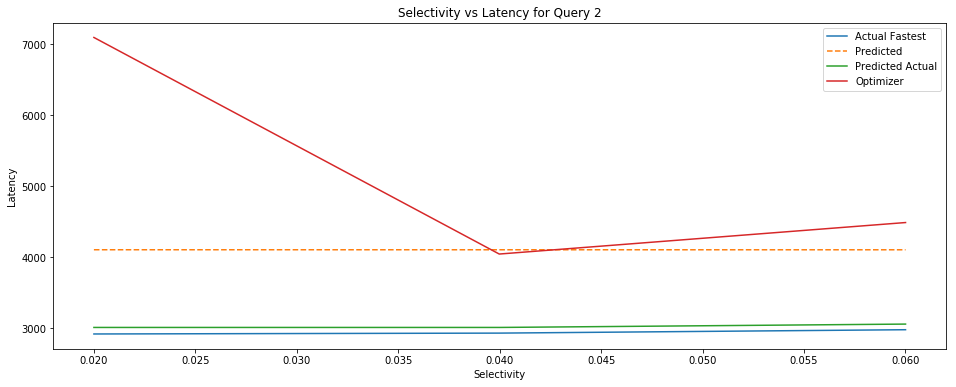

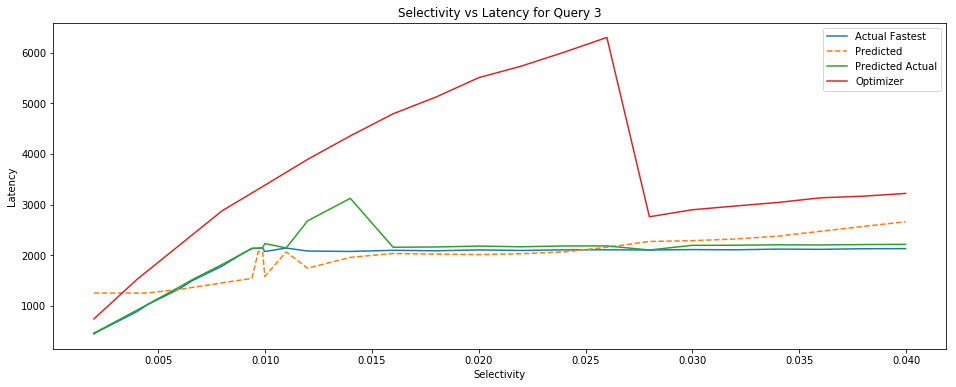

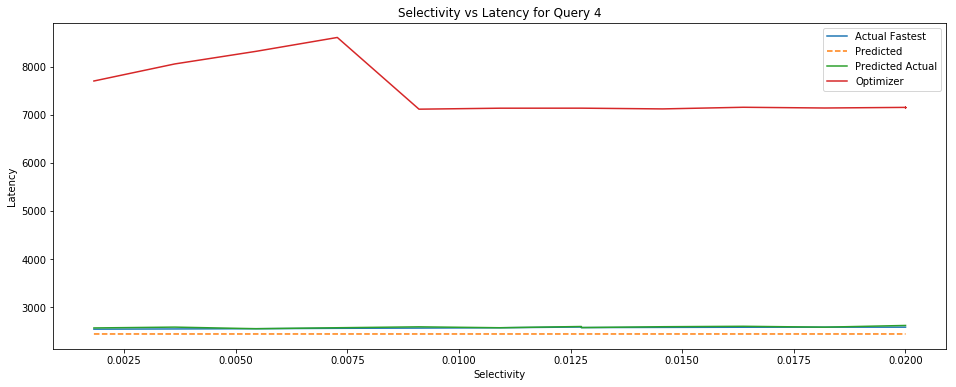

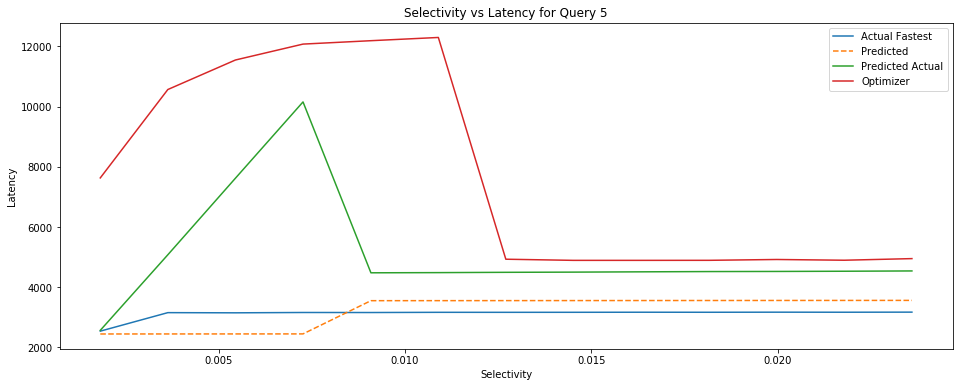

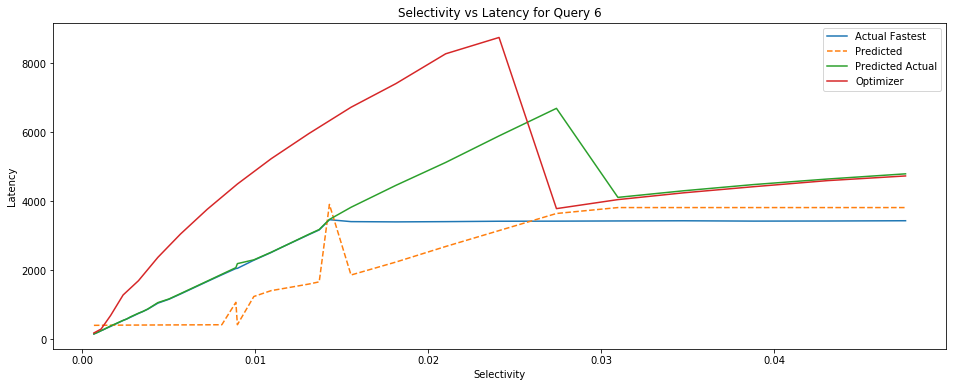

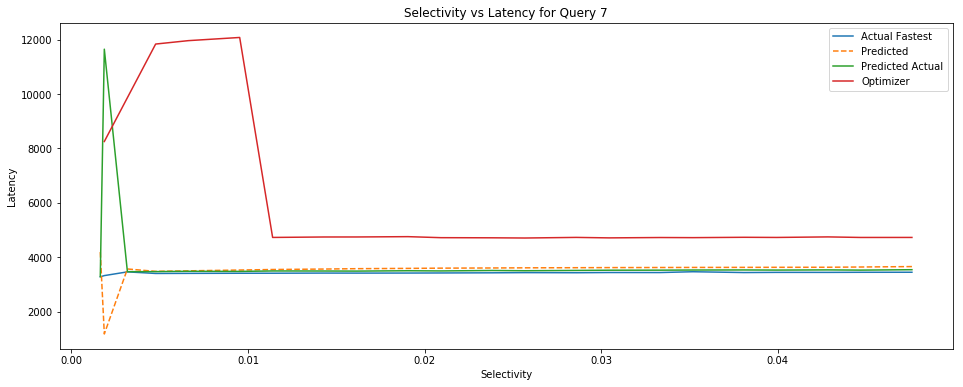

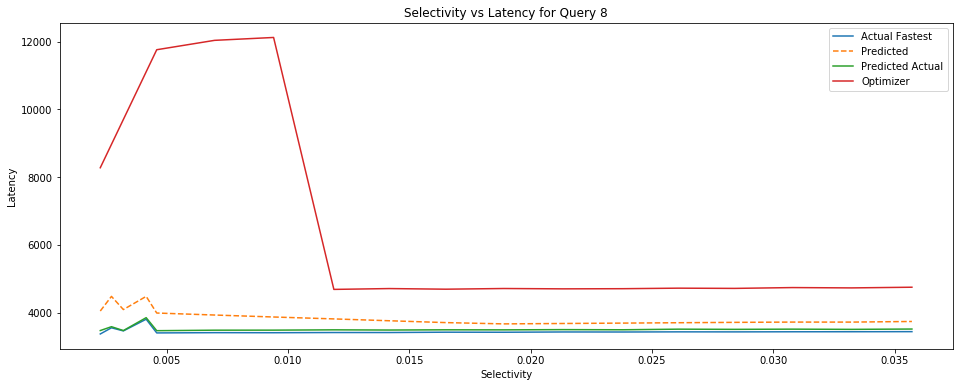

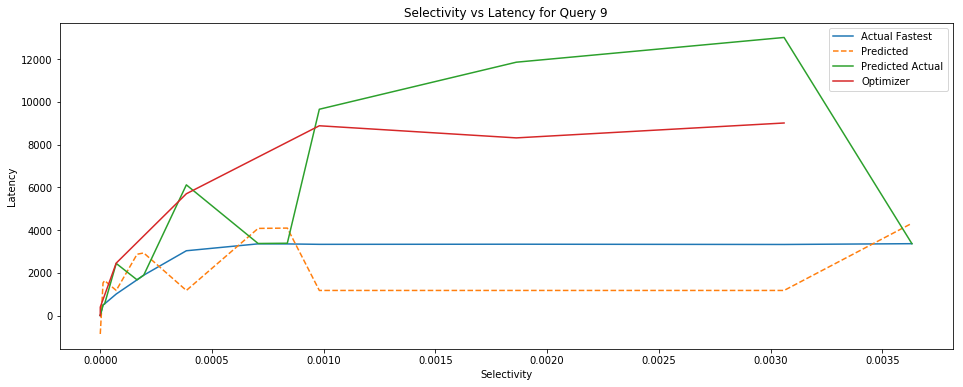

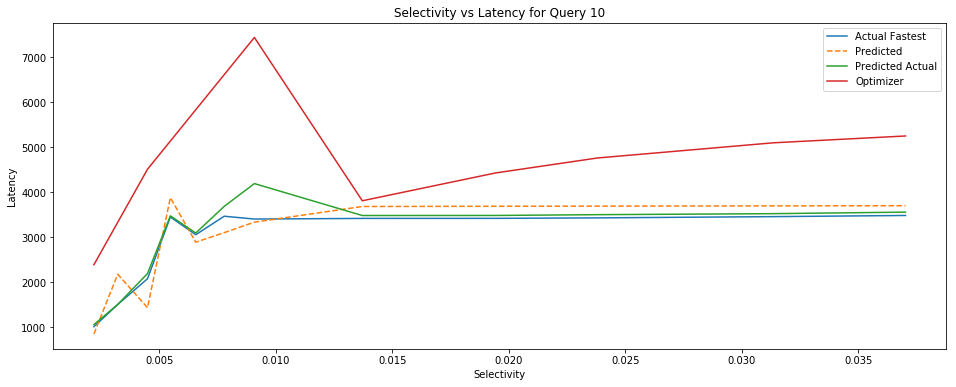

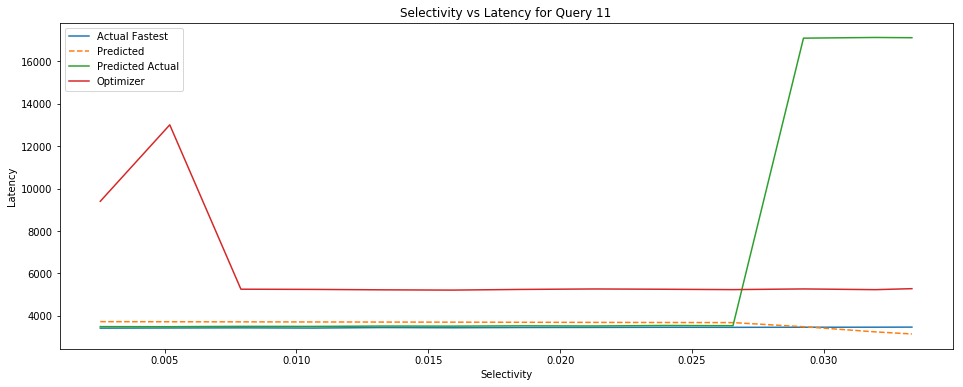

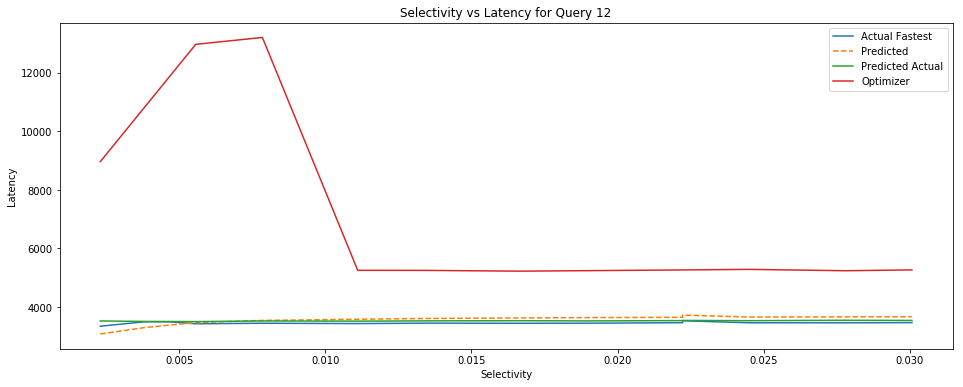

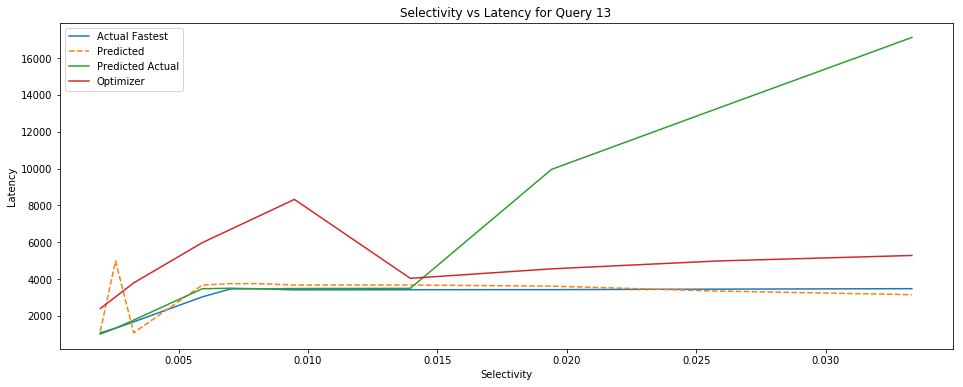

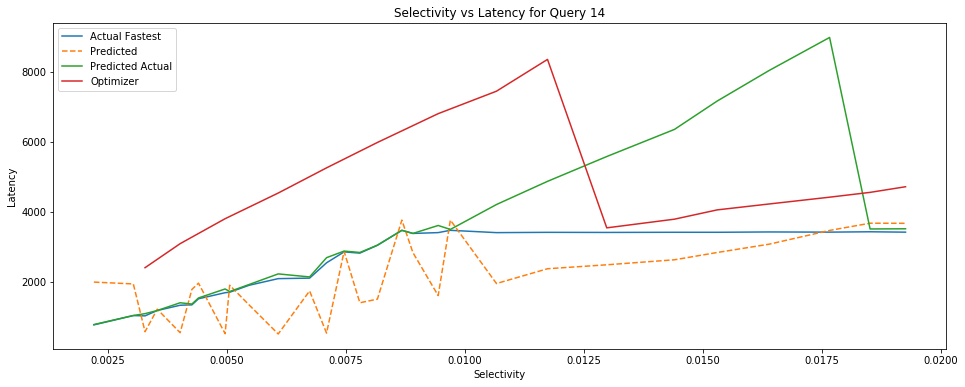

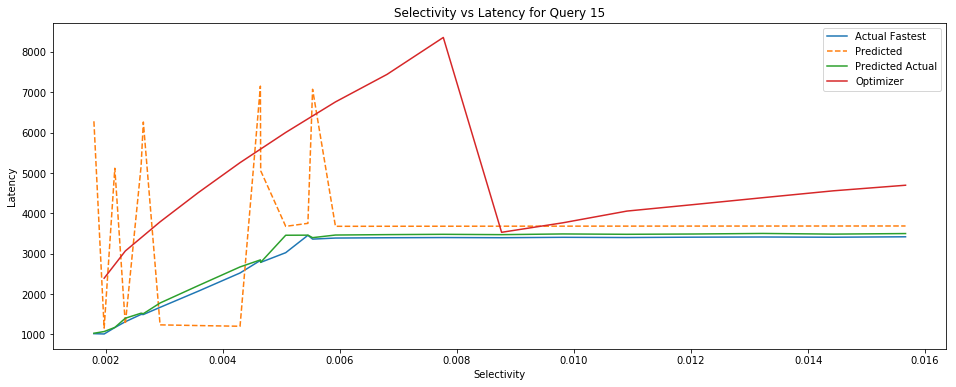

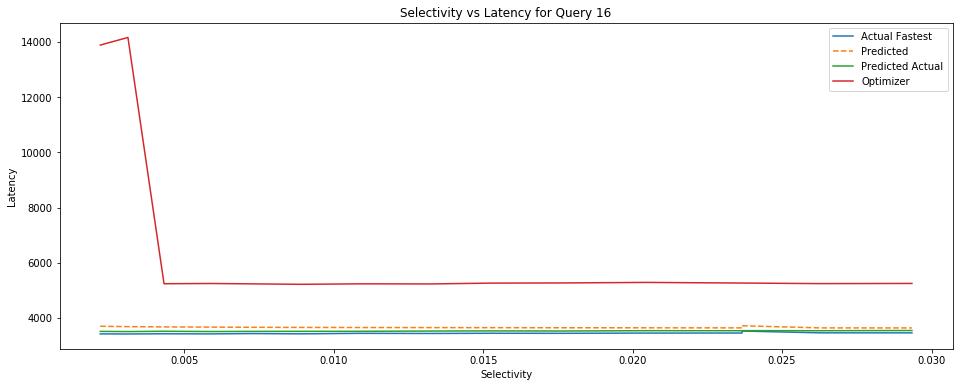

In [60]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

It performed similar to Architecture 7, except that the MAE was lower, which I like. Additionally, many of the queries that had mis-predicted values were leveled off.

# Architecture 10 
with regularization

In [62]:
from keras import regularizers

In [63]:
keras.backend.clear_session()

model = Sequential()

model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="linear"))
model.add(Dense(64, kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="linear"))
model.add(Dense(1, kernel_initializer='normal')) 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])

In [64]:
hist = train_model(model, "ModelMLP-10.h5", X, Y, 100)

Train on 20263 samples, validate on 5066 samples
Epoch 1/100
20263/20263 [==============================] - 1s 57us/step - loss: 561590557.5151 - mean_squared_error: 561590557.3091 - mean_absolute_error: 10390.7847 - mean_absolute_percentage_error: 27877.3119 - cosine_proximity: -0.9973 - val_loss: 17356594.5973 - val_mean_squared_error: 17356592.2722 - val_mean_absolute_error: 3177.5050 - val_mean_absolute_percentage_error: 77.9289 - val_cosine_proximity: -1.0000
Epoch 2/100
20263/20263 [==============================] - 1s 42us/step - loss: 175366357.4832 - mean_squared_error: 175366356.5602 - mean_absolute_error: 5534.7017 - mean_absolute_percentage_error: 23862.7691 - cosine_proximity: -1.0000 - val_loss: 5821195.5624 - val_mean_squared_error: 5821193.3044 - val_mean_absolute_error: 1830.5696 - val_mean_absolute_percentage_error: 51.8368 - val_cosine_proximity: -1.0000
Epoch 3/100
20263/20263 [==============================] - 1s 42us/step - loss: 130535338.9461 - mean_squared_erro

Epoch 21/100
20263/20263 [==============================] - 1s 43us/step - loss: 54331814.9501 - mean_squared_error: 54331812.6835 - mean_absolute_error: 3067.3465 - mean_absolute_percentage_error: 11032.8538 - cosine_proximity: -0.9998 - val_loss: 3467745.7935 - val_mean_squared_error: 3467742.8160 - val_mean_absolute_error: 1355.6467 - val_mean_absolute_percentage_error: 43.5303 - val_cosine_proximity: -1.0000
Epoch 22/100
20263/20263 [==============================] - 1s 43us/step - loss: 57290964.8503 - mean_squared_error: 57290962.5377 - mean_absolute_error: 3148.2272 - mean_absolute_percentage_error: 10629.1422 - cosine_proximity: -1.0000 - val_loss: 4626300.2426 - val_mean_squared_error: 4626297.2853 - val_mean_absolute_error: 1547.6671 - val_mean_absolute_percentage_error: 43.9266 - val_cosine_proximity: -0.9704
Epoch 23/100
20263/20263 [==============================] - 1s 44us/step - loss: 54526128.5778 - mean_squared_error: 54526126.3358 - mean_absolute_error: 3081.4761 - me

Epoch 41/100
20263/20263 [==============================] - 1s 53us/step - loss: 30866375.9387 - mean_squared_error: 30866372.7042 - mean_absolute_error: 2635.4939 - mean_absolute_percentage_error: 9663.5377 - cosine_proximity: -0.9997 - val_loss: 3424009.6078 - val_mean_squared_error: 3424006.2973 - val_mean_absolute_error: 1318.7729 - val_mean_absolute_percentage_error: 39.9069 - val_cosine_proximity: -0.9597
Epoch 42/100
20263/20263 [==============================] - 1s 45us/step - loss: 31968394.9510 - mean_squared_error: 31968391.7988 - mean_absolute_error: 2656.5299 - mean_absolute_percentage_error: 9555.6952 - cosine_proximity: -0.9998 - val_loss: 2665898.4285 - val_mean_squared_error: 2665895.0858 - val_mean_absolute_error: 1176.9822 - val_mean_absolute_percentage_error: 39.9983 - val_cosine_proximity: -0.9692
Epoch 43/100
20263/20263 [==============================] - 1s 44us/step - loss: 32301079.8249 - mean_squared_error: 32301076.5747 - mean_absolute_error: 2670.2385 - mean

Epoch 61/100
20263/20263 [==============================] - 1s 61us/step - loss: 24598976.6698 - mean_squared_error: 24598973.2745 - mean_absolute_error: 2454.1034 - mean_absolute_percentage_error: 6835.5671 - cosine_proximity: -0.9930 - val_loss: 2554572.2425 - val_mean_squared_error: 2554568.9183 - val_mean_absolute_error: 1274.3718 - val_mean_absolute_percentage_error: 51.2966 - val_cosine_proximity: -0.9597
Epoch 62/100
20263/20263 [==============================] - 1s 47us/step - loss: 26535233.0078 - mean_squared_error: 26535229.6508 - mean_absolute_error: 2475.6197 - mean_absolute_percentage_error: 7230.6281 - cosine_proximity: -0.9937 - val_loss: 3769528.0078 - val_mean_squared_error: 3769524.5796 - val_mean_absolute_error: 1464.2630 - val_mean_absolute_percentage_error: 57.9118 - val_cosine_proximity: -0.8456
Epoch 63/100
20263/20263 [==============================] - 1s 46us/step - loss: 26222107.5168 - mean_squared_error: 26222104.1919 - mean_absolute_error: 2472.4755 - mean

Epoch 81/100
20263/20263 [==============================] - 1s 45us/step - loss: 28762220.4132 - mean_squared_error: 28762216.7989 - mean_absolute_error: 2505.8260 - mean_absolute_percentage_error: 7091.5694 - cosine_proximity: -0.9891 - val_loss: 3546441.4615 - val_mean_squared_error: 3546437.8045 - val_mean_absolute_error: 1562.8363 - val_mean_absolute_percentage_error: 64.9254 - val_cosine_proximity: -0.8231
Epoch 82/100
20263/20263 [==============================] - 1s 46us/step - loss: 23711234.1357 - mean_squared_error: 23711230.3895 - mean_absolute_error: 2389.5301 - mean_absolute_percentage_error: 5958.7448 - cosine_proximity: -0.9885 - val_loss: 3432006.1160 - val_mean_squared_error: 3432002.5603 - val_mean_absolute_error: 1459.2882 - val_mean_absolute_percentage_error: 70.0132 - val_cosine_proximity: -0.9696
Epoch 83/100
20263/20263 [==============================] - 1s 44us/step - loss: 20632932.4711 - mean_squared_error: 20632928.6512 - mean_absolute_error: 2306.0845 - mean

Evaluating Model
25329/25329 [==============================] - 0s 13us/step
[14903543.84347086, 14903540.332146144, 2035.8189958717496, 4261.544368487264, -0.9827075566525963]


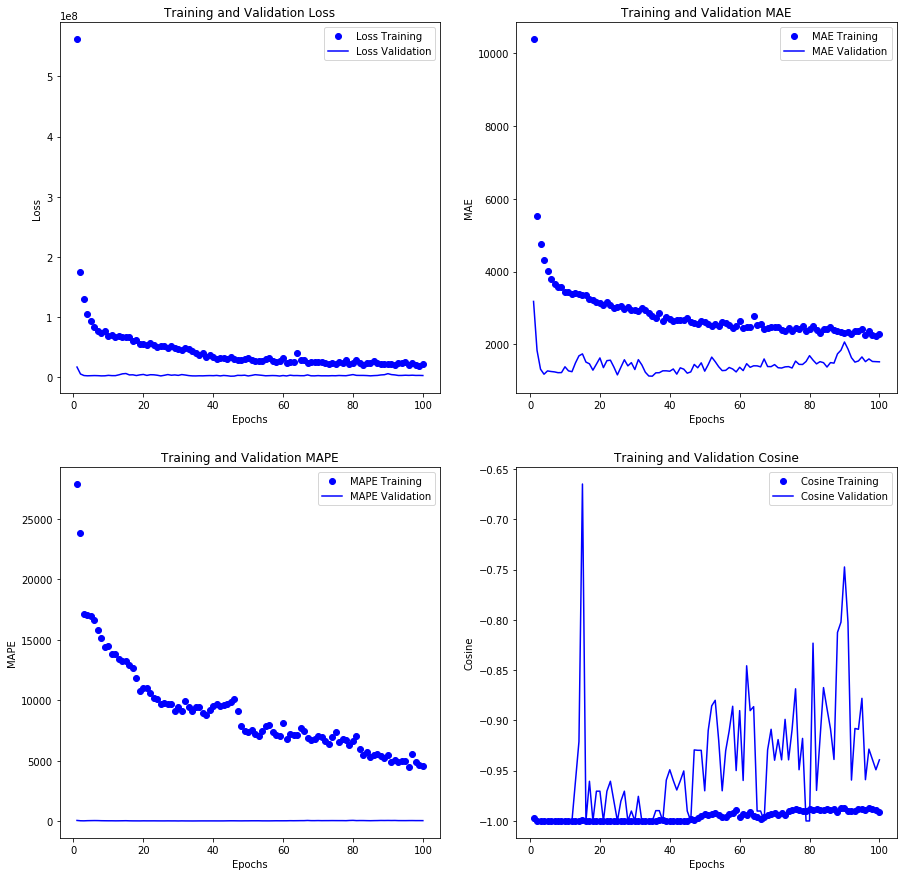

In [65]:
plot_hist(100, hist)

In [66]:
df["predicted"] = model.predict(extract_features(df))
df_p = find_best(df, "predicted").sort_values("selectivity") 

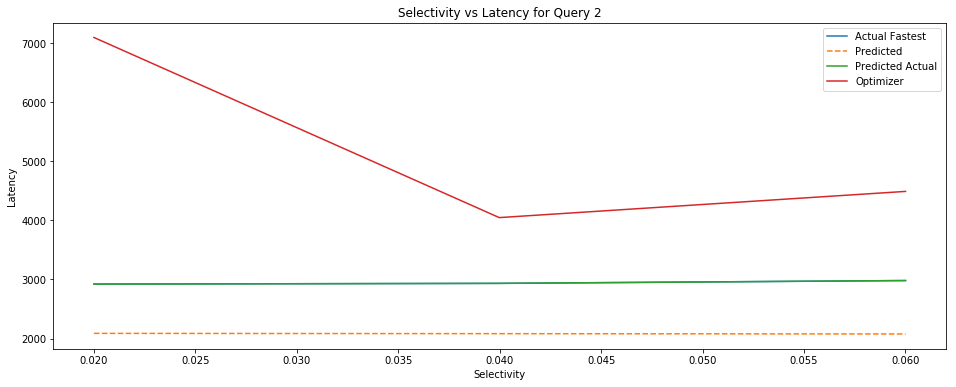

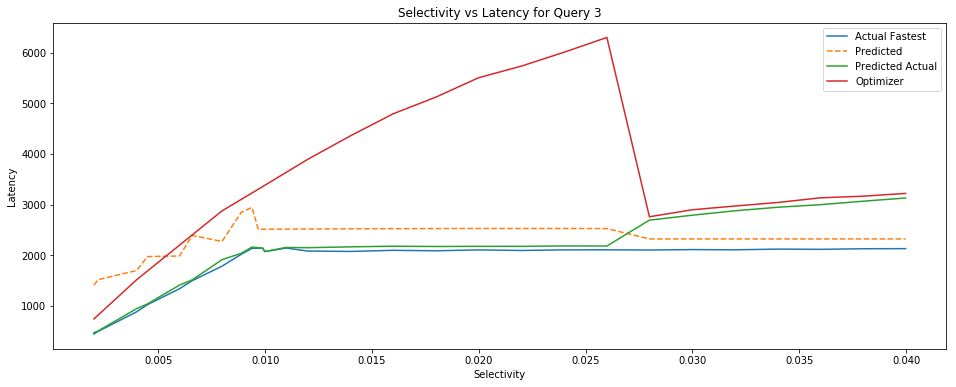

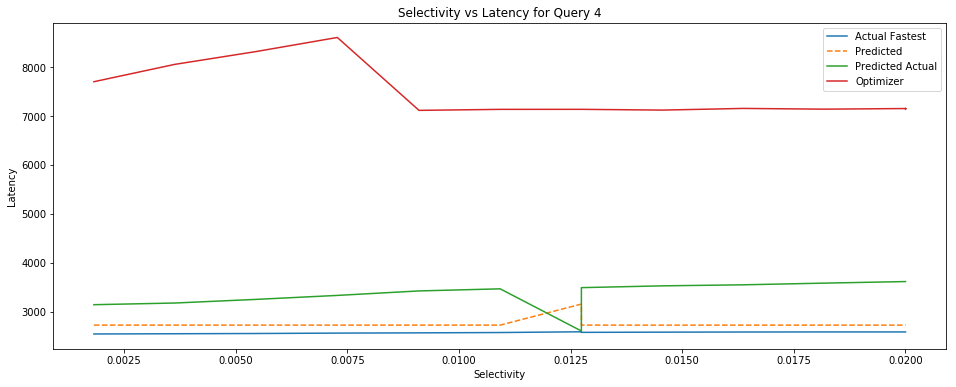

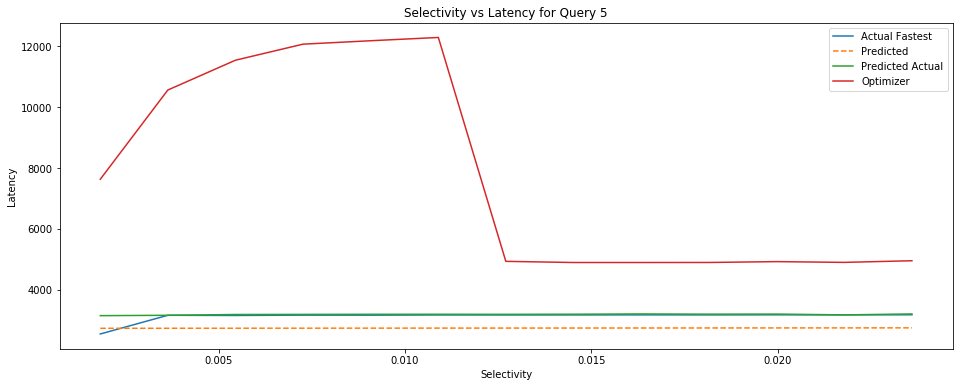

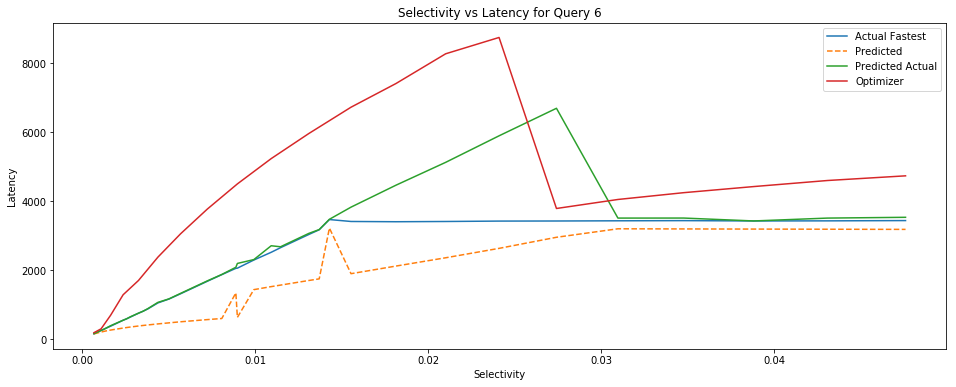

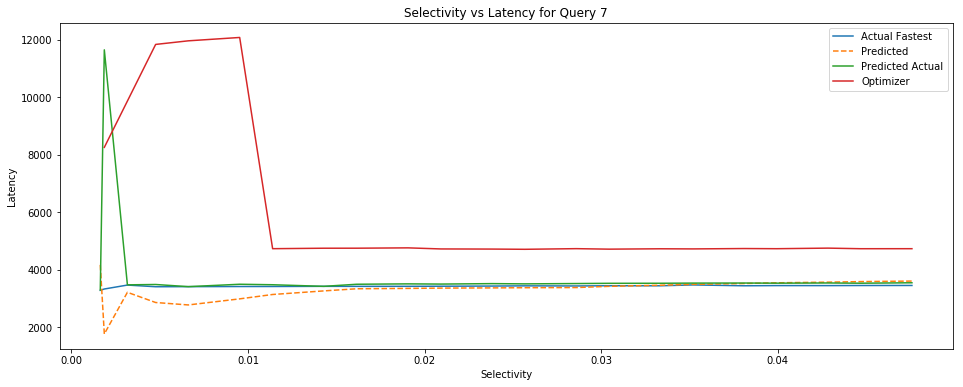

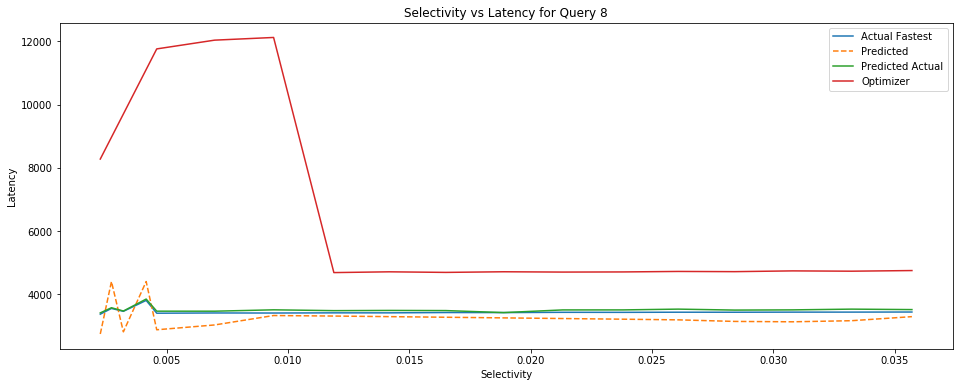

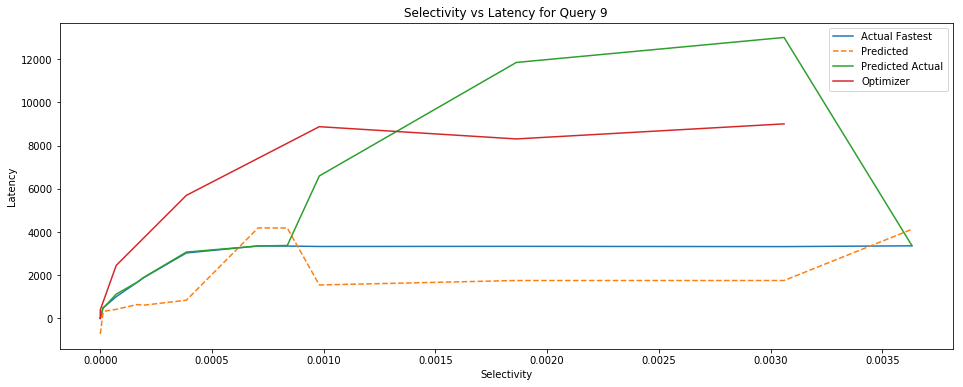

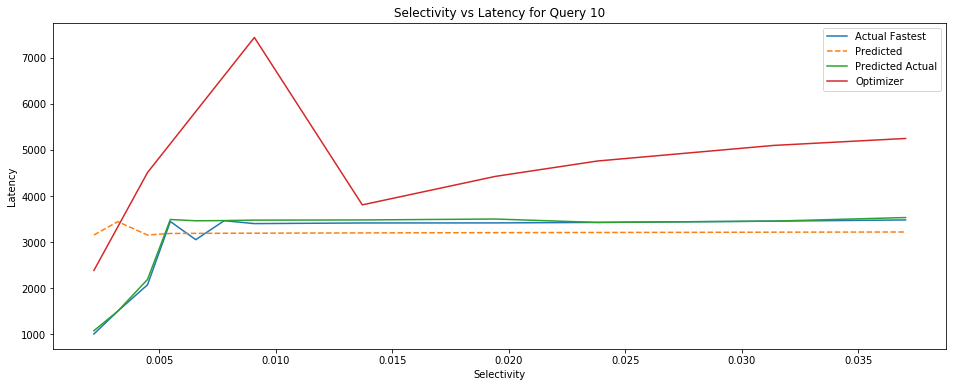

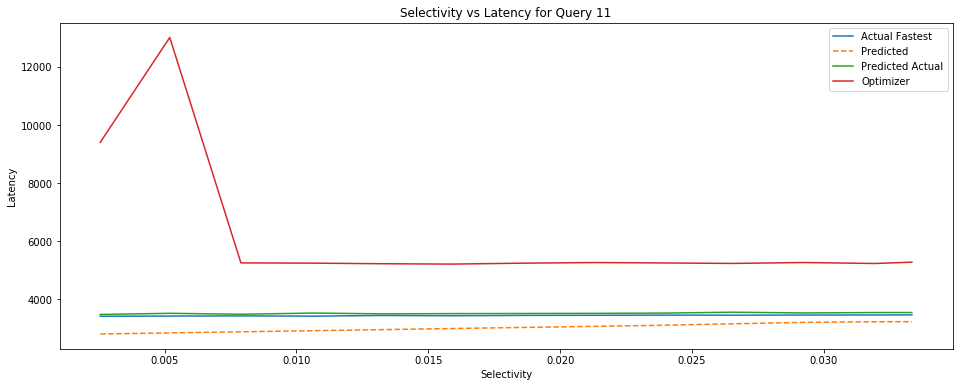

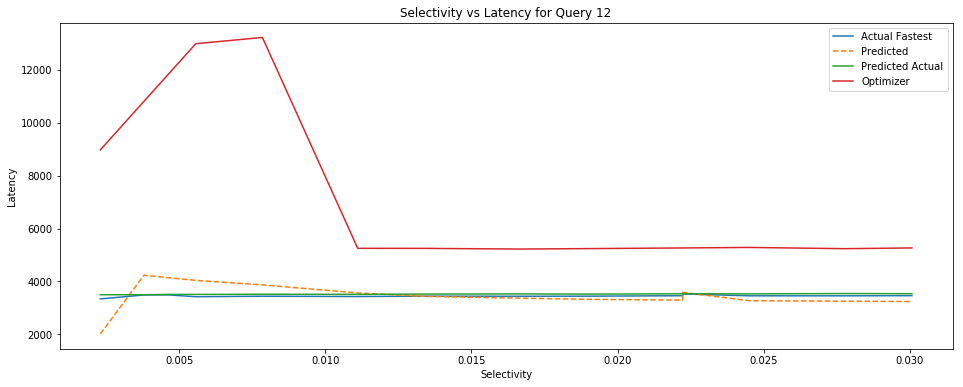

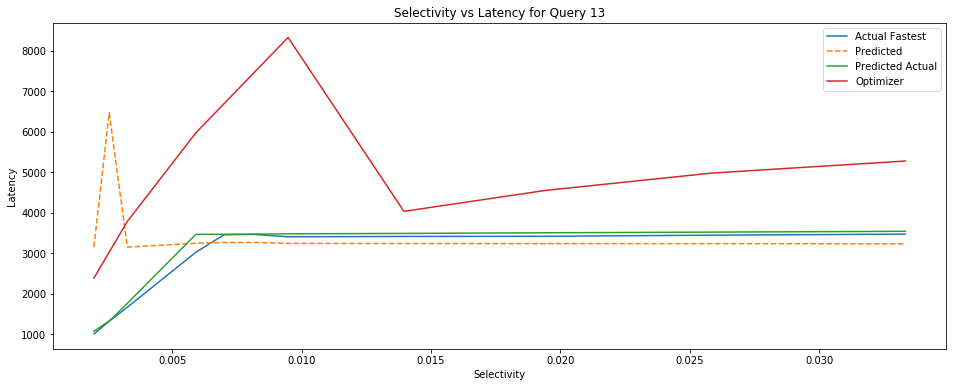

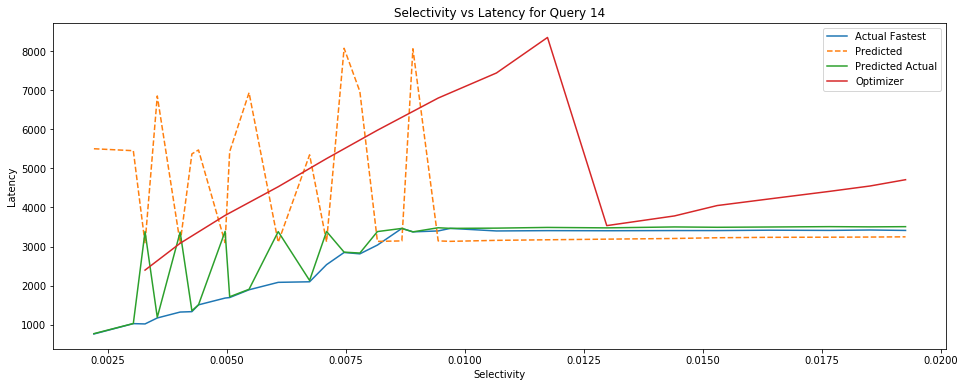

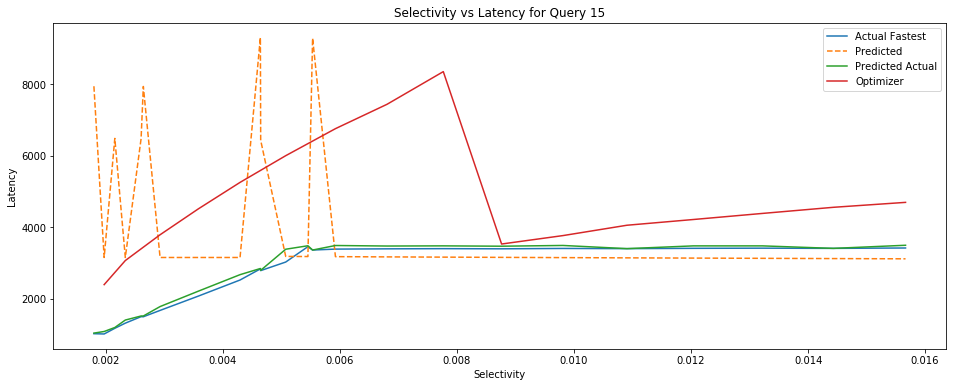

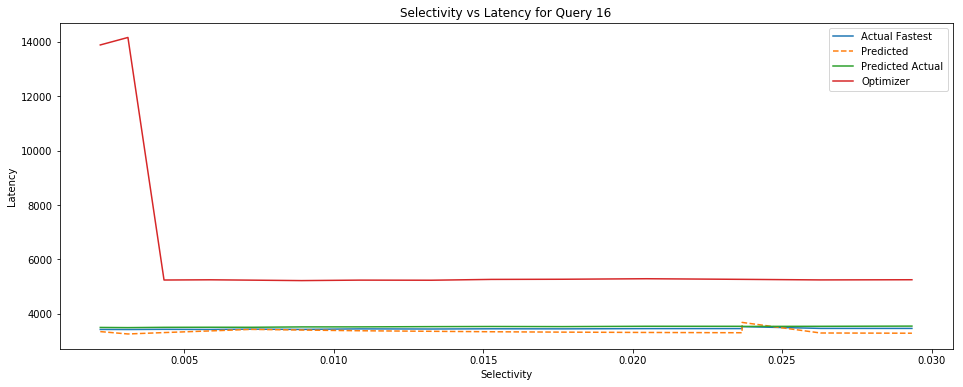

In [67]:
for q in range(2,17):
    plot_actual_vs_predicted(df_f[df_f["info_ec2"] == "c5d.4xlarge"], df_p[df_p["info_ec2"] == "c5d.4xlarge"], df_c5_opt, q)

Regularization didn't seem to buy us much. The winning design in Architecure 9